# 實作cGAN演算法，產生女士的十項配件(Fashion MNIST)
### 程式修改自[How to Develop a Conditional GAN (cGAN) From Scratch](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/)

In [1]:
# 載入相關套件
from numpy import zeros, ones, expand_dims
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Dropout, Embedding, Concatenate, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

## 定義判别神經網路

In [2]:
# 定義判别神經網路
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # 輸入 Y
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    li = Dense(in_shape[0] * in_shape[1])(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    # 輸入圖像
    in_image = Input(shape=in_shape)
    
    # 結合 Y 及圖像
    merge = Concatenate()([in_image, li])
    
    # 抽樣(downsampling)
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)
    
    # 定義模型的輸入及輸出
    model = Model([in_image, in_label], out_layer)
    
    # 編譯
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## 定義生成神經網路

In [3]:
# 定義生成神經網路
def define_generator(latent_dim, n_classes=10):
    # 輸入 Y
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    li = Dense(7 * 7)(li)
    li = Reshape((7, 7, 1))(li)
    
    # 輸入圖像
    in_lat = Input(shape=(latent_dim,))
    gen = Dense(128 * 7 * 7)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    
    # 結合 Y 及圖像
    merge = Concatenate()([gen, li])
    
    # 上採樣(upsampling)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    
    # 定義模型的輸入及輸出
    model = Model([in_lat, in_label], out_layer)
    return model

## 定義cGAN神經網路

In [4]:
# 定義cGAN神經網路
def define_gan(g_model, d_model):   
    d_model.trainable = False            # 判别神經網路不重新訓練
    gen_noise, gen_label = g_model.input # 取得生成神經網路的輸入
    gen_output = g_model.output          # 取得生成神經網路的輸出
    
    # 取得判别神經網路的輸出
    gan_output = d_model([gen_output, gen_label])
    
    # 定義模型的輸入及輸出
    model = Model([gen_noise, gen_label], gan_output)
    
    # 編譯
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

## 定義GAN的真實訓練資料集

In [5]:
# 載入 fashion mnist 資料集
def load_real_samples():
    (trainX, trainy), (_, _) = load_data()
    
    # 增加一維作為色彩通道
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    # 標準化，使像素值介於 [-1,1]
    X = (X - 127.5) / 127.5
    return [X, trainy]

# 定義模型的輸入 n 筆
def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    # 隨機抽樣 n 筆
    ix = randint(0, images.shape[0], n_samples)
    # fashion mnist 資料集的 X、Y 均作為 GAN 的輸入
    X, labels = images[ix], labels[ix]
    # GAN 的 Y 均為 1
    y = ones((n_samples, 1))
    return [X, labels], y

## 定義GAN的生成資料

In [6]:
# 生成隨機向量
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # 隨機向量
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    # 產生 n 個類別的 Y
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# 定義模型的生成資料 n 筆
def generate_fake_samples(generator, latent_dim, n_samples):
    # 生成隨機向量
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # 生成圖像
    images = generator.predict([z_input, labels_input])
    # 產生均為 0 的 Y
    y = zeros((n_samples, 1))
    return [images, labels_input], y

## 訓練模型

In [7]:
# 訓練模型
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    # 訓練
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # 隨機抽樣 n 筆
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # 更新判别神經網路權重
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
            # 生成隨機向量
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # 更新判别神經網路權重
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            # 生成一批的隨機向量
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # 產生均為 1 的 Y
            y_gan = ones((n_batch, 1))
            
            # 訓練模型
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
            # 顯示損失
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
            
    # 模型存檔
    g_model.save('cgan_generator.keras')

# 參數設定
latent_dim = 100                          # 隨機向量尺寸

d_model = define_discriminator()          # 建立判别神經網路
g_model = define_generator(latent_dim)    # 建立生成神經網路
gan_model = define_gan(g_model, d_model)  # 建立 GAN 神經網路

dataset = load_real_samples()             # 讀取訓練資料
# 訓練
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100)

C:\Users\mikec\anaconda3\envs\tfgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 0s 3ms/step
>1, 1/468, d1=0.653, d2=0.696 g=0.691
2/2 [==============================] - 0s 8ms/step
>1, 2/468, d1=0.572, d2=0.701 g=0.686
2/2 [==============================] - 0s 9ms/step
>1, 3/468, d1=0.516, d2=0.711 g=0.677
2/2 [==============================] - 0s 9ms/step
>1, 4/468, d1=0.460, d2=0.728 g=0.660
2/2 [==============================] - 0s 8ms/step
>1, 5/468, d1=0.404, d2=0.755 g=0.639
2/2 [==============================] - 0s 9ms/step
>1, 6/468, d1=0.344, d2=0.791 g=0.613
2/2 [==============================] - 0s 8ms/step
>1, 7/468, d1=0.306, d2=0.832 g=0.589
2/2 [==============================] - 0s 9ms/step
>1, 8/468, d1=0.287, d2=0.873 g=0.575
2/2 [==============================] - 0s 8ms/step
>1, 9/468, d1=0.275, d2=0.896 g=0.583
2/2 [==============================] - 0s 8ms/step
>1, 10/468, d1=0.279, d2=0.871 g=0.618
2/2 [==============================] - 0s 8ms/step
>1, 11/468, d1=0.302, d2=0.815 g=0.681
2/2 [==============

>1, 414/468, d1=0.667, d2=0.666 g=0.738
>1, 415/468, d1=0.636, d2=0.683 g=0.736
>1, 416/468, d1=0.653, d2=0.703 g=0.711
>1, 417/468, d1=0.653, d2=0.702 g=0.701
>1, 418/468, d1=0.657, d2=0.738 g=0.683
>1, 419/468, d1=0.647, d2=0.729 g=0.698
>1, 420/468, d1=0.676, d2=0.745 g=0.693
>1, 421/468, d1=0.694, d2=0.743 g=0.702
>1, 422/468, d1=0.680, d2=0.722 g=0.705
>1, 423/468, d1=0.677, d2=0.713 g=0.719
>1, 424/468, d1=0.656, d2=0.711 g=0.723
>1, 425/468, d1=0.654, d2=0.700 g=0.728
>1, 426/468, d1=0.701, d2=0.700 g=0.749
>1, 427/468, d1=0.643, d2=0.675 g=0.764
>1, 428/468, d1=0.668, d2=0.653 g=0.781
>1, 429/468, d1=0.706, d2=0.669 g=0.780
>1, 430/468, d1=0.676, d2=0.663 g=0.773
>1, 431/468, d1=0.668, d2=0.668 g=0.770
>1, 432/468, d1=0.685, d2=0.665 g=0.766
>1, 433/468, d1=0.661, d2=0.668 g=0.763
>1, 434/468, d1=0.666, d2=0.693 g=0.741
>1, 435/468, d1=0.697, d2=0.687 g=0.747
>1, 436/468, d1=0.701, d2=0.702 g=0.732
>1, 437/468, d1=0.676, d2=0.698 g=0.723
>1, 438/468, d1=0.666, d2=0.678 g=0.737


>2, 155/468, d1=0.584, d2=0.654 g=0.783
>2, 156/468, d1=0.611, d2=0.705 g=0.746
>2, 157/468, d1=0.595, d2=0.733 g=0.770
>2, 158/468, d1=0.619, d2=0.730 g=0.727
>2, 159/468, d1=0.584, d2=0.731 g=0.742
>2, 160/468, d1=0.638, d2=0.705 g=0.754
>2, 161/468, d1=0.607, d2=0.673 g=0.779
>2, 162/468, d1=0.632, d2=0.659 g=0.817
>2, 163/468, d1=0.621, d2=0.623 g=0.849
>2, 164/468, d1=0.624, d2=0.597 g=0.880
>2, 165/468, d1=0.598, d2=0.554 g=0.940
>2, 166/468, d1=0.572, d2=0.571 g=0.877
>2, 167/468, d1=0.602, d2=0.624 g=0.858
>2, 168/468, d1=0.601, d2=0.631 g=0.840
>2, 169/468, d1=0.611, d2=0.687 g=0.769
>2, 170/468, d1=0.583, d2=0.726 g=0.736
>2, 171/468, d1=0.603, d2=0.729 g=0.769
>2, 172/468, d1=0.565, d2=0.711 g=0.737
>2, 173/468, d1=0.598, d2=0.731 g=0.777
>2, 174/468, d1=0.625, d2=0.676 g=0.833
>2, 175/468, d1=0.590, d2=0.616 g=0.839
>2, 176/468, d1=0.622, d2=0.585 g=0.863
>2, 177/468, d1=0.567, d2=0.604 g=0.909
>2, 178/468, d1=0.590, d2=0.585 g=0.897
>2, 179/468, d1=0.590, d2=0.599 g=0.883


>2, 360/468, d1=0.634, d2=0.651 g=0.868
>2, 361/468, d1=0.661, d2=0.634 g=0.863
>2, 362/468, d1=0.664, d2=0.652 g=0.843
>2, 363/468, d1=0.662, d2=0.655 g=0.823
>2, 364/468, d1=0.700, d2=0.691 g=0.771
>2, 365/468, d1=0.697, d2=0.703 g=0.760
>2, 366/468, d1=0.677, d2=0.703 g=0.748
>2, 367/468, d1=0.720, d2=0.702 g=0.788
>2, 368/468, d1=0.675, d2=0.661 g=0.811
>2, 369/468, d1=0.711, d2=0.644 g=0.845
>2, 370/468, d1=0.665, d2=0.609 g=0.881
>2, 371/468, d1=0.652, d2=0.602 g=0.881
>2, 372/468, d1=0.659, d2=0.626 g=0.912
>2, 373/468, d1=0.682, d2=0.647 g=0.821
>2, 374/468, d1=0.632, d2=0.695 g=0.794
>2, 375/468, d1=0.647, d2=0.681 g=0.783
>2, 376/468, d1=0.639, d2=0.693 g=0.751
>2, 377/468, d1=0.606, d2=0.660 g=0.813
>2, 378/468, d1=0.657, d2=0.647 g=0.872
>2, 379/468, d1=0.610, d2=0.612 g=0.888
>2, 380/468, d1=0.633, d2=0.581 g=0.897
>2, 381/468, d1=0.595, d2=0.624 g=0.922
>2, 382/468, d1=0.598, d2=0.588 g=0.891
>2, 383/468, d1=0.635, d2=0.623 g=0.849
>2, 384/468, d1=0.580, d2=0.658 g=0.795


>3, 100/468, d1=0.658, d2=0.653 g=0.789
>3, 101/468, d1=0.660, d2=0.628 g=0.821
>3, 102/468, d1=0.682, d2=0.628 g=0.851
>3, 103/468, d1=0.685, d2=0.604 g=0.835
>3, 104/468, d1=0.710, d2=0.620 g=0.834
>3, 105/468, d1=0.665, d2=0.614 g=0.842
>3, 106/468, d1=0.701, d2=0.606 g=0.831
>3, 107/468, d1=0.688, d2=0.640 g=0.848
>3, 108/468, d1=0.733, d2=0.645 g=0.813
>3, 109/468, d1=0.716, d2=0.644 g=0.799
>3, 110/468, d1=0.684, d2=0.622 g=0.786
>3, 111/468, d1=0.658, d2=0.672 g=0.804
>3, 112/468, d1=0.691, d2=0.659 g=0.806
>3, 113/468, d1=0.675, d2=0.607 g=0.804
>3, 114/468, d1=0.668, d2=0.636 g=0.812
>3, 115/468, d1=0.659, d2=0.662 g=0.813
>3, 116/468, d1=0.669, d2=0.671 g=0.819
>3, 117/468, d1=0.672, d2=0.659 g=0.803
>3, 118/468, d1=0.664, d2=0.627 g=0.824
>3, 119/468, d1=0.713, d2=0.675 g=0.821
>3, 120/468, d1=0.643, d2=0.673 g=0.824
>3, 121/468, d1=0.700, d2=0.617 g=0.829
>3, 122/468, d1=0.698, d2=0.651 g=0.816
>3, 123/468, d1=0.675, d2=0.620 g=0.830
>3, 124/468, d1=0.709, d2=0.661 g=0.825


>3, 305/468, d1=0.696, d2=0.675 g=0.767
>3, 306/468, d1=0.663, d2=0.664 g=0.781
>3, 307/468, d1=0.665, d2=0.666 g=0.775
>3, 308/468, d1=0.679, d2=0.674 g=0.760
>3, 309/468, d1=0.644, d2=0.647 g=0.776
>3, 310/468, d1=0.657, d2=0.668 g=0.757
>3, 311/468, d1=0.675, d2=0.689 g=0.756
>3, 312/468, d1=0.687, d2=0.671 g=0.778
>3, 313/468, d1=0.703, d2=0.680 g=0.762
>3, 314/468, d1=0.702, d2=0.647 g=0.772
>3, 315/468, d1=0.706, d2=0.651 g=0.794
>3, 316/468, d1=0.709, d2=0.633 g=0.803
>3, 317/468, d1=0.689, d2=0.629 g=0.782
>3, 318/468, d1=0.682, d2=0.629 g=0.799
>3, 319/468, d1=0.711, d2=0.659 g=0.805
>3, 320/468, d1=0.689, d2=0.668 g=0.778
>3, 321/468, d1=0.651, d2=0.669 g=0.785
>3, 322/468, d1=0.686, d2=0.678 g=0.784
>3, 323/468, d1=0.686, d2=0.648 g=0.784
>3, 324/468, d1=0.666, d2=0.676 g=0.773
>3, 325/468, d1=0.669, d2=0.641 g=0.773
>3, 326/468, d1=0.703, d2=0.670 g=0.772
>3, 327/468, d1=0.636, d2=0.663 g=0.777
>3, 328/468, d1=0.673, d2=0.669 g=0.779
>3, 329/468, d1=0.636, d2=0.672 g=0.749


>4, 44/468, d1=0.690, d2=0.667 g=0.787
>4, 45/468, d1=0.660, d2=0.625 g=0.795
>4, 46/468, d1=0.676, d2=0.655 g=0.824
>4, 47/468, d1=0.694, d2=0.621 g=0.877
>4, 48/468, d1=0.725, d2=0.618 g=0.821
>4, 49/468, d1=0.715, d2=0.634 g=0.825
>4, 50/468, d1=0.689, d2=0.616 g=0.830
>4, 51/468, d1=0.671, d2=0.647 g=0.807
>4, 52/468, d1=0.690, d2=0.647 g=0.818
>4, 53/468, d1=0.701, d2=0.633 g=0.791
>4, 54/468, d1=0.678, d2=0.655 g=0.775
>4, 55/468, d1=0.683, d2=0.656 g=0.773
>4, 56/468, d1=0.666, d2=0.659 g=0.765
>4, 57/468, d1=0.660, d2=0.656 g=0.776
>4, 58/468, d1=0.670, d2=0.651 g=0.782
>4, 59/468, d1=0.664, d2=0.632 g=0.780
>4, 60/468, d1=0.679, d2=0.644 g=0.770
>4, 61/468, d1=0.646, d2=0.649 g=0.776
>4, 62/468, d1=0.671, d2=0.671 g=0.772
>4, 63/468, d1=0.663, d2=0.652 g=0.796
>4, 64/468, d1=0.692, d2=0.650 g=0.781
>4, 65/468, d1=0.675, d2=0.661 g=0.783
>4, 66/468, d1=0.653, d2=0.630 g=0.786
>4, 67/468, d1=0.667, d2=0.657 g=0.811
>4, 68/468, d1=0.683, d2=0.639 g=0.812
>4, 69/468, d1=0.666, d2=

>4, 251/468, d1=0.660, d2=0.658 g=0.801
>4, 252/468, d1=0.646, d2=0.632 g=0.832
>4, 253/468, d1=0.665, d2=0.619 g=0.827
>4, 254/468, d1=0.657, d2=0.631 g=0.845
>4, 255/468, d1=0.649, d2=0.631 g=0.807
>4, 256/468, d1=0.681, d2=0.678 g=0.783
>4, 257/468, d1=0.671, d2=0.698 g=0.763
>4, 258/468, d1=0.632, d2=0.730 g=0.773
>4, 259/468, d1=0.653, d2=0.662 g=0.772
>4, 260/468, d1=0.693, d2=0.676 g=0.805
>4, 261/468, d1=0.699, d2=0.622 g=0.812
>4, 262/468, d1=0.721, d2=0.627 g=0.825
>4, 263/468, d1=0.731, d2=0.608 g=0.827
>4, 264/468, d1=0.686, d2=0.640 g=0.874
>4, 265/468, d1=0.756, d2=0.624 g=0.829
>4, 266/468, d1=0.678, d2=0.649 g=0.773
>4, 267/468, d1=0.654, d2=0.664 g=0.787
>4, 268/468, d1=0.684, d2=0.664 g=0.764
>4, 269/468, d1=0.690, d2=0.654 g=0.755
>4, 270/468, d1=0.681, d2=0.661 g=0.752
>4, 271/468, d1=0.696, d2=0.705 g=0.739
>4, 272/468, d1=0.680, d2=0.680 g=0.760
>4, 273/468, d1=0.666, d2=0.673 g=0.751
>4, 274/468, d1=0.662, d2=0.685 g=0.752
>4, 275/468, d1=0.671, d2=0.694 g=0.740


>4, 456/468, d1=0.691, d2=0.678 g=0.768
>4, 457/468, d1=0.667, d2=0.674 g=0.786
>4, 458/468, d1=0.695, d2=0.665 g=0.804
>4, 459/468, d1=0.711, d2=0.646 g=0.778
>4, 460/468, d1=0.673, d2=0.652 g=0.775
>4, 461/468, d1=0.705, d2=0.689 g=0.765
>4, 462/468, d1=0.695, d2=0.692 g=0.749
>4, 463/468, d1=0.697, d2=0.689 g=0.754
>4, 464/468, d1=0.653, d2=0.659 g=0.757
>4, 465/468, d1=0.679, d2=0.665 g=0.749
>4, 466/468, d1=0.671, d2=0.684 g=0.747
>4, 467/468, d1=0.669, d2=0.682 g=0.749
>4, 468/468, d1=0.668, d2=0.713 g=0.745
>5, 1/468, d1=0.684, d2=0.686 g=0.730
>5, 2/468, d1=0.676, d2=0.703 g=0.733
>5, 3/468, d1=0.673, d2=0.693 g=0.747
>5, 4/468, d1=0.667, d2=0.694 g=0.748
>5, 5/468, d1=0.688, d2=0.682 g=0.742
>5, 6/468, d1=0.685, d2=0.671 g=0.761
>5, 7/468, d1=0.675, d2=0.646 g=0.776
>5, 8/468, d1=0.689, d2=0.660 g=0.723
>5, 9/468, d1=0.660, d2=0.680 g=0.746
>5, 10/468, d1=0.672, d2=0.670 g=0.744
>5, 11/468, d1=0.686, d2=0.704 g=0.729
>5, 12/468, d1=0.677, d2=0.666 g=0.766
>5, 13/468, d1=0.689,

>5, 197/468, d1=0.666, d2=0.663 g=0.777
>5, 198/468, d1=0.643, d2=0.676 g=0.778
>5, 199/468, d1=0.653, d2=0.657 g=0.763
>5, 200/468, d1=0.648, d2=0.678 g=0.770
>5, 201/468, d1=0.659, d2=0.682 g=0.749
>5, 202/468, d1=0.647, d2=0.671 g=0.766
>5, 203/468, d1=0.655, d2=0.655 g=0.761
>5, 204/468, d1=0.664, d2=0.664 g=0.769
>5, 205/468, d1=0.658, d2=0.658 g=0.747
>5, 206/468, d1=0.656, d2=0.648 g=0.755
>5, 207/468, d1=0.659, d2=0.674 g=0.754
>5, 208/468, d1=0.672, d2=0.677 g=0.756
>5, 209/468, d1=0.677, d2=0.661 g=0.762
>5, 210/468, d1=0.660, d2=0.675 g=0.746
>5, 211/468, d1=0.676, d2=0.676 g=0.744
>5, 212/468, d1=0.639, d2=0.677 g=0.752
>5, 213/468, d1=0.683, d2=0.682 g=0.759
>5, 214/468, d1=0.683, d2=0.668 g=0.777
>5, 215/468, d1=0.678, d2=0.654 g=0.754
>5, 216/468, d1=0.641, d2=0.678 g=0.784
>5, 217/468, d1=0.686, d2=0.652 g=0.790
>5, 218/468, d1=0.672, d2=0.658 g=0.796
>5, 219/468, d1=0.672, d2=0.635 g=0.803
>5, 220/468, d1=0.702, d2=0.656 g=0.811
>5, 221/468, d1=0.684, d2=0.669 g=0.763


>5, 402/468, d1=0.654, d2=0.685 g=0.762
>5, 403/468, d1=0.632, d2=0.672 g=0.770
>5, 404/468, d1=0.663, d2=0.650 g=0.779
>5, 405/468, d1=0.643, d2=0.665 g=0.766
>5, 406/468, d1=0.650, d2=0.697 g=0.773
>5, 407/468, d1=0.662, d2=0.650 g=0.774
>5, 408/468, d1=0.649, d2=0.670 g=0.786
>5, 409/468, d1=0.649, d2=0.660 g=0.772
>5, 410/468, d1=0.668, d2=0.679 g=0.764
>5, 411/468, d1=0.653, d2=0.676 g=0.764
>5, 412/468, d1=0.668, d2=0.652 g=0.752
>5, 413/468, d1=0.646, d2=0.698 g=0.752
>5, 414/468, d1=0.642, d2=0.706 g=0.743
>5, 415/468, d1=0.636, d2=0.683 g=0.767
>5, 416/468, d1=0.665, d2=0.669 g=0.750
>5, 417/468, d1=0.679, d2=0.654 g=0.781
>5, 418/468, d1=0.652, d2=0.682 g=0.745
>5, 419/468, d1=0.636, d2=0.688 g=0.773
>5, 420/468, d1=0.653, d2=0.674 g=0.781
>5, 421/468, d1=0.648, d2=0.663 g=0.772
>5, 422/468, d1=0.666, d2=0.650 g=0.800
>5, 423/468, d1=0.655, d2=0.653 g=0.806
>5, 424/468, d1=0.643, d2=0.637 g=0.789
>5, 425/468, d1=0.672, d2=0.659 g=0.764
>5, 426/468, d1=0.678, d2=0.651 g=0.766


>6, 143/468, d1=0.696, d2=0.642 g=0.785
>6, 144/468, d1=0.650, d2=0.636 g=0.816
>6, 145/468, d1=0.659, d2=0.647 g=0.823
>6, 146/468, d1=0.656, d2=0.635 g=0.800
>6, 147/468, d1=0.672, d2=0.686 g=0.791
>6, 148/468, d1=0.640, d2=0.679 g=0.749
>6, 149/468, d1=0.651, d2=0.685 g=0.770
>6, 150/468, d1=0.652, d2=0.676 g=0.793
>6, 151/468, d1=0.677, d2=0.638 g=0.801
>6, 152/468, d1=0.685, d2=0.610 g=0.821
>6, 153/468, d1=0.661, d2=0.609 g=0.826
>6, 154/468, d1=0.648, d2=0.621 g=0.812
>6, 155/468, d1=0.675, d2=0.643 g=0.783
>6, 156/468, d1=0.676, d2=0.672 g=0.767
>6, 157/468, d1=0.657, d2=0.655 g=0.769
>6, 158/468, d1=0.671, d2=0.652 g=0.770
>6, 159/468, d1=0.659, d2=0.644 g=0.787
>6, 160/468, d1=0.652, d2=0.644 g=0.797
>6, 161/468, d1=0.670, d2=0.669 g=0.792
>6, 162/468, d1=0.642, d2=0.681 g=0.765
>6, 163/468, d1=0.645, d2=0.682 g=0.781
>6, 164/468, d1=0.623, d2=0.685 g=0.761
>6, 165/468, d1=0.669, d2=0.683 g=0.788
>6, 166/468, d1=0.647, d2=0.690 g=0.796
>6, 167/468, d1=0.644, d2=0.655 g=0.795


>6, 348/468, d1=0.679, d2=0.693 g=0.761
>6, 349/468, d1=0.695, d2=0.691 g=0.754
>6, 350/468, d1=0.669, d2=0.671 g=0.793
>6, 351/468, d1=0.663, d2=0.663 g=0.791
>6, 352/468, d1=0.635, d2=0.618 g=0.808
>6, 353/468, d1=0.668, d2=0.669 g=0.804
>6, 354/468, d1=0.642, d2=0.643 g=0.812
>6, 355/468, d1=0.649, d2=0.683 g=0.796
>6, 356/468, d1=0.629, d2=0.693 g=0.758
>6, 357/468, d1=0.649, d2=0.686 g=0.756
>6, 358/468, d1=0.625, d2=0.677 g=0.754
>6, 359/468, d1=0.682, d2=0.663 g=0.771
>6, 360/468, d1=0.647, d2=0.647 g=0.784
>6, 361/468, d1=0.670, d2=0.629 g=0.836
>6, 362/468, d1=0.643, d2=0.627 g=0.817
>6, 363/468, d1=0.683, d2=0.629 g=0.793
>6, 364/468, d1=0.675, d2=0.688 g=0.766
>6, 365/468, d1=0.688, d2=0.669 g=0.785
>6, 366/468, d1=0.658, d2=0.674 g=0.776
>6, 367/468, d1=0.660, d2=0.672 g=0.791
>6, 368/468, d1=0.677, d2=0.655 g=0.784
>6, 369/468, d1=0.652, d2=0.637 g=0.782
>6, 370/468, d1=0.662, d2=0.632 g=0.788
>6, 371/468, d1=0.667, d2=0.672 g=0.771
>6, 372/468, d1=0.678, d2=0.679 g=0.773


>7, 89/468, d1=0.649, d2=0.653 g=0.753
>7, 90/468, d1=0.670, d2=0.703 g=0.744
>7, 91/468, d1=0.655, d2=0.696 g=0.745
>7, 92/468, d1=0.637, d2=0.683 g=0.760
>7, 93/468, d1=0.648, d2=0.667 g=0.791
>7, 94/468, d1=0.649, d2=0.642 g=0.801
>7, 95/468, d1=0.686, d2=0.657 g=0.810
>7, 96/468, d1=0.690, d2=0.681 g=0.797
>7, 97/468, d1=0.655, d2=0.664 g=0.777
>7, 98/468, d1=0.643, d2=0.678 g=0.797
>7, 99/468, d1=0.664, d2=0.658 g=0.771
>7, 100/468, d1=0.663, d2=0.661 g=0.771
>7, 101/468, d1=0.651, d2=0.664 g=0.810
>7, 102/468, d1=0.650, d2=0.645 g=0.791
>7, 103/468, d1=0.642, d2=0.675 g=0.792
>7, 104/468, d1=0.673, d2=0.661 g=0.771
>7, 105/468, d1=0.702, d2=0.677 g=0.761
>7, 106/468, d1=0.645, d2=0.663 g=0.779
>7, 107/468, d1=0.662, d2=0.648 g=0.786
>7, 108/468, d1=0.651, d2=0.634 g=0.775
>7, 109/468, d1=0.660, d2=0.623 g=0.790
>7, 110/468, d1=0.668, d2=0.651 g=0.774
>7, 111/468, d1=0.672, d2=0.674 g=0.764
>7, 112/468, d1=0.672, d2=0.689 g=0.762
>7, 113/468, d1=0.644, d2=0.659 g=0.781
>7, 114/468

>7, 295/468, d1=0.656, d2=0.666 g=0.771
>7, 296/468, d1=0.654, d2=0.669 g=0.776
>7, 297/468, d1=0.683, d2=0.670 g=0.783
>7, 298/468, d1=0.651, d2=0.642 g=0.767
>7, 299/468, d1=0.658, d2=0.683 g=0.796
>7, 300/468, d1=0.687, d2=0.631 g=0.794
>7, 301/468, d1=0.669, d2=0.642 g=0.800
>7, 302/468, d1=0.662, d2=0.641 g=0.797
>7, 303/468, d1=0.644, d2=0.650 g=0.781
>7, 304/468, d1=0.647, d2=0.658 g=0.779
>7, 305/468, d1=0.663, d2=0.638 g=0.815
>7, 306/468, d1=0.653, d2=0.642 g=0.769
>7, 307/468, d1=0.708, d2=0.647 g=0.783
>7, 308/468, d1=0.665, d2=0.644 g=0.784
>7, 309/468, d1=0.659, d2=0.681 g=0.765
>7, 310/468, d1=0.692, d2=0.671 g=0.810
>7, 311/468, d1=0.655, d2=0.638 g=0.834
>7, 312/468, d1=0.712, d2=0.618 g=0.839
>7, 313/468, d1=0.662, d2=0.640 g=0.814
>7, 314/468, d1=0.717, d2=0.656 g=0.759
>7, 315/468, d1=0.673, d2=0.660 g=0.768
>7, 316/468, d1=0.655, d2=0.680 g=0.777
>7, 317/468, d1=0.653, d2=0.660 g=0.787
>7, 318/468, d1=0.643, d2=0.658 g=0.807
>7, 319/468, d1=0.671, d2=0.626 g=0.819


>8, 34/468, d1=0.660, d2=0.677 g=0.798
>8, 35/468, d1=0.692, d2=0.681 g=0.760
>8, 36/468, d1=0.658, d2=0.658 g=0.781
>8, 37/468, d1=0.647, d2=0.651 g=0.779
>8, 38/468, d1=0.678, d2=0.663 g=0.782
>8, 39/468, d1=0.634, d2=0.672 g=0.792
>8, 40/468, d1=0.666, d2=0.643 g=0.807
>8, 41/468, d1=0.654, d2=0.685 g=0.774
>8, 42/468, d1=0.660, d2=0.666 g=0.781
>8, 43/468, d1=0.674, d2=0.650 g=0.791
>8, 44/468, d1=0.679, d2=0.651 g=0.781
>8, 45/468, d1=0.708, d2=0.655 g=0.766
>8, 46/468, d1=0.657, d2=0.670 g=0.800
>8, 47/468, d1=0.677, d2=0.664 g=0.782
>8, 48/468, d1=0.680, d2=0.651 g=0.772
>8, 49/468, d1=0.670, d2=0.694 g=0.774
>8, 50/468, d1=0.655, d2=0.655 g=0.771
>8, 51/468, d1=0.654, d2=0.655 g=0.784
>8, 52/468, d1=0.667, d2=0.683 g=0.757
>8, 53/468, d1=0.676, d2=0.646 g=0.785
>8, 54/468, d1=0.686, d2=0.697 g=0.784
>8, 55/468, d1=0.654, d2=0.683 g=0.773
>8, 56/468, d1=0.684, d2=0.665 g=0.781
>8, 57/468, d1=0.666, d2=0.655 g=0.814
>8, 58/468, d1=0.671, d2=0.653 g=0.792
>8, 59/468, d1=0.652, d2=

>8, 241/468, d1=0.690, d2=0.688 g=0.742
>8, 242/468, d1=0.648, d2=0.666 g=0.795
>8, 243/468, d1=0.632, d2=0.625 g=0.823
>8, 244/468, d1=0.625, d2=0.683 g=0.787
>8, 245/468, d1=0.637, d2=0.675 g=0.766
>8, 246/468, d1=0.640, d2=0.702 g=0.791
>8, 247/468, d1=0.662, d2=0.692 g=0.757
>8, 248/468, d1=0.656, d2=0.677 g=0.801
>8, 249/468, d1=0.666, d2=0.631 g=0.786
>8, 250/468, d1=0.703, d2=0.635 g=0.818
>8, 251/468, d1=0.643, d2=0.635 g=0.823
>8, 252/468, d1=0.670, d2=0.639 g=0.843
>8, 253/468, d1=0.662, d2=0.659 g=0.792
>8, 254/468, d1=0.698, d2=0.666 g=0.770
>8, 255/468, d1=0.637, d2=0.659 g=0.771
>8, 256/468, d1=0.704, d2=0.659 g=0.799
>8, 257/468, d1=0.667, d2=0.650 g=0.783
>8, 258/468, d1=0.684, d2=0.622 g=0.787
>8, 259/468, d1=0.676, d2=0.657 g=0.804
>8, 260/468, d1=0.673, d2=0.680 g=0.763
>8, 261/468, d1=0.667, d2=0.679 g=0.783
>8, 262/468, d1=0.711, d2=0.681 g=0.760
>8, 263/468, d1=0.695, d2=0.645 g=0.791
>8, 264/468, d1=0.632, d2=0.623 g=0.804
>8, 265/468, d1=0.681, d2=0.624 g=0.817


>8, 447/468, d1=0.680, d2=0.677 g=0.784
>8, 448/468, d1=0.631, d2=0.693 g=0.775
>8, 449/468, d1=0.695, d2=0.673 g=0.816
>8, 450/468, d1=0.690, d2=0.647 g=0.803
>8, 451/468, d1=0.667, d2=0.623 g=0.831
>8, 452/468, d1=0.713, d2=0.664 g=0.781
>8, 453/468, d1=0.682, d2=0.649 g=0.784
>8, 454/468, d1=0.628, d2=0.657 g=0.777
>8, 455/468, d1=0.680, d2=0.671 g=0.778
>8, 456/468, d1=0.684, d2=0.654 g=0.803
>8, 457/468, d1=0.685, d2=0.669 g=0.801
>8, 458/468, d1=0.677, d2=0.635 g=0.775
>8, 459/468, d1=0.691, d2=0.671 g=0.754
>8, 460/468, d1=0.687, d2=0.664 g=0.765
>8, 461/468, d1=0.659, d2=0.655 g=0.759
>8, 462/468, d1=0.671, d2=0.676 g=0.775
>8, 463/468, d1=0.658, d2=0.645 g=0.755
>8, 464/468, d1=0.676, d2=0.685 g=0.788
>8, 465/468, d1=0.665, d2=0.651 g=0.773
>8, 466/468, d1=0.642, d2=0.662 g=0.775
>8, 467/468, d1=0.662, d2=0.673 g=0.779
>8, 468/468, d1=0.675, d2=0.684 g=0.748
>9, 1/468, d1=0.647, d2=0.679 g=0.746
>9, 2/468, d1=0.659, d2=0.710 g=0.761
>9, 3/468, d1=0.639, d2=0.665 g=0.777
>9, 4/

>9, 187/468, d1=0.685, d2=0.677 g=0.762
>9, 188/468, d1=0.715, d2=0.679 g=0.728
>9, 189/468, d1=0.649, d2=0.694 g=0.774
>9, 190/468, d1=0.655, d2=0.686 g=0.767
>9, 191/468, d1=0.701, d2=0.639 g=0.813
>9, 192/468, d1=0.639, d2=0.631 g=0.808
>9, 193/468, d1=0.729, d2=0.658 g=0.798
>9, 194/468, d1=0.689, d2=0.671 g=0.763
>9, 195/468, d1=0.684, d2=0.690 g=0.756
>9, 196/468, d1=0.666, d2=0.673 g=0.794
>9, 197/468, d1=0.664, d2=0.632 g=0.810
>9, 198/468, d1=0.669, d2=0.638 g=0.805
>9, 199/468, d1=0.666, d2=0.655 g=0.778
>9, 200/468, d1=0.646, d2=0.671 g=0.752
>9, 201/468, d1=0.712, d2=0.729 g=0.742
>9, 202/468, d1=0.655, d2=0.688 g=0.759
>9, 203/468, d1=0.642, d2=0.695 g=0.775
>9, 204/468, d1=0.660, d2=0.660 g=0.820
>9, 205/468, d1=0.667, d2=0.649 g=0.850
>9, 206/468, d1=0.709, d2=0.646 g=0.853
>9, 207/468, d1=0.733, d2=0.635 g=0.780
>9, 208/468, d1=0.680, d2=0.690 g=0.778
>9, 209/468, d1=0.698, d2=0.672 g=0.764
>9, 210/468, d1=0.695, d2=0.660 g=0.749
>9, 211/468, d1=0.682, d2=0.668 g=0.755


>9, 393/468, d1=0.664, d2=0.661 g=0.781
>9, 394/468, d1=0.644, d2=0.658 g=0.772
>9, 395/468, d1=0.659, d2=0.668 g=0.782
>9, 396/468, d1=0.709, d2=0.669 g=0.755
>9, 397/468, d1=0.660, d2=0.648 g=0.805
>9, 398/468, d1=0.677, d2=0.638 g=0.799
>9, 399/468, d1=0.676, d2=0.663 g=0.788
>9, 400/468, d1=0.674, d2=0.636 g=0.812
>9, 401/468, d1=0.678, d2=0.673 g=0.792
>9, 402/468, d1=0.696, d2=0.663 g=0.767
>9, 403/468, d1=0.680, d2=0.646 g=0.774
>9, 404/468, d1=0.676, d2=0.687 g=0.764
>9, 405/468, d1=0.700, d2=0.643 g=0.786
>9, 406/468, d1=0.682, d2=0.654 g=0.750
>9, 407/468, d1=0.705, d2=0.678 g=0.791
>9, 408/468, d1=0.698, d2=0.636 g=0.784
>9, 409/468, d1=0.659, d2=0.663 g=0.794
>9, 410/468, d1=0.697, d2=0.651 g=0.795
>9, 411/468, d1=0.679, d2=0.664 g=0.770
>9, 412/468, d1=0.677, d2=0.663 g=0.773
>9, 413/468, d1=0.643, d2=0.643 g=0.788
>9, 414/468, d1=0.675, d2=0.652 g=0.756
>9, 415/468, d1=0.732, d2=0.689 g=0.767
>9, 416/468, d1=0.695, d2=0.658 g=0.777
>9, 417/468, d1=0.667, d2=0.679 g=0.760


>10, 130/468, d1=0.687, d2=0.656 g=0.775
>10, 131/468, d1=0.687, d2=0.669 g=0.796
>10, 132/468, d1=0.650, d2=0.677 g=0.793
>10, 133/468, d1=0.693, d2=0.695 g=0.769
>10, 134/468, d1=0.659, d2=0.674 g=0.775
>10, 135/468, d1=0.642, d2=0.672 g=0.774
>10, 136/468, d1=0.683, d2=0.690 g=0.754
>10, 137/468, d1=0.664, d2=0.676 g=0.754
>10, 138/468, d1=0.629, d2=0.695 g=0.786
>10, 139/468, d1=0.630, d2=0.663 g=0.780
>10, 140/468, d1=0.645, d2=0.662 g=0.777
>10, 141/468, d1=0.668, d2=0.682 g=0.752
>10, 142/468, d1=0.689, d2=0.694 g=0.791
>10, 143/468, d1=0.693, d2=0.648 g=0.782
>10, 144/468, d1=0.651, d2=0.646 g=0.804
>10, 145/468, d1=0.663, d2=0.644 g=0.825
>10, 146/468, d1=0.677, d2=0.637 g=0.816
>10, 147/468, d1=0.698, d2=0.668 g=0.751
>10, 148/468, d1=0.669, d2=0.698 g=0.755
>10, 149/468, d1=0.667, d2=0.722 g=0.753
>10, 150/468, d1=0.646, d2=0.642 g=0.789
>10, 151/468, d1=0.676, d2=0.654 g=0.843
>10, 152/468, d1=0.680, d2=0.652 g=0.829
>10, 153/468, d1=0.667, d2=0.643 g=0.786
>10, 154/468, d1

>10, 331/468, d1=0.666, d2=0.623 g=0.779
>10, 332/468, d1=0.675, d2=0.681 g=0.789
>10, 333/468, d1=0.669, d2=0.686 g=0.760
>10, 334/468, d1=0.671, d2=0.655 g=0.776
>10, 335/468, d1=0.696, d2=0.650 g=0.763
>10, 336/468, d1=0.676, d2=0.641 g=0.768
>10, 337/468, d1=0.688, d2=0.684 g=0.764
>10, 338/468, d1=0.653, d2=0.642 g=0.773
>10, 339/468, d1=0.652, d2=0.697 g=0.792
>10, 340/468, d1=0.646, d2=0.640 g=0.777
>10, 341/468, d1=0.682, d2=0.726 g=0.747
>10, 342/468, d1=0.691, d2=0.717 g=0.771
>10, 343/468, d1=0.661, d2=0.665 g=0.755
>10, 344/468, d1=0.696, d2=0.651 g=0.781
>10, 345/468, d1=0.716, d2=0.675 g=0.810
>10, 346/468, d1=0.668, d2=0.693 g=0.798
>10, 347/468, d1=0.675, d2=0.686 g=0.791
>10, 348/468, d1=0.669, d2=0.673 g=0.761
>10, 349/468, d1=0.670, d2=0.665 g=0.782
>10, 350/468, d1=0.675, d2=0.686 g=0.773
>10, 351/468, d1=0.643, d2=0.646 g=0.770
>10, 352/468, d1=0.670, d2=0.670 g=0.802
>10, 353/468, d1=0.696, d2=0.700 g=0.755
>10, 354/468, d1=0.671, d2=0.695 g=0.762
>10, 355/468, d1

>11, 66/468, d1=0.672, d2=0.687 g=0.765
>11, 67/468, d1=0.655, d2=0.709 g=0.771
>11, 68/468, d1=0.671, d2=0.651 g=0.774
>11, 69/468, d1=0.673, d2=0.659 g=0.773
>11, 70/468, d1=0.699, d2=0.647 g=0.773
>11, 71/468, d1=0.681, d2=0.683 g=0.785
>11, 72/468, d1=0.663, d2=0.633 g=0.786
>11, 73/468, d1=0.697, d2=0.650 g=0.770
>11, 74/468, d1=0.656, d2=0.669 g=0.769
>11, 75/468, d1=0.657, d2=0.681 g=0.748
>11, 76/468, d1=0.641, d2=0.629 g=0.766
>11, 77/468, d1=0.651, d2=0.712 g=0.749
>11, 78/468, d1=0.675, d2=0.664 g=0.751
>11, 79/468, d1=0.652, d2=0.661 g=0.778
>11, 80/468, d1=0.662, d2=0.671 g=0.764
>11, 81/468, d1=0.671, d2=0.681 g=0.732
>11, 82/468, d1=0.673, d2=0.659 g=0.764
>11, 83/468, d1=0.682, d2=0.701 g=0.771
>11, 84/468, d1=0.630, d2=0.640 g=0.779
>11, 85/468, d1=0.729, d2=0.659 g=0.784
>11, 86/468, d1=0.738, d2=0.647 g=0.805
>11, 87/468, d1=0.694, d2=0.687 g=0.764
>11, 88/468, d1=0.646, d2=0.652 g=0.779
>11, 89/468, d1=0.696, d2=0.692 g=0.758
>11, 90/468, d1=0.674, d2=0.688 g=0.780


>11, 267/468, d1=0.681, d2=0.680 g=0.772
>11, 268/468, d1=0.677, d2=0.641 g=0.765
>11, 269/468, d1=0.680, d2=0.682 g=0.758
>11, 270/468, d1=0.652, d2=0.692 g=0.755
>11, 271/468, d1=0.693, d2=0.680 g=0.782
>11, 272/468, d1=0.671, d2=0.687 g=0.769
>11, 273/468, d1=0.677, d2=0.661 g=0.750
>11, 274/468, d1=0.667, d2=0.652 g=0.784
>11, 275/468, d1=0.670, d2=0.644 g=0.763
>11, 276/468, d1=0.663, d2=0.692 g=0.772
>11, 277/468, d1=0.661, d2=0.692 g=0.765
>11, 278/468, d1=0.679, d2=0.654 g=0.767
>11, 279/468, d1=0.693, d2=0.653 g=0.774
>11, 280/468, d1=0.655, d2=0.688 g=0.763
>11, 281/468, d1=0.706, d2=0.666 g=0.791
>11, 282/468, d1=0.683, d2=0.692 g=0.779
>11, 283/468, d1=0.657, d2=0.641 g=0.753
>11, 284/468, d1=0.681, d2=0.687 g=0.786
>11, 285/468, d1=0.661, d2=0.666 g=0.741
>11, 286/468, d1=0.664, d2=0.687 g=0.736
>11, 287/468, d1=0.673, d2=0.649 g=0.784
>11, 288/468, d1=0.623, d2=0.667 g=0.768
>11, 289/468, d1=0.673, d2=0.664 g=0.784
>11, 290/468, d1=0.664, d2=0.664 g=0.765
>11, 291/468, d1

>11, 468/468, d1=0.632, d2=0.654 g=0.790
>12, 1/468, d1=0.685, d2=0.682 g=0.785
>12, 2/468, d1=0.651, d2=0.701 g=0.755
>12, 3/468, d1=0.697, d2=0.699 g=0.750
>12, 4/468, d1=0.682, d2=0.649 g=0.767
>12, 5/468, d1=0.641, d2=0.659 g=0.786
>12, 6/468, d1=0.668, d2=0.670 g=0.741
>12, 7/468, d1=0.668, d2=0.695 g=0.744
>12, 8/468, d1=0.727, d2=0.680 g=0.750
>12, 9/468, d1=0.636, d2=0.719 g=0.782
>12, 10/468, d1=0.691, d2=0.667 g=0.800
>12, 11/468, d1=0.690, d2=0.653 g=0.783
>12, 12/468, d1=0.714, d2=0.652 g=0.776
>12, 13/468, d1=0.717, d2=0.665 g=0.776
>12, 14/468, d1=0.664, d2=0.641 g=0.763
>12, 15/468, d1=0.677, d2=0.680 g=0.752
>12, 16/468, d1=0.676, d2=0.651 g=0.758
>12, 17/468, d1=0.684, d2=0.708 g=0.770
>12, 18/468, d1=0.707, d2=0.681 g=0.752
>12, 19/468, d1=0.669, d2=0.660 g=0.769
>12, 20/468, d1=0.668, d2=0.699 g=0.759
>12, 21/468, d1=0.681, d2=0.672 g=0.750
>12, 22/468, d1=0.697, d2=0.671 g=0.778
>12, 23/468, d1=0.678, d2=0.674 g=0.761
>12, 24/468, d1=0.662, d2=0.663 g=0.764
>12, 25/

>12, 204/468, d1=0.654, d2=0.666 g=0.796
>12, 205/468, d1=0.635, d2=0.676 g=0.775
>12, 206/468, d1=0.652, d2=0.660 g=0.783
>12, 207/468, d1=0.655, d2=0.728 g=0.735
>12, 208/468, d1=0.646, d2=0.721 g=0.731
>12, 209/468, d1=0.649, d2=0.682 g=0.779
>12, 210/468, d1=0.663, d2=0.619 g=0.809
>12, 211/468, d1=0.696, d2=0.654 g=0.830
>12, 212/468, d1=0.713, d2=0.644 g=0.781
>12, 213/468, d1=0.676, d2=0.675 g=0.770
>12, 214/468, d1=0.666, d2=0.696 g=0.762
>12, 215/468, d1=0.664, d2=0.700 g=0.735
>12, 216/468, d1=0.650, d2=0.656 g=0.776
>12, 217/468, d1=0.700, d2=0.637 g=0.848
>12, 218/468, d1=0.645, d2=0.628 g=0.817
>12, 219/468, d1=0.699, d2=0.636 g=0.765
>12, 220/468, d1=0.646, d2=0.689 g=0.731
>12, 221/468, d1=0.668, d2=0.762 g=0.711
>12, 222/468, d1=0.675, d2=0.706 g=0.782
>12, 223/468, d1=0.691, d2=0.651 g=0.830
>12, 224/468, d1=0.689, d2=0.598 g=0.826
>12, 225/468, d1=0.717, d2=0.594 g=0.824
>12, 226/468, d1=0.703, d2=0.654 g=0.800
>12, 227/468, d1=0.683, d2=0.685 g=0.755
>12, 228/468, d1

>12, 405/468, d1=0.685, d2=0.648 g=0.821
>12, 406/468, d1=0.677, d2=0.662 g=0.796
>12, 407/468, d1=0.698, d2=0.676 g=0.774
>12, 408/468, d1=0.707, d2=0.690 g=0.789
>12, 409/468, d1=0.664, d2=0.658 g=0.754
>12, 410/468, d1=0.676, d2=0.666 g=0.765
>12, 411/468, d1=0.672, d2=0.682 g=0.748
>12, 412/468, d1=0.659, d2=0.674 g=0.761
>12, 413/468, d1=0.671, d2=0.674 g=0.768
>12, 414/468, d1=0.669, d2=0.674 g=0.766
>12, 415/468, d1=0.674, d2=0.676 g=0.785
>12, 416/468, d1=0.652, d2=0.665 g=0.764
>12, 417/468, d1=0.647, d2=0.684 g=0.775
>12, 418/468, d1=0.669, d2=0.661 g=0.768
>12, 419/468, d1=0.682, d2=0.674 g=0.781
>12, 420/468, d1=0.670, d2=0.673 g=0.797
>12, 421/468, d1=0.642, d2=0.627 g=0.823
>12, 422/468, d1=0.692, d2=0.647 g=0.818
>12, 423/468, d1=0.680, d2=0.668 g=0.783
>12, 424/468, d1=0.695, d2=0.659 g=0.769
>12, 425/468, d1=0.679, d2=0.686 g=0.764
>12, 426/468, d1=0.663, d2=0.672 g=0.769
>12, 427/468, d1=0.647, d2=0.689 g=0.798
>12, 428/468, d1=0.656, d2=0.672 g=0.814
>12, 429/468, d1

>13, 140/468, d1=0.659, d2=0.657 g=0.743
>13, 141/468, d1=0.684, d2=0.657 g=0.742
>13, 142/468, d1=0.684, d2=0.700 g=0.776
>13, 143/468, d1=0.659, d2=0.648 g=0.775
>13, 144/468, d1=0.633, d2=0.647 g=0.791
>13, 145/468, d1=0.665, d2=0.654 g=0.792
>13, 146/468, d1=0.679, d2=0.657 g=0.778
>13, 147/468, d1=0.706, d2=0.627 g=0.757
>13, 148/468, d1=0.660, d2=0.681 g=0.753
>13, 149/468, d1=0.705, d2=0.698 g=0.739
>13, 150/468, d1=0.661, d2=0.664 g=0.789
>13, 151/468, d1=0.718, d2=0.640 g=0.773
>13, 152/468, d1=0.708, d2=0.651 g=0.753
>13, 153/468, d1=0.689, d2=0.732 g=0.734
>13, 154/468, d1=0.657, d2=0.697 g=0.761
>13, 155/468, d1=0.662, d2=0.645 g=0.805
>13, 156/468, d1=0.651, d2=0.682 g=0.799
>13, 157/468, d1=0.700, d2=0.668 g=0.779
>13, 158/468, d1=0.683, d2=0.701 g=0.748
>13, 159/468, d1=0.677, d2=0.700 g=0.753
>13, 160/468, d1=0.706, d2=0.679 g=0.754
>13, 161/468, d1=0.676, d2=0.660 g=0.765
>13, 162/468, d1=0.662, d2=0.662 g=0.753
>13, 163/468, d1=0.670, d2=0.681 g=0.765
>13, 164/468, d1

>13, 341/468, d1=0.641, d2=0.676 g=0.778
>13, 342/468, d1=0.702, d2=0.637 g=0.773
>13, 343/468, d1=0.671, d2=0.655 g=0.718
>13, 344/468, d1=0.671, d2=0.694 g=0.749
>13, 345/468, d1=0.689, d2=0.673 g=0.781
>13, 346/468, d1=0.702, d2=0.681 g=0.771
>13, 347/468, d1=0.717, d2=0.629 g=0.766
>13, 348/468, d1=0.690, d2=0.654 g=0.773
>13, 349/468, d1=0.683, d2=0.674 g=0.748
>13, 350/468, d1=0.667, d2=0.656 g=0.744
>13, 351/468, d1=0.626, d2=0.703 g=0.765
>13, 352/468, d1=0.659, d2=0.714 g=0.752
>13, 353/468, d1=0.659, d2=0.678 g=0.762
>13, 354/468, d1=0.674, d2=0.667 g=0.751
>13, 355/468, d1=0.679, d2=0.670 g=0.755
>13, 356/468, d1=0.683, d2=0.672 g=0.745
>13, 357/468, d1=0.665, d2=0.690 g=0.782
>13, 358/468, d1=0.668, d2=0.664 g=0.767
>13, 359/468, d1=0.703, d2=0.640 g=0.753
>13, 360/468, d1=0.662, d2=0.672 g=0.767
>13, 361/468, d1=0.660, d2=0.683 g=0.739
>13, 362/468, d1=0.713, d2=0.698 g=0.772
>13, 363/468, d1=0.708, d2=0.685 g=0.777
>13, 364/468, d1=0.691, d2=0.662 g=0.776
>13, 365/468, d1

>14, 76/468, d1=0.679, d2=0.655 g=0.756
>14, 77/468, d1=0.638, d2=0.700 g=0.761
>14, 78/468, d1=0.680, d2=0.681 g=0.766
>14, 79/468, d1=0.697, d2=0.663 g=0.757
>14, 80/468, d1=0.644, d2=0.679 g=0.740
>14, 81/468, d1=0.690, d2=0.698 g=0.736
>14, 82/468, d1=0.647, d2=0.699 g=0.752
>14, 83/468, d1=0.670, d2=0.673 g=0.760
>14, 84/468, d1=0.676, d2=0.684 g=0.752
>14, 85/468, d1=0.662, d2=0.681 g=0.767
>14, 86/468, d1=0.673, d2=0.682 g=0.738
>14, 87/468, d1=0.668, d2=0.668 g=0.752
>14, 88/468, d1=0.633, d2=0.684 g=0.739
>14, 89/468, d1=0.661, d2=0.666 g=0.750
>14, 90/468, d1=0.686, d2=0.671 g=0.773
>14, 91/468, d1=0.699, d2=0.693 g=0.764
>14, 92/468, d1=0.679, d2=0.667 g=0.769
>14, 93/468, d1=0.659, d2=0.677 g=0.745
>14, 94/468, d1=0.665, d2=0.682 g=0.758
>14, 95/468, d1=0.688, d2=0.677 g=0.771
>14, 96/468, d1=0.690, d2=0.682 g=0.756
>14, 97/468, d1=0.656, d2=0.652 g=0.748
>14, 98/468, d1=0.677, d2=0.693 g=0.753
>14, 99/468, d1=0.671, d2=0.693 g=0.751
>14, 100/468, d1=0.684, d2=0.664 g=0.750

>14, 277/468, d1=0.696, d2=0.649 g=0.818
>14, 278/468, d1=0.697, d2=0.655 g=0.796
>14, 279/468, d1=0.650, d2=0.677 g=0.776
>14, 280/468, d1=0.686, d2=0.692 g=0.757
>14, 281/468, d1=0.673, d2=0.687 g=0.786
>14, 282/468, d1=0.674, d2=0.695 g=0.777
>14, 283/468, d1=0.662, d2=0.659 g=0.750
>14, 284/468, d1=0.656, d2=0.695 g=0.764
>14, 285/468, d1=0.673, d2=0.677 g=0.736
>14, 286/468, d1=0.657, d2=0.713 g=0.765
>14, 287/468, d1=0.711, d2=0.669 g=0.790
>14, 288/468, d1=0.690, d2=0.689 g=0.800
>14, 289/468, d1=0.673, d2=0.649 g=0.791
>14, 290/468, d1=0.682, d2=0.676 g=0.778
>14, 291/468, d1=0.671, d2=0.663 g=0.760
>14, 292/468, d1=0.695, d2=0.675 g=0.744
>14, 293/468, d1=0.683, d2=0.661 g=0.763
>14, 294/468, d1=0.666, d2=0.671 g=0.750
>14, 295/468, d1=0.653, d2=0.681 g=0.776
>14, 296/468, d1=0.647, d2=0.659 g=0.777
>14, 297/468, d1=0.661, d2=0.692 g=0.766
>14, 298/468, d1=0.650, d2=0.666 g=0.769
>14, 299/468, d1=0.721, d2=0.659 g=0.762
>14, 300/468, d1=0.691, d2=0.647 g=0.787
>14, 301/468, d1

>15, 10/468, d1=0.679, d2=0.671 g=0.756
>15, 11/468, d1=0.675, d2=0.656 g=0.762
>15, 12/468, d1=0.653, d2=0.694 g=0.762
>15, 13/468, d1=0.690, d2=0.672 g=0.766
>15, 14/468, d1=0.696, d2=0.665 g=0.775
>15, 15/468, d1=0.652, d2=0.658 g=0.756
>15, 16/468, d1=0.689, d2=0.675 g=0.755
>15, 17/468, d1=0.663, d2=0.655 g=0.765
>15, 18/468, d1=0.673, d2=0.676 g=0.745
>15, 19/468, d1=0.699, d2=0.678 g=0.757
>15, 20/468, d1=0.703, d2=0.681 g=0.765
>15, 21/468, d1=0.658, d2=0.683 g=0.776
>15, 22/468, d1=0.656, d2=0.658 g=0.760
>15, 23/468, d1=0.663, d2=0.693 g=0.733
>15, 24/468, d1=0.670, d2=0.673 g=0.768
>15, 25/468, d1=0.678, d2=0.683 g=0.754
>15, 26/468, d1=0.672, d2=0.695 g=0.758
>15, 27/468, d1=0.657, d2=0.662 g=0.756
>15, 28/468, d1=0.661, d2=0.658 g=0.747
>15, 29/468, d1=0.685, d2=0.682 g=0.770
>15, 30/468, d1=0.682, d2=0.656 g=0.755
>15, 31/468, d1=0.660, d2=0.707 g=0.744
>15, 32/468, d1=0.684, d2=0.674 g=0.773
>15, 33/468, d1=0.699, d2=0.699 g=0.774
>15, 34/468, d1=0.700, d2=0.655 g=0.781


>15, 213/468, d1=0.671, d2=0.651 g=0.800
>15, 214/468, d1=0.694, d2=0.654 g=0.789
>15, 215/468, d1=0.674, d2=0.685 g=0.780
>15, 216/468, d1=0.671, d2=0.695 g=0.785
>15, 217/468, d1=0.656, d2=0.685 g=0.715
>15, 218/468, d1=0.673, d2=0.672 g=0.754
>15, 219/468, d1=0.643, d2=0.679 g=0.740
>15, 220/468, d1=0.694, d2=0.663 g=0.734
>15, 221/468, d1=0.667, d2=0.691 g=0.749
>15, 222/468, d1=0.672, d2=0.676 g=0.747
>15, 223/468, d1=0.630, d2=0.672 g=0.768
>15, 224/468, d1=0.635, d2=0.647 g=0.774
>15, 225/468, d1=0.699, d2=0.715 g=0.753
>15, 226/468, d1=0.658, d2=0.638 g=0.776
>15, 227/468, d1=0.653, d2=0.669 g=0.769
>15, 228/468, d1=0.633, d2=0.658 g=0.765
>15, 229/468, d1=0.672, d2=0.672 g=0.763
>15, 230/468, d1=0.678, d2=0.673 g=0.757
>15, 231/468, d1=0.687, d2=0.686 g=0.770
>15, 232/468, d1=0.716, d2=0.663 g=0.759
>15, 233/468, d1=0.660, d2=0.641 g=0.776
>15, 234/468, d1=0.697, d2=0.695 g=0.774
>15, 235/468, d1=0.692, d2=0.670 g=0.756
>15, 236/468, d1=0.687, d2=0.684 g=0.737
>15, 237/468, d1

>15, 414/468, d1=0.697, d2=0.674 g=0.762
>15, 415/468, d1=0.652, d2=0.680 g=0.745
>15, 416/468, d1=0.665, d2=0.667 g=0.752
>15, 417/468, d1=0.687, d2=0.662 g=0.774
>15, 418/468, d1=0.655, d2=0.702 g=0.747
>15, 419/468, d1=0.666, d2=0.656 g=0.753
>15, 420/468, d1=0.661, d2=0.688 g=0.741
>15, 421/468, d1=0.643, d2=0.682 g=0.752
>15, 422/468, d1=0.706, d2=0.711 g=0.778
>15, 423/468, d1=0.664, d2=0.673 g=0.797
>15, 424/468, d1=0.695, d2=0.674 g=0.790
>15, 425/468, d1=0.700, d2=0.641 g=0.770
>15, 426/468, d1=0.681, d2=0.664 g=0.770
>15, 427/468, d1=0.699, d2=0.660 g=0.786
>15, 428/468, d1=0.719, d2=0.674 g=0.792
>15, 429/468, d1=0.684, d2=0.642 g=0.779
>15, 430/468, d1=0.675, d2=0.643 g=0.751
>15, 431/468, d1=0.686, d2=0.698 g=0.757
>15, 432/468, d1=0.654, d2=0.690 g=0.765
>15, 433/468, d1=0.708, d2=0.661 g=0.763
>15, 434/468, d1=0.687, d2=0.651 g=0.812
>15, 435/468, d1=0.684, d2=0.639 g=0.850
>15, 436/468, d1=0.698, d2=0.659 g=0.807
>15, 437/468, d1=0.743, d2=0.674 g=0.770
>15, 438/468, d1

>16, 149/468, d1=0.690, d2=0.620 g=0.840
>16, 150/468, d1=0.696, d2=0.661 g=0.810
>16, 151/468, d1=0.652, d2=0.660 g=0.788
>16, 152/468, d1=0.703, d2=0.670 g=0.788
>16, 153/468, d1=0.720, d2=0.692 g=0.749
>16, 154/468, d1=0.696, d2=0.657 g=0.763
>16, 155/468, d1=0.693, d2=0.668 g=0.778
>16, 156/468, d1=0.669, d2=0.666 g=0.778
>16, 157/468, d1=0.696, d2=0.680 g=0.755
>16, 158/468, d1=0.707, d2=0.666 g=0.728
>16, 159/468, d1=0.657, d2=0.724 g=0.719
>16, 160/468, d1=0.626, d2=0.688 g=0.766
>16, 161/468, d1=0.634, d2=0.680 g=0.803
>16, 162/468, d1=0.654, d2=0.644 g=0.781
>16, 163/468, d1=0.679, d2=0.644 g=0.775
>16, 164/468, d1=0.665, d2=0.662 g=0.777
>16, 165/468, d1=0.687, d2=0.677 g=0.768
>16, 166/468, d1=0.694, d2=0.714 g=0.718
>16, 167/468, d1=0.681, d2=0.686 g=0.758
>16, 168/468, d1=0.677, d2=0.649 g=0.761
>16, 169/468, d1=0.685, d2=0.668 g=0.779
>16, 170/468, d1=0.657, d2=0.681 g=0.765
>16, 171/468, d1=0.662, d2=0.673 g=0.765
>16, 172/468, d1=0.635, d2=0.700 g=0.754
>16, 173/468, d1

>16, 350/468, d1=0.678, d2=0.693 g=0.753
>16, 351/468, d1=0.660, d2=0.701 g=0.745
>16, 352/468, d1=0.652, d2=0.728 g=0.733
>16, 353/468, d1=0.675, d2=0.727 g=0.763
>16, 354/468, d1=0.651, d2=0.645 g=0.791
>16, 355/468, d1=0.670, d2=0.666 g=0.809
>16, 356/468, d1=0.684, d2=0.699 g=0.804
>16, 357/468, d1=0.677, d2=0.659 g=0.761
>16, 358/468, d1=0.664, d2=0.685 g=0.761
>16, 359/468, d1=0.702, d2=0.652 g=0.780
>16, 360/468, d1=0.686, d2=0.670 g=0.775
>16, 361/468, d1=0.706, d2=0.632 g=0.794
>16, 362/468, d1=0.665, d2=0.633 g=0.798
>16, 363/468, d1=0.632, d2=0.661 g=0.787
>16, 364/468, d1=0.673, d2=0.725 g=0.727
>16, 365/468, d1=0.691, d2=0.721 g=0.723
>16, 366/468, d1=0.687, d2=0.730 g=0.773
>16, 367/468, d1=0.680, d2=0.658 g=0.828
>16, 368/468, d1=0.680, d2=0.588 g=0.884
>16, 369/468, d1=0.733, d2=0.609 g=0.853
>16, 370/468, d1=0.698, d2=0.662 g=0.818
>16, 371/468, d1=0.638, d2=0.681 g=0.775
>16, 372/468, d1=0.670, d2=0.670 g=0.797
>16, 373/468, d1=0.646, d2=0.708 g=0.758
>16, 374/468, d1

>17, 85/468, d1=0.644, d2=0.666 g=0.821
>17, 86/468, d1=0.683, d2=0.671 g=0.835
>17, 87/468, d1=0.686, d2=0.653 g=0.805
>17, 88/468, d1=0.690, d2=0.690 g=0.764
>17, 89/468, d1=0.704, d2=0.676 g=0.770
>17, 90/468, d1=0.686, d2=0.679 g=0.763
>17, 91/468, d1=0.695, d2=0.671 g=0.799
>17, 92/468, d1=0.692, d2=0.689 g=0.810
>17, 93/468, d1=0.681, d2=0.676 g=0.763
>17, 94/468, d1=0.711, d2=0.680 g=0.760
>17, 95/468, d1=0.672, d2=0.642 g=0.737
>17, 96/468, d1=0.682, d2=0.666 g=0.771
>17, 97/468, d1=0.701, d2=0.677 g=0.798
>17, 98/468, d1=0.665, d2=0.661 g=0.774
>17, 99/468, d1=0.690, d2=0.674 g=0.785
>17, 100/468, d1=0.658, d2=0.683 g=0.785
>17, 101/468, d1=0.667, d2=0.710 g=0.773
>17, 102/468, d1=0.683, d2=0.665 g=0.793
>17, 103/468, d1=0.687, d2=0.625 g=0.785
>17, 104/468, d1=0.670, d2=0.651 g=0.798
>17, 105/468, d1=0.710, d2=0.639 g=0.807
>17, 106/468, d1=0.730, d2=0.659 g=0.764
>17, 107/468, d1=0.666, d2=0.670 g=0.767
>17, 108/468, d1=0.668, d2=0.668 g=0.749
>17, 109/468, d1=0.676, d2=0.66

>17, 287/468, d1=0.674, d2=0.668 g=0.756
>17, 288/468, d1=0.709, d2=0.692 g=0.766
>17, 289/468, d1=0.680, d2=0.673 g=0.758
>17, 290/468, d1=0.645, d2=0.693 g=0.766
>17, 291/468, d1=0.665, d2=0.664 g=0.772
>17, 292/468, d1=0.661, d2=0.660 g=0.767
>17, 293/468, d1=0.672, d2=0.654 g=0.766
>17, 294/468, d1=0.677, d2=0.654 g=0.756
>17, 295/468, d1=0.666, d2=0.656 g=0.761
>17, 296/468, d1=0.703, d2=0.691 g=0.777
>17, 297/468, d1=0.665, d2=0.687 g=0.747
>17, 298/468, d1=0.707, d2=0.700 g=0.750
>17, 299/468, d1=0.670, d2=0.686 g=0.731
>17, 300/468, d1=0.674, d2=0.683 g=0.762
>17, 301/468, d1=0.653, d2=0.688 g=0.759
>17, 302/468, d1=0.654, d2=0.686 g=0.764
>17, 303/468, d1=0.683, d2=0.671 g=0.777
>17, 304/468, d1=0.674, d2=0.662 g=0.766
>17, 305/468, d1=0.647, d2=0.681 g=0.786
>17, 306/468, d1=0.687, d2=0.667 g=0.748
>17, 307/468, d1=0.686, d2=0.712 g=0.726
>17, 308/468, d1=0.648, d2=0.674 g=0.724
>17, 309/468, d1=0.680, d2=0.709 g=0.752
>17, 310/468, d1=0.660, d2=0.654 g=0.774
>17, 311/468, d1

>18, 20/468, d1=0.661, d2=0.680 g=0.743
>18, 21/468, d1=0.610, d2=0.675 g=0.744
>18, 22/468, d1=0.667, d2=0.681 g=0.774
>18, 23/468, d1=0.687, d2=0.695 g=0.745
>18, 24/468, d1=0.717, d2=0.728 g=0.740
>18, 25/468, d1=0.672, d2=0.698 g=0.754
>18, 26/468, d1=0.674, d2=0.680 g=0.743
>18, 27/468, d1=0.687, d2=0.723 g=0.757
>18, 28/468, d1=0.670, d2=0.688 g=0.741
>18, 29/468, d1=0.689, d2=0.678 g=0.783
>18, 30/468, d1=0.700, d2=0.642 g=0.760
>18, 31/468, d1=0.695, d2=0.670 g=0.786
>18, 32/468, d1=0.671, d2=0.650 g=0.755
>18, 33/468, d1=0.675, d2=0.676 g=0.755
>18, 34/468, d1=0.655, d2=0.687 g=0.780
>18, 35/468, d1=0.659, d2=0.669 g=0.779
>18, 36/468, d1=0.680, d2=0.653 g=0.778
>18, 37/468, d1=0.656, d2=0.662 g=0.745
>18, 38/468, d1=0.658, d2=0.674 g=0.737
>18, 39/468, d1=0.647, d2=0.673 g=0.724
>18, 40/468, d1=0.670, d2=0.693 g=0.730
>18, 41/468, d1=0.668, d2=0.712 g=0.780
>18, 42/468, d1=0.648, d2=0.659 g=0.817
>18, 43/468, d1=0.676, d2=0.624 g=0.878
>18, 44/468, d1=0.729, d2=0.635 g=0.853


>18, 223/468, d1=0.677, d2=0.706 g=0.806
>18, 224/468, d1=0.683, d2=0.655 g=0.798
>18, 225/468, d1=0.671, d2=0.698 g=0.745
>18, 226/468, d1=0.704, d2=0.664 g=0.757
>18, 227/468, d1=0.708, d2=0.693 g=0.765
>18, 228/468, d1=0.710, d2=0.652 g=0.803
>18, 229/468, d1=0.677, d2=0.614 g=0.806
>18, 230/468, d1=0.671, d2=0.676 g=0.774
>18, 231/468, d1=0.689, d2=0.701 g=0.720
>18, 232/468, d1=0.687, d2=0.707 g=0.725
>18, 233/468, d1=0.651, d2=0.679 g=0.738
>18, 234/468, d1=0.675, d2=0.649 g=0.794
>18, 235/468, d1=0.662, d2=0.660 g=0.821
>18, 236/468, d1=0.688, d2=0.633 g=0.824
>18, 237/468, d1=0.675, d2=0.673 g=0.781
>18, 238/468, d1=0.738, d2=0.683 g=0.738
>18, 239/468, d1=0.672, d2=0.716 g=0.751
>18, 240/468, d1=0.667, d2=0.687 g=0.768
>18, 241/468, d1=0.745, d2=0.659 g=0.762
>18, 242/468, d1=0.663, d2=0.655 g=0.739
>18, 243/468, d1=0.699, d2=0.713 g=0.743
>18, 244/468, d1=0.647, d2=0.711 g=0.757
>18, 245/468, d1=0.670, d2=0.693 g=0.760
>18, 246/468, d1=0.627, d2=0.643 g=0.765
>18, 247/468, d1

>18, 423/468, d1=0.691, d2=0.684 g=0.760
>18, 424/468, d1=0.682, d2=0.684 g=0.780
>18, 425/468, d1=0.714, d2=0.690 g=0.765
>18, 426/468, d1=0.678, d2=0.651 g=0.759
>18, 427/468, d1=0.675, d2=0.673 g=0.773
>18, 428/468, d1=0.708, d2=0.672 g=0.779
>18, 429/468, d1=0.706, d2=0.676 g=0.750
>18, 430/468, d1=0.672, d2=0.674 g=0.775
>18, 431/468, d1=0.685, d2=0.667 g=0.769
>18, 432/468, d1=0.681, d2=0.658 g=0.754
>18, 433/468, d1=0.704, d2=0.707 g=0.768
>18, 434/468, d1=0.713, d2=0.660 g=0.742
>18, 435/468, d1=0.687, d2=0.691 g=0.753
>18, 436/468, d1=0.677, d2=0.683 g=0.755
>18, 437/468, d1=0.685, d2=0.665 g=0.740
>18, 438/468, d1=0.644, d2=0.676 g=0.739
>18, 439/468, d1=0.664, d2=0.665 g=0.757
>18, 440/468, d1=0.676, d2=0.682 g=0.758
>18, 441/468, d1=0.705, d2=0.666 g=0.745
>18, 442/468, d1=0.682, d2=0.669 g=0.771
>18, 443/468, d1=0.691, d2=0.669 g=0.773
>18, 444/468, d1=0.661, d2=0.678 g=0.767
>18, 445/468, d1=0.673, d2=0.667 g=0.755
>18, 446/468, d1=0.677, d2=0.677 g=0.778
>18, 447/468, d1

>19, 158/468, d1=0.684, d2=0.665 g=0.769
>19, 159/468, d1=0.681, d2=0.675 g=0.759
>19, 160/468, d1=0.683, d2=0.689 g=0.763
>19, 161/468, d1=0.649, d2=0.673 g=0.753
>19, 162/468, d1=0.665, d2=0.692 g=0.740
>19, 163/468, d1=0.696, d2=0.697 g=0.769
>19, 164/468, d1=0.624, d2=0.667 g=0.773
>19, 165/468, d1=0.652, d2=0.676 g=0.775
>19, 166/468, d1=0.672, d2=0.649 g=0.774
>19, 167/468, d1=0.665, d2=0.696 g=0.772
>19, 168/468, d1=0.691, d2=0.683 g=0.774
>19, 169/468, d1=0.701, d2=0.665 g=0.758
>19, 170/468, d1=0.674, d2=0.663 g=0.745
>19, 171/468, d1=0.672, d2=0.638 g=0.763
>19, 172/468, d1=0.708, d2=0.688 g=0.799
>19, 173/468, d1=0.673, d2=0.669 g=0.772
>19, 174/468, d1=0.673, d2=0.677 g=0.769
>19, 175/468, d1=0.679, d2=0.676 g=0.772
>19, 176/468, d1=0.668, d2=0.683 g=0.768
>19, 177/468, d1=0.680, d2=0.652 g=0.757
>19, 178/468, d1=0.684, d2=0.664 g=0.753
>19, 179/468, d1=0.683, d2=0.672 g=0.756
>19, 180/468, d1=0.695, d2=0.670 g=0.789
>19, 181/468, d1=0.682, d2=0.657 g=0.786
>19, 182/468, d1

>19, 359/468, d1=0.677, d2=0.674 g=0.777
>19, 360/468, d1=0.697, d2=0.697 g=0.769
>19, 361/468, d1=0.675, d2=0.655 g=0.780
>19, 362/468, d1=0.675, d2=0.646 g=0.783
>19, 363/468, d1=0.679, d2=0.657 g=0.773
>19, 364/468, d1=0.688, d2=0.654 g=0.755
>19, 365/468, d1=0.680, d2=0.667 g=0.751
>19, 366/468, d1=0.677, d2=0.638 g=0.738
>19, 367/468, d1=0.698, d2=0.659 g=0.758
>19, 368/468, d1=0.688, d2=0.657 g=0.735
>19, 369/468, d1=0.672, d2=0.679 g=0.747
>19, 370/468, d1=0.633, d2=0.676 g=0.756
>19, 371/468, d1=0.665, d2=0.705 g=0.757
>19, 372/468, d1=0.662, d2=0.674 g=0.764
>19, 373/468, d1=0.686, d2=0.691 g=0.752
>19, 374/468, d1=0.675, d2=0.670 g=0.757
>19, 375/468, d1=0.714, d2=0.690 g=0.743
>19, 376/468, d1=0.674, d2=0.681 g=0.762
>19, 377/468, d1=0.692, d2=0.665 g=0.758
>19, 378/468, d1=0.699, d2=0.672 g=0.766
>19, 379/468, d1=0.680, d2=0.690 g=0.749
>19, 380/468, d1=0.669, d2=0.669 g=0.760
>19, 381/468, d1=0.686, d2=0.667 g=0.753
>19, 382/468, d1=0.693, d2=0.676 g=0.749
>19, 383/468, d1

>20, 94/468, d1=0.703, d2=0.671 g=0.814
>20, 95/468, d1=0.661, d2=0.682 g=0.731
>20, 96/468, d1=0.675, d2=0.681 g=0.800
>20, 97/468, d1=0.667, d2=0.658 g=0.790
>20, 98/468, d1=0.681, d2=0.672 g=0.791
>20, 99/468, d1=0.695, d2=0.660 g=0.787
>20, 100/468, d1=0.653, d2=0.660 g=0.803
>20, 101/468, d1=0.695, d2=0.723 g=0.766
>20, 102/468, d1=0.721, d2=0.663 g=0.772
>20, 103/468, d1=0.690, d2=0.673 g=0.813
>20, 104/468, d1=0.696, d2=0.653 g=0.769
>20, 105/468, d1=0.707, d2=0.688 g=0.740
>20, 106/468, d1=0.669, d2=0.703 g=0.751
>20, 107/468, d1=0.654, d2=0.710 g=0.742
>20, 108/468, d1=0.678, d2=0.669 g=0.794
>20, 109/468, d1=0.666, d2=0.608 g=0.808
>20, 110/468, d1=0.662, d2=0.616 g=0.834
>20, 111/468, d1=0.771, d2=0.625 g=0.766
>20, 112/468, d1=0.682, d2=0.691 g=0.747
>20, 113/468, d1=0.669, d2=0.699 g=0.743
>20, 114/468, d1=0.684, d2=0.662 g=0.784
>20, 115/468, d1=0.716, d2=0.631 g=0.771
>20, 116/468, d1=0.654, d2=0.701 g=0.752
>20, 117/468, d1=0.677, d2=0.708 g=0.757
>20, 118/468, d1=0.652

>20, 295/468, d1=0.670, d2=0.684 g=0.786
>20, 296/468, d1=0.667, d2=0.650 g=0.786
>20, 297/468, d1=0.696, d2=0.652 g=0.785
>20, 298/468, d1=0.674, d2=0.658 g=0.763
>20, 299/468, d1=0.678, d2=0.648 g=0.764
>20, 300/468, d1=0.692, d2=0.646 g=0.769
>20, 301/468, d1=0.701, d2=0.692 g=0.746
>20, 302/468, d1=0.683, d2=0.679 g=0.773
>20, 303/468, d1=0.684, d2=0.674 g=0.793
>20, 304/468, d1=0.646, d2=0.610 g=0.796
>20, 305/468, d1=0.664, d2=0.650 g=0.791
>20, 306/468, d1=0.696, d2=0.674 g=0.768
>20, 307/468, d1=0.674, d2=0.721 g=0.742
>20, 308/468, d1=0.709, d2=0.711 g=0.756
>20, 309/468, d1=0.685, d2=0.663 g=0.775
>20, 310/468, d1=0.675, d2=0.657 g=0.795
>20, 311/468, d1=0.672, d2=0.673 g=0.803
>20, 312/468, d1=0.711, d2=0.649 g=0.804
>20, 313/468, d1=0.664, d2=0.656 g=0.790
>20, 314/468, d1=0.668, d2=0.651 g=0.763
>20, 315/468, d1=0.676, d2=0.660 g=0.754
>20, 316/468, d1=0.669, d2=0.677 g=0.736
>20, 317/468, d1=0.687, d2=0.670 g=0.744
>20, 318/468, d1=0.662, d2=0.674 g=0.788
>20, 319/468, d1

>21, 28/468, d1=0.673, d2=0.688 g=0.748
>21, 29/468, d1=0.656, d2=0.673 g=0.764
>21, 30/468, d1=0.690, d2=0.703 g=0.764
>21, 31/468, d1=0.662, d2=0.657 g=0.757
>21, 32/468, d1=0.694, d2=0.702 g=0.727
>21, 33/468, d1=0.673, d2=0.631 g=0.764
>21, 34/468, d1=0.653, d2=0.666 g=0.752
>21, 35/468, d1=0.666, d2=0.680 g=0.750
>21, 36/468, d1=0.685, d2=0.683 g=0.753
>21, 37/468, d1=0.695, d2=0.665 g=0.767
>21, 38/468, d1=0.697, d2=0.694 g=0.758
>21, 39/468, d1=0.709, d2=0.661 g=0.740
>21, 40/468, d1=0.678, d2=0.692 g=0.774
>21, 41/468, d1=0.679, d2=0.677 g=0.775
>21, 42/468, d1=0.690, d2=0.668 g=0.754
>21, 43/468, d1=0.683, d2=0.682 g=0.741
>21, 44/468, d1=0.687, d2=0.648 g=0.746
>21, 45/468, d1=0.709, d2=0.682 g=0.761
>21, 46/468, d1=0.632, d2=0.653 g=0.756
>21, 47/468, d1=0.690, d2=0.664 g=0.754
>21, 48/468, d1=0.671, d2=0.677 g=0.758
>21, 49/468, d1=0.672, d2=0.673 g=0.749
>21, 50/468, d1=0.679, d2=0.681 g=0.765
>21, 51/468, d1=0.665, d2=0.675 g=0.739
>21, 52/468, d1=0.717, d2=0.678 g=0.762


>21, 231/468, d1=0.707, d2=0.673 g=0.740
>21, 232/468, d1=0.689, d2=0.688 g=0.762
>21, 233/468, d1=0.676, d2=0.676 g=0.757
>21, 234/468, d1=0.713, d2=0.697 g=0.761
>21, 235/468, d1=0.686, d2=0.687 g=0.759
>21, 236/468, d1=0.676, d2=0.653 g=0.766
>21, 237/468, d1=0.669, d2=0.662 g=0.746
>21, 238/468, d1=0.684, d2=0.698 g=0.717
>21, 239/468, d1=0.673, d2=0.679 g=0.762
>21, 240/468, d1=0.690, d2=0.689 g=0.773
>21, 241/468, d1=0.664, d2=0.671 g=0.778
>21, 242/468, d1=0.718, d2=0.672 g=0.764
>21, 243/468, d1=0.675, d2=0.651 g=0.766
>21, 244/468, d1=0.682, d2=0.690 g=0.766
>21, 245/468, d1=0.697, d2=0.658 g=0.743
>21, 246/468, d1=0.683, d2=0.668 g=0.780
>21, 247/468, d1=0.695, d2=0.664 g=0.771
>21, 248/468, d1=0.660, d2=0.657 g=0.804
>21, 249/468, d1=0.696, d2=0.650 g=0.776
>21, 250/468, d1=0.719, d2=0.728 g=0.777
>21, 251/468, d1=0.687, d2=0.674 g=0.766
>21, 252/468, d1=0.646, d2=0.657 g=0.784
>21, 253/468, d1=0.653, d2=0.687 g=0.792
>21, 254/468, d1=0.675, d2=0.660 g=0.791
>21, 255/468, d1

>21, 432/468, d1=0.666, d2=0.651 g=0.781
>21, 433/468, d1=0.698, d2=0.656 g=0.774
>21, 434/468, d1=0.683, d2=0.707 g=0.779
>21, 435/468, d1=0.691, d2=0.673 g=0.746
>21, 436/468, d1=0.647, d2=0.669 g=0.777
>21, 437/468, d1=0.665, d2=0.652 g=0.754
>21, 438/468, d1=0.702, d2=0.653 g=0.756
>21, 439/468, d1=0.701, d2=0.663 g=0.790
>21, 440/468, d1=0.662, d2=0.674 g=0.727
>21, 441/468, d1=0.679, d2=0.635 g=0.746
>21, 442/468, d1=0.694, d2=0.698 g=0.755
>21, 443/468, d1=0.624, d2=0.666 g=0.760
>21, 444/468, d1=0.652, d2=0.710 g=0.752
>21, 445/468, d1=0.677, d2=0.686 g=0.751
>21, 446/468, d1=0.656, d2=0.688 g=0.752
>21, 447/468, d1=0.670, d2=0.682 g=0.749
>21, 448/468, d1=0.694, d2=0.681 g=0.756
>21, 449/468, d1=0.684, d2=0.695 g=0.748
>21, 450/468, d1=0.683, d2=0.668 g=0.782
>21, 451/468, d1=0.715, d2=0.656 g=0.769
>21, 452/468, d1=0.686, d2=0.673 g=0.766
>21, 453/468, d1=0.698, d2=0.684 g=0.774
>21, 454/468, d1=0.647, d2=0.664 g=0.748
>21, 455/468, d1=0.677, d2=0.664 g=0.746
>21, 456/468, d1

>22, 167/468, d1=0.691, d2=0.661 g=0.754
>22, 168/468, d1=0.668, d2=0.664 g=0.760
>22, 169/468, d1=0.639, d2=0.667 g=0.748
>22, 170/468, d1=0.661, d2=0.676 g=0.759
>22, 171/468, d1=0.716, d2=0.656 g=0.741
>22, 172/468, d1=0.700, d2=0.647 g=0.766
>22, 173/468, d1=0.665, d2=0.723 g=0.782
>22, 174/468, d1=0.655, d2=0.660 g=0.773
>22, 175/468, d1=0.650, d2=0.714 g=0.777
>22, 176/468, d1=0.681, d2=0.666 g=0.774
>22, 177/468, d1=0.672, d2=0.692 g=0.765
>22, 178/468, d1=0.685, d2=0.659 g=0.755
>22, 179/468, d1=0.678, d2=0.705 g=0.771
>22, 180/468, d1=0.709, d2=0.684 g=0.756
>22, 181/468, d1=0.638, d2=0.694 g=0.754
>22, 182/468, d1=0.720, d2=0.673 g=0.783
>22, 183/468, d1=0.701, d2=0.688 g=0.760
>22, 184/468, d1=0.722, d2=0.664 g=0.765
>22, 185/468, d1=0.694, d2=0.667 g=0.752
>22, 186/468, d1=0.708, d2=0.701 g=0.766
>22, 187/468, d1=0.709, d2=0.675 g=0.757
>22, 188/468, d1=0.706, d2=0.672 g=0.755
>22, 189/468, d1=0.661, d2=0.691 g=0.750
>22, 190/468, d1=0.668, d2=0.693 g=0.767
>22, 191/468, d1

>22, 368/468, d1=0.707, d2=0.680 g=0.754
>22, 369/468, d1=0.680, d2=0.671 g=0.752
>22, 370/468, d1=0.673, d2=0.678 g=0.808
>22, 371/468, d1=0.658, d2=0.682 g=0.768
>22, 372/468, d1=0.721, d2=0.688 g=0.797
>22, 373/468, d1=0.663, d2=0.709 g=0.725
>22, 374/468, d1=0.661, d2=0.697 g=0.746
>22, 375/468, d1=0.684, d2=0.671 g=0.763
>22, 376/468, d1=0.660, d2=0.622 g=0.793
>22, 377/468, d1=0.657, d2=0.662 g=0.774
>22, 378/468, d1=0.652, d2=0.708 g=0.737
>22, 379/468, d1=0.666, d2=0.670 g=0.731
>22, 380/468, d1=0.660, d2=0.660 g=0.786
>22, 381/468, d1=0.672, d2=0.675 g=0.750
>22, 382/468, d1=0.676, d2=0.676 g=0.768
>22, 383/468, d1=0.653, d2=0.673 g=0.813
>22, 384/468, d1=0.666, d2=0.681 g=0.764
>22, 385/468, d1=0.688, d2=0.677 g=0.789
>22, 386/468, d1=0.679, d2=0.661 g=0.770
>22, 387/468, d1=0.675, d2=0.653 g=0.763
>22, 388/468, d1=0.672, d2=0.693 g=0.776
>22, 389/468, d1=0.676, d2=0.666 g=0.757
>22, 390/468, d1=0.715, d2=0.645 g=0.773
>22, 391/468, d1=0.689, d2=0.657 g=0.761
>22, 392/468, d1

>23, 104/468, d1=0.678, d2=0.653 g=0.786
>23, 105/468, d1=0.670, d2=0.688 g=0.757
>23, 106/468, d1=0.690, d2=0.669 g=0.733
>23, 107/468, d1=0.670, d2=0.674 g=0.798
>23, 108/468, d1=0.691, d2=0.677 g=0.768
>23, 109/468, d1=0.675, d2=0.700 g=0.752
>23, 110/468, d1=0.677, d2=0.695 g=0.762
>23, 111/468, d1=0.688, d2=0.681 g=0.744
>23, 112/468, d1=0.663, d2=0.673 g=0.766
>23, 113/468, d1=0.685, d2=0.668 g=0.754
>23, 114/468, d1=0.681, d2=0.682 g=0.756
>23, 115/468, d1=0.661, d2=0.669 g=0.774
>23, 116/468, d1=0.701, d2=0.661 g=0.765
>23, 117/468, d1=0.684, d2=0.663 g=0.791
>23, 118/468, d1=0.681, d2=0.629 g=0.768
>23, 119/468, d1=0.690, d2=0.680 g=0.768
>23, 120/468, d1=0.655, d2=0.676 g=0.769
>23, 121/468, d1=0.660, d2=0.685 g=0.763
>23, 122/468, d1=0.705, d2=0.644 g=0.756
>23, 123/468, d1=0.684, d2=0.655 g=0.770
>23, 124/468, d1=0.695, d2=0.646 g=0.749
>23, 125/468, d1=0.670, d2=0.650 g=0.781
>23, 126/468, d1=0.675, d2=0.675 g=0.758
>23, 127/468, d1=0.679, d2=0.669 g=0.773
>23, 128/468, d1

>23, 305/468, d1=0.703, d2=0.664 g=0.768
>23, 306/468, d1=0.690, d2=0.706 g=0.791
>23, 307/468, d1=0.683, d2=0.678 g=0.782
>23, 308/468, d1=0.663, d2=0.706 g=0.743
>23, 309/468, d1=0.660, d2=0.658 g=0.752
>23, 310/468, d1=0.691, d2=0.691 g=0.741
>23, 311/468, d1=0.709, d2=0.657 g=0.769
>23, 312/468, d1=0.697, d2=0.651 g=0.811
>23, 313/468, d1=0.704, d2=0.670 g=0.766
>23, 314/468, d1=0.685, d2=0.663 g=0.804
>23, 315/468, d1=0.712, d2=0.679 g=0.777
>23, 316/468, d1=0.702, d2=0.685 g=0.739
>23, 317/468, d1=0.711, d2=0.636 g=0.765
>23, 318/468, d1=0.660, d2=0.649 g=0.784
>23, 319/468, d1=0.647, d2=0.678 g=0.789
>23, 320/468, d1=0.676, d2=0.721 g=0.751
>23, 321/468, d1=0.651, d2=0.700 g=0.754
>23, 322/468, d1=0.639, d2=0.665 g=0.764
>23, 323/468, d1=0.668, d2=0.675 g=0.774
>23, 324/468, d1=0.678, d2=0.671 g=0.791
>23, 325/468, d1=0.712, d2=0.691 g=0.752
>23, 326/468, d1=0.664, d2=0.669 g=0.752
>23, 327/468, d1=0.650, d2=0.683 g=0.762
>23, 328/468, d1=0.662, d2=0.664 g=0.762
>23, 329/468, d1

>24, 38/468, d1=0.686, d2=0.660 g=0.779
>24, 39/468, d1=0.662, d2=0.677 g=0.776
>24, 40/468, d1=0.676, d2=0.704 g=0.773
>24, 41/468, d1=0.675, d2=0.666 g=0.754
>24, 42/468, d1=0.669, d2=0.699 g=0.763
>24, 43/468, d1=0.638, d2=0.681 g=0.776
>24, 44/468, d1=0.688, d2=0.632 g=0.785
>24, 45/468, d1=0.691, d2=0.673 g=0.785
>24, 46/468, d1=0.711, d2=0.661 g=0.754
>24, 47/468, d1=0.698, d2=0.696 g=0.741
>24, 48/468, d1=0.700, d2=0.673 g=0.757
>24, 49/468, d1=0.666, d2=0.669 g=0.772
>24, 50/468, d1=0.659, d2=0.683 g=0.740
>24, 51/468, d1=0.640, d2=0.686 g=0.756
>24, 52/468, d1=0.675, d2=0.677 g=0.768
>24, 53/468, d1=0.698, d2=0.705 g=0.738
>24, 54/468, d1=0.684, d2=0.670 g=0.752
>24, 55/468, d1=0.676, d2=0.635 g=0.783
>24, 56/468, d1=0.675, d2=0.658 g=0.776
>24, 57/468, d1=0.626, d2=0.642 g=0.755
>24, 58/468, d1=0.675, d2=0.696 g=0.754
>24, 59/468, d1=0.698, d2=0.665 g=0.767
>24, 60/468, d1=0.664, d2=0.667 g=0.790
>24, 61/468, d1=0.673, d2=0.652 g=0.788
>24, 62/468, d1=0.656, d2=0.669 g=0.793


>24, 241/468, d1=0.665, d2=0.682 g=0.741
>24, 242/468, d1=0.691, d2=0.654 g=0.769
>24, 243/468, d1=0.668, d2=0.681 g=0.768
>24, 244/468, d1=0.674, d2=0.682 g=0.743
>24, 245/468, d1=0.667, d2=0.690 g=0.750
>24, 246/468, d1=0.692, d2=0.679 g=0.762
>24, 247/468, d1=0.675, d2=0.677 g=0.751
>24, 248/468, d1=0.675, d2=0.660 g=0.788
>24, 249/468, d1=0.688, d2=0.667 g=0.766
>24, 250/468, d1=0.663, d2=0.684 g=0.754
>24, 251/468, d1=0.690, d2=0.646 g=0.746
>24, 252/468, d1=0.711, d2=0.692 g=0.755
>24, 253/468, d1=0.669, d2=0.710 g=0.756
>24, 254/468, d1=0.654, d2=0.677 g=0.746
>24, 255/468, d1=0.692, d2=0.689 g=0.754
>24, 256/468, d1=0.645, d2=0.697 g=0.760
>24, 257/468, d1=0.656, d2=0.658 g=0.768
>24, 258/468, d1=0.664, d2=0.659 g=0.761
>24, 259/468, d1=0.673, d2=0.655 g=0.766
>24, 260/468, d1=0.661, d2=0.672 g=0.766
>24, 261/468, d1=0.645, d2=0.702 g=0.768
>24, 262/468, d1=0.698, d2=0.644 g=0.767
>24, 263/468, d1=0.695, d2=0.667 g=0.771
>24, 264/468, d1=0.680, d2=0.654 g=0.740
>24, 265/468, d1

>24, 442/468, d1=0.680, d2=0.651 g=0.753
>24, 443/468, d1=0.622, d2=0.670 g=0.776
>24, 444/468, d1=0.673, d2=0.678 g=0.776
>24, 445/468, d1=0.690, d2=0.700 g=0.774
>24, 446/468, d1=0.672, d2=0.662 g=0.753
>24, 447/468, d1=0.649, d2=0.658 g=0.754
>24, 448/468, d1=0.671, d2=0.673 g=0.769
>24, 449/468, d1=0.682, d2=0.668 g=0.759
>24, 450/468, d1=0.666, d2=0.674 g=0.759
>24, 451/468, d1=0.674, d2=0.695 g=0.766
>24, 452/468, d1=0.659, d2=0.638 g=0.776
>24, 453/468, d1=0.712, d2=0.673 g=0.741
>24, 454/468, d1=0.672, d2=0.699 g=0.772
>24, 455/468, d1=0.696, d2=0.668 g=0.779
>24, 456/468, d1=0.672, d2=0.667 g=0.767
>24, 457/468, d1=0.681, d2=0.698 g=0.770
>24, 458/468, d1=0.721, d2=0.668 g=0.775
>24, 459/468, d1=0.676, d2=0.676 g=0.744
>24, 460/468, d1=0.673, d2=0.675 g=0.788
>24, 461/468, d1=0.685, d2=0.674 g=0.771
>24, 462/468, d1=0.709, d2=0.649 g=0.775
>24, 463/468, d1=0.685, d2=0.651 g=0.770
>24, 464/468, d1=0.712, d2=0.650 g=0.773
>24, 465/468, d1=0.663, d2=0.662 g=0.776
>24, 466/468, d1

>25, 177/468, d1=0.707, d2=0.692 g=0.756
>25, 178/468, d1=0.643, d2=0.666 g=0.775
>25, 179/468, d1=0.698, d2=0.716 g=0.765
>25, 180/468, d1=0.699, d2=0.668 g=0.763
>25, 181/468, d1=0.661, d2=0.644 g=0.764
>25, 182/468, d1=0.648, d2=0.691 g=0.752
>25, 183/468, d1=0.681, d2=0.665 g=0.721
>25, 184/468, d1=0.687, d2=0.728 g=0.762
>25, 185/468, d1=0.712, d2=0.673 g=0.752
>25, 186/468, d1=0.676, d2=0.660 g=0.768
>25, 187/468, d1=0.708, d2=0.707 g=0.772
>25, 188/468, d1=0.685, d2=0.686 g=0.749
>25, 189/468, d1=0.705, d2=0.679 g=0.746
>25, 190/468, d1=0.691, d2=0.680 g=0.752
>25, 191/468, d1=0.709, d2=0.670 g=0.743
>25, 192/468, d1=0.684, d2=0.661 g=0.762
>25, 193/468, d1=0.669, d2=0.653 g=0.769
>25, 194/468, d1=0.649, d2=0.644 g=0.766
>25, 195/468, d1=0.662, d2=0.696 g=0.743
>25, 196/468, d1=0.640, d2=0.693 g=0.774
>25, 197/468, d1=0.648, d2=0.692 g=0.768
>25, 198/468, d1=0.702, d2=0.689 g=0.783
>25, 199/468, d1=0.667, d2=0.688 g=0.767
>25, 200/468, d1=0.726, d2=0.658 g=0.770
>25, 201/468, d1

>25, 378/468, d1=0.679, d2=0.676 g=0.749
>25, 379/468, d1=0.670, d2=0.680 g=0.773
>25, 380/468, d1=0.647, d2=0.679 g=0.768
>25, 381/468, d1=0.661, d2=0.667 g=0.754
>25, 382/468, d1=0.681, d2=0.648 g=0.747
>25, 383/468, d1=0.695, d2=0.688 g=0.757
>25, 384/468, d1=0.668, d2=0.661 g=0.751
>25, 385/468, d1=0.692, d2=0.697 g=0.757
>25, 386/468, d1=0.679, d2=0.702 g=0.776
>25, 387/468, d1=0.660, d2=0.656 g=0.778
>25, 388/468, d1=0.691, d2=0.660 g=0.765
>25, 389/468, d1=0.702, d2=0.648 g=0.766
>25, 390/468, d1=0.699, d2=0.628 g=0.764
>25, 391/468, d1=0.658, d2=0.676 g=0.758
>25, 392/468, d1=0.721, d2=0.681 g=0.768
>25, 393/468, d1=0.689, d2=0.680 g=0.772
>25, 394/468, d1=0.644, d2=0.655 g=0.772
>25, 395/468, d1=0.700, d2=0.646 g=0.782
>25, 396/468, d1=0.685, d2=0.701 g=0.776
>25, 397/468, d1=0.688, d2=0.674 g=0.752
>25, 398/468, d1=0.671, d2=0.686 g=0.764
>25, 399/468, d1=0.682, d2=0.673 g=0.768
>25, 400/468, d1=0.684, d2=0.665 g=0.776
>25, 401/468, d1=0.673, d2=0.646 g=0.773
>25, 402/468, d1

>26, 113/468, d1=0.680, d2=0.672 g=0.784
>26, 114/468, d1=0.645, d2=0.657 g=0.786
>26, 115/468, d1=0.684, d2=0.703 g=0.779
>26, 116/468, d1=0.655, d2=0.664 g=0.744
>26, 117/468, d1=0.699, d2=0.657 g=0.747
>26, 118/468, d1=0.665, d2=0.648 g=0.762
>26, 119/468, d1=0.678, d2=0.685 g=0.758
>26, 120/468, d1=0.673, d2=0.655 g=0.749
>26, 121/468, d1=0.685, d2=0.683 g=0.757
>26, 122/468, d1=0.664, d2=0.664 g=0.749
>26, 123/468, d1=0.674, d2=0.677 g=0.761
>26, 124/468, d1=0.674, d2=0.678 g=0.767
>26, 125/468, d1=0.662, d2=0.691 g=0.772
>26, 126/468, d1=0.691, d2=0.647 g=0.766
>26, 127/468, d1=0.695, d2=0.635 g=0.779
>26, 128/468, d1=0.686, d2=0.686 g=0.748
>26, 129/468, d1=0.675, d2=0.693 g=0.752
>26, 130/468, d1=0.679, d2=0.687 g=0.754
>26, 131/468, d1=0.665, d2=0.690 g=0.774
>26, 132/468, d1=0.682, d2=0.683 g=0.789
>26, 133/468, d1=0.697, d2=0.658 g=0.762
>26, 134/468, d1=0.696, d2=0.662 g=0.760
>26, 135/468, d1=0.669, d2=0.674 g=0.746
>26, 136/468, d1=0.723, d2=0.672 g=0.765
>26, 137/468, d1

>26, 314/468, d1=0.678, d2=0.684 g=0.764
>26, 315/468, d1=0.713, d2=0.651 g=0.773
>26, 316/468, d1=0.657, d2=0.648 g=0.787
>26, 317/468, d1=0.640, d2=0.637 g=0.739
>26, 318/468, d1=0.644, d2=0.746 g=0.762
>26, 319/468, d1=0.693, d2=0.672 g=0.763
>26, 320/468, d1=0.666, d2=0.650 g=0.784
>26, 321/468, d1=0.687, d2=0.651 g=0.798
>26, 322/468, d1=0.680, d2=0.645 g=0.790
>26, 323/468, d1=0.699, d2=0.664 g=0.767
>26, 324/468, d1=0.705, d2=0.697 g=0.770
>26, 325/468, d1=0.691, d2=0.689 g=0.766
>26, 326/468, d1=0.689, d2=0.685 g=0.782
>26, 327/468, d1=0.668, d2=0.650 g=0.797
>26, 328/468, d1=0.704, d2=0.638 g=0.818
>26, 329/468, d1=0.711, d2=0.703 g=0.769
>26, 330/468, d1=0.685, d2=0.699 g=0.737
>26, 331/468, d1=0.628, d2=0.678 g=0.782
>26, 332/468, d1=0.691, d2=0.666 g=0.770
>26, 333/468, d1=0.717, d2=0.637 g=0.812
>26, 334/468, d1=0.702, d2=0.657 g=0.777
>26, 335/468, d1=0.668, d2=0.675 g=0.731
>26, 336/468, d1=0.691, d2=0.722 g=0.745
>26, 337/468, d1=0.678, d2=0.669 g=0.774
>26, 338/468, d1

>27, 49/468, d1=0.679, d2=0.643 g=0.762
>27, 50/468, d1=0.665, d2=0.685 g=0.768
>27, 51/468, d1=0.745, d2=0.640 g=0.746
>27, 52/468, d1=0.677, d2=0.663 g=0.790
>27, 53/468, d1=0.650, d2=0.668 g=0.775
>27, 54/468, d1=0.688, d2=0.665 g=0.769
>27, 55/468, d1=0.698, d2=0.674 g=0.775
>27, 56/468, d1=0.648, d2=0.685 g=0.786
>27, 57/468, d1=0.647, d2=0.655 g=0.783
>27, 58/468, d1=0.671, d2=0.670 g=0.773
>27, 59/468, d1=0.701, d2=0.658 g=0.757
>27, 60/468, d1=0.675, d2=0.665 g=0.749
>27, 61/468, d1=0.664, d2=0.670 g=0.746
>27, 62/468, d1=0.677, d2=0.655 g=0.744
>27, 63/468, d1=0.672, d2=0.668 g=0.752
>27, 64/468, d1=0.680, d2=0.663 g=0.735
>27, 65/468, d1=0.679, d2=0.678 g=0.760
>27, 66/468, d1=0.673, d2=0.665 g=0.755
>27, 67/468, d1=0.665, d2=0.681 g=0.740
>27, 68/468, d1=0.666, d2=0.669 g=0.752
>27, 69/468, d1=0.661, d2=0.682 g=0.742
>27, 70/468, d1=0.683, d2=0.669 g=0.781
>27, 71/468, d1=0.669, d2=0.677 g=0.749
>27, 72/468, d1=0.716, d2=0.693 g=0.748
>27, 73/468, d1=0.633, d2=0.668 g=0.735


>27, 252/468, d1=0.664, d2=0.700 g=0.750
>27, 253/468, d1=0.670, d2=0.644 g=0.771
>27, 254/468, d1=0.680, d2=0.658 g=0.771
>27, 255/468, d1=0.694, d2=0.667 g=0.736
>27, 256/468, d1=0.680, d2=0.686 g=0.753
>27, 257/468, d1=0.669, d2=0.691 g=0.748
>27, 258/468, d1=0.680, d2=0.680 g=0.735
>27, 259/468, d1=0.663, d2=0.667 g=0.765
>27, 260/468, d1=0.680, d2=0.679 g=0.765
>27, 261/468, d1=0.690, d2=0.679 g=0.756
>27, 262/468, d1=0.674, d2=0.691 g=0.753
>27, 263/468, d1=0.693, d2=0.640 g=0.776
>27, 264/468, d1=0.683, d2=0.654 g=0.761
>27, 265/468, d1=0.684, d2=0.651 g=0.775
>27, 266/468, d1=0.681, d2=0.667 g=0.768
>27, 267/468, d1=0.670, d2=0.676 g=0.761
>27, 268/468, d1=0.661, d2=0.688 g=0.774
>27, 269/468, d1=0.694, d2=0.679 g=0.760
>27, 270/468, d1=0.709, d2=0.701 g=0.758
>27, 271/468, d1=0.647, d2=0.714 g=0.755
>27, 272/468, d1=0.664, d2=0.700 g=0.774
>27, 273/468, d1=0.684, d2=0.650 g=0.773
>27, 274/468, d1=0.666, d2=0.647 g=0.766
>27, 275/468, d1=0.656, d2=0.692 g=0.758
>27, 276/468, d1

>27, 453/468, d1=0.702, d2=0.691 g=0.759
>27, 454/468, d1=0.713, d2=0.671 g=0.744
>27, 455/468, d1=0.662, d2=0.671 g=0.766
>27, 456/468, d1=0.714, d2=0.678 g=0.752
>27, 457/468, d1=0.688, d2=0.677 g=0.738
>27, 458/468, d1=0.637, d2=0.690 g=0.777
>27, 459/468, d1=0.686, d2=0.636 g=0.781
>27, 460/468, d1=0.682, d2=0.681 g=0.760
>27, 461/468, d1=0.683, d2=0.705 g=0.784
>27, 462/468, d1=0.674, d2=0.656 g=0.768
>27, 463/468, d1=0.689, d2=0.652 g=0.783
>27, 464/468, d1=0.703, d2=0.656 g=0.773
>27, 465/468, d1=0.675, d2=0.659 g=0.763
>27, 466/468, d1=0.689, d2=0.690 g=0.773
>27, 467/468, d1=0.683, d2=0.632 g=0.762
>27, 468/468, d1=0.677, d2=0.666 g=0.759
>28, 1/468, d1=0.704, d2=0.691 g=0.742
>28, 2/468, d1=0.674, d2=0.678 g=0.778
>28, 3/468, d1=0.681, d2=0.699 g=0.793
>28, 4/468, d1=0.712, d2=0.664 g=0.737
>28, 5/468, d1=0.649, d2=0.702 g=0.742
>28, 6/468, d1=0.651, d2=0.713 g=0.767
>28, 7/468, d1=0.689, d2=0.664 g=0.805
>28, 8/468, d1=0.690, d2=0.671 g=0.793
>28, 9/468, d1=0.709, d2=0.654 g

>28, 189/468, d1=0.628, d2=0.665 g=0.764
>28, 190/468, d1=0.704, d2=0.692 g=0.757
>28, 191/468, d1=0.692, d2=0.695 g=0.757
>28, 192/468, d1=0.650, d2=0.661 g=0.782
>28, 193/468, d1=0.647, d2=0.660 g=0.817
>28, 194/468, d1=0.709, d2=0.677 g=0.744
>28, 195/468, d1=0.671, d2=0.686 g=0.747
>28, 196/468, d1=0.653, d2=0.672 g=0.808
>28, 197/468, d1=0.663, d2=0.623 g=0.804
>28, 198/468, d1=0.677, d2=0.699 g=0.764
>28, 199/468, d1=0.668, d2=0.668 g=0.747
>28, 200/468, d1=0.651, d2=0.715 g=0.731
>28, 201/468, d1=0.647, d2=0.684 g=0.777
>28, 202/468, d1=0.661, d2=0.700 g=0.810
>28, 203/468, d1=0.677, d2=0.633 g=0.802
>28, 204/468, d1=0.690, d2=0.677 g=0.788
>28, 205/468, d1=0.702, d2=0.687 g=0.766
>28, 206/468, d1=0.644, d2=0.703 g=0.756
>28, 207/468, d1=0.687, d2=0.669 g=0.740
>28, 208/468, d1=0.683, d2=0.680 g=0.760
>28, 209/468, d1=0.691, d2=0.650 g=0.769
>28, 210/468, d1=0.704, d2=0.650 g=0.768
>28, 211/468, d1=0.658, d2=0.678 g=0.744
>28, 212/468, d1=0.716, d2=0.685 g=0.780
>28, 213/468, d1

>28, 390/468, d1=0.680, d2=0.667 g=0.793
>28, 391/468, d1=0.695, d2=0.652 g=0.812
>28, 392/468, d1=0.700, d2=0.658 g=0.806
>28, 393/468, d1=0.698, d2=0.676 g=0.759
>28, 394/468, d1=0.676, d2=0.671 g=0.719
>28, 395/468, d1=0.686, d2=0.674 g=0.766
>28, 396/468, d1=0.704, d2=0.629 g=0.813
>28, 397/468, d1=0.675, d2=0.627 g=0.831
>28, 398/468, d1=0.681, d2=0.686 g=0.773
>28, 399/468, d1=0.653, d2=0.701 g=0.751
>28, 400/468, d1=0.698, d2=0.688 g=0.763
>28, 401/468, d1=0.677, d2=0.720 g=0.759
>28, 402/468, d1=0.710, d2=0.646 g=0.767
>28, 403/468, d1=0.681, d2=0.657 g=0.778
>28, 404/468, d1=0.680, d2=0.680 g=0.744
>28, 405/468, d1=0.684, d2=0.658 g=0.765
>28, 406/468, d1=0.656, d2=0.658 g=0.732
>28, 407/468, d1=0.649, d2=0.649 g=0.761
>28, 408/468, d1=0.710, d2=0.649 g=0.795
>28, 409/468, d1=0.693, d2=0.628 g=0.798
>28, 410/468, d1=0.683, d2=0.694 g=0.740
>28, 411/468, d1=0.669, d2=0.759 g=0.732
>28, 412/468, d1=0.636, d2=0.700 g=0.779
>28, 413/468, d1=0.680, d2=0.653 g=0.771
>28, 414/468, d1

>29, 125/468, d1=0.669, d2=0.653 g=0.758
>29, 126/468, d1=0.712, d2=0.660 g=0.758
>29, 127/468, d1=0.664, d2=0.681 g=0.783
>29, 128/468, d1=0.674, d2=0.638 g=0.770
>29, 129/468, d1=0.688, d2=0.671 g=0.743
>29, 130/468, d1=0.680, d2=0.692 g=0.772
>29, 131/468, d1=0.664, d2=0.662 g=0.755
>29, 132/468, d1=0.686, d2=0.660 g=0.751
>29, 133/468, d1=0.673, d2=0.717 g=0.781
>29, 134/468, d1=0.660, d2=0.631 g=0.750
>29, 135/468, d1=0.679, d2=0.659 g=0.734
>29, 136/468, d1=0.647, d2=0.652 g=0.761
>29, 137/468, d1=0.675, d2=0.668 g=0.732
>29, 138/468, d1=0.678, d2=0.679 g=0.754
>29, 139/468, d1=0.688, d2=0.686 g=0.754
>29, 140/468, d1=0.673, d2=0.699 g=0.764
>29, 141/468, d1=0.646, d2=0.674 g=0.771
>29, 142/468, d1=0.679, d2=0.678 g=0.763
>29, 143/468, d1=0.656, d2=0.651 g=0.764
>29, 144/468, d1=0.637, d2=0.670 g=0.773
>29, 145/468, d1=0.691, d2=0.686 g=0.746
>29, 146/468, d1=0.675, d2=0.685 g=0.772
>29, 147/468, d1=0.669, d2=0.674 g=0.781
>29, 148/468, d1=0.675, d2=0.662 g=0.761
>29, 149/468, d1

>29, 326/468, d1=0.666, d2=0.705 g=0.781
>29, 327/468, d1=0.663, d2=0.681 g=0.766
>29, 328/468, d1=0.685, d2=0.646 g=0.793
>29, 329/468, d1=0.693, d2=0.650 g=0.746
>29, 330/468, d1=0.650, d2=0.681 g=0.754
>29, 331/468, d1=0.660, d2=0.654 g=0.764
>29, 332/468, d1=0.655, d2=0.695 g=0.775
>29, 333/468, d1=0.662, d2=0.649 g=0.762
>29, 334/468, d1=0.704, d2=0.663 g=0.748
>29, 335/468, d1=0.699, d2=0.671 g=0.740
>29, 336/468, d1=0.664, d2=0.651 g=0.766
>29, 337/468, d1=0.688, d2=0.659 g=0.754
>29, 338/468, d1=0.675, d2=0.668 g=0.763
>29, 339/468, d1=0.654, d2=0.656 g=0.751
>29, 340/468, d1=0.671, d2=0.669 g=0.763
>29, 341/468, d1=0.640, d2=0.663 g=0.789
>29, 342/468, d1=0.679, d2=0.676 g=0.776
>29, 343/468, d1=0.689, d2=0.691 g=0.769
>29, 344/468, d1=0.671, d2=0.658 g=0.752
>29, 345/468, d1=0.697, d2=0.679 g=0.759
>29, 346/468, d1=0.705, d2=0.670 g=0.750
>29, 347/468, d1=0.667, d2=0.679 g=0.756
>29, 348/468, d1=0.676, d2=0.701 g=0.742
>29, 349/468, d1=0.694, d2=0.655 g=0.757
>29, 350/468, d1

>30, 61/468, d1=0.706, d2=0.686 g=0.747
>30, 62/468, d1=0.701, d2=0.649 g=0.775
>30, 63/468, d1=0.678, d2=0.688 g=0.744
>30, 64/468, d1=0.709, d2=0.669 g=0.775
>30, 65/468, d1=0.655, d2=0.634 g=0.779
>30, 66/468, d1=0.687, d2=0.658 g=0.760
>30, 67/468, d1=0.680, d2=0.709 g=0.767
>30, 68/468, d1=0.660, d2=0.699 g=0.754
>30, 69/468, d1=0.654, d2=0.668 g=0.794
>30, 70/468, d1=0.673, d2=0.685 g=0.790
>30, 71/468, d1=0.660, d2=0.694 g=0.773
>30, 72/468, d1=0.661, d2=0.731 g=0.736
>30, 73/468, d1=0.669, d2=0.675 g=0.755
>30, 74/468, d1=0.687, d2=0.637 g=0.770
>30, 75/468, d1=0.690, d2=0.675 g=0.784
>30, 76/468, d1=0.681, d2=0.641 g=0.770
>30, 77/468, d1=0.677, d2=0.630 g=0.770
>30, 78/468, d1=0.619, d2=0.674 g=0.763
>30, 79/468, d1=0.693, d2=0.703 g=0.751
>30, 80/468, d1=0.684, d2=0.710 g=0.759
>30, 81/468, d1=0.729, d2=0.647 g=0.781
>30, 82/468, d1=0.654, d2=0.686 g=0.767
>30, 83/468, d1=0.677, d2=0.658 g=0.762
>30, 84/468, d1=0.674, d2=0.685 g=0.753
>30, 85/468, d1=0.666, d2=0.669 g=0.767


>30, 262/468, d1=0.673, d2=0.684 g=0.752
>30, 263/468, d1=0.710, d2=0.684 g=0.752
>30, 264/468, d1=0.657, d2=0.664 g=0.760
>30, 265/468, d1=0.666, d2=0.727 g=0.770
>30, 266/468, d1=0.687, d2=0.664 g=0.769
>30, 267/468, d1=0.695, d2=0.665 g=0.756
>30, 268/468, d1=0.680, d2=0.644 g=0.749
>30, 269/468, d1=0.671, d2=0.669 g=0.740
>30, 270/468, d1=0.666, d2=0.673 g=0.739
>30, 271/468, d1=0.640, d2=0.677 g=0.748
>30, 272/468, d1=0.669, d2=0.642 g=0.784
>30, 273/468, d1=0.615, d2=0.657 g=0.753
>30, 274/468, d1=0.674, d2=0.675 g=0.764
>30, 275/468, d1=0.717, d2=0.701 g=0.786
>30, 276/468, d1=0.721, d2=0.663 g=0.754
>30, 277/468, d1=0.687, d2=0.680 g=0.745
>30, 278/468, d1=0.691, d2=0.696 g=0.732
>30, 279/468, d1=0.667, d2=0.647 g=0.768
>30, 280/468, d1=0.680, d2=0.691 g=0.758
>30, 281/468, d1=0.641, d2=0.681 g=0.779
>30, 282/468, d1=0.665, d2=0.686 g=0.760
>30, 283/468, d1=0.652, d2=0.641 g=0.773
>30, 284/468, d1=0.687, d2=0.648 g=0.758
>30, 285/468, d1=0.684, d2=0.681 g=0.747
>30, 286/468, d1

>30, 463/468, d1=0.687, d2=0.706 g=0.751
>30, 464/468, d1=0.724, d2=0.698 g=0.754
>30, 465/468, d1=0.651, d2=0.683 g=0.771
>30, 466/468, d1=0.680, d2=0.696 g=0.721
>30, 467/468, d1=0.681, d2=0.694 g=0.768
>30, 468/468, d1=0.685, d2=0.680 g=0.748
>31, 1/468, d1=0.695, d2=0.667 g=0.749
>31, 2/468, d1=0.676, d2=0.719 g=0.770
>31, 3/468, d1=0.629, d2=0.708 g=0.736
>31, 4/468, d1=0.665, d2=0.688 g=0.755
>31, 5/468, d1=0.690, d2=0.656 g=0.746
>31, 6/468, d1=0.686, d2=0.669 g=0.761
>31, 7/468, d1=0.686, d2=0.677 g=0.756
>31, 8/468, d1=0.704, d2=0.686 g=0.770
>31, 9/468, d1=0.675, d2=0.669 g=0.753
>31, 10/468, d1=0.655, d2=0.673 g=0.747
>31, 11/468, d1=0.666, d2=0.699 g=0.735
>31, 12/468, d1=0.678, d2=0.670 g=0.757
>31, 13/468, d1=0.710, d2=0.688 g=0.754
>31, 14/468, d1=0.636, d2=0.697 g=0.736
>31, 15/468, d1=0.675, d2=0.700 g=0.779
>31, 16/468, d1=0.666, d2=0.654 g=0.769
>31, 17/468, d1=0.679, d2=0.677 g=0.752
>31, 18/468, d1=0.674, d2=0.693 g=0.767
>31, 19/468, d1=0.701, d2=0.673 g=0.765
>31

>31, 198/468, d1=0.631, d2=0.736 g=0.742
>31, 199/468, d1=0.670, d2=0.678 g=0.761
>31, 200/468, d1=0.697, d2=0.653 g=0.782
>31, 201/468, d1=0.680, d2=0.676 g=0.789
>31, 202/468, d1=0.701, d2=0.677 g=0.766
>31, 203/468, d1=0.694, d2=0.674 g=0.761
>31, 204/468, d1=0.693, d2=0.671 g=0.758
>31, 205/468, d1=0.693, d2=0.669 g=0.768
>31, 206/468, d1=0.677, d2=0.682 g=0.788
>31, 207/468, d1=0.631, d2=0.660 g=0.776
>31, 208/468, d1=0.662, d2=0.672 g=0.752
>31, 209/468, d1=0.669, d2=0.691 g=0.775
>31, 210/468, d1=0.701, d2=0.669 g=0.773
>31, 211/468, d1=0.662, d2=0.636 g=0.786
>31, 212/468, d1=0.720, d2=0.646 g=0.785
>31, 213/468, d1=0.711, d2=0.664 g=0.781
>31, 214/468, d1=0.701, d2=0.657 g=0.737
>31, 215/468, d1=0.678, d2=0.652 g=0.765
>31, 216/468, d1=0.685, d2=0.675 g=0.755
>31, 217/468, d1=0.682, d2=0.674 g=0.776
>31, 218/468, d1=0.654, d2=0.693 g=0.775
>31, 219/468, d1=0.703, d2=0.659 g=0.757
>31, 220/468, d1=0.651, d2=0.695 g=0.760
>31, 221/468, d1=0.645, d2=0.678 g=0.760
>31, 222/468, d1

>31, 399/468, d1=0.704, d2=0.665 g=0.788
>31, 400/468, d1=0.677, d2=0.697 g=0.782
>31, 401/468, d1=0.624, d2=0.674 g=0.757
>31, 402/468, d1=0.694, d2=0.639 g=0.770
>31, 403/468, d1=0.664, d2=0.687 g=0.747
>31, 404/468, d1=0.673, d2=0.645 g=0.763
>31, 405/468, d1=0.720, d2=0.689 g=0.789
>31, 406/468, d1=0.675, d2=0.669 g=0.775
>31, 407/468, d1=0.662, d2=0.667 g=0.750
>31, 408/468, d1=0.667, d2=0.685 g=0.758
>31, 409/468, d1=0.697, d2=0.700 g=0.751
>31, 410/468, d1=0.708, d2=0.682 g=0.762
>31, 411/468, d1=0.699, d2=0.655 g=0.770
>31, 412/468, d1=0.702, d2=0.657 g=0.761
>31, 413/468, d1=0.698, d2=0.677 g=0.749
>31, 414/468, d1=0.658, d2=0.689 g=0.756
>31, 415/468, d1=0.660, d2=0.667 g=0.774
>31, 416/468, d1=0.629, d2=0.700 g=0.778
>31, 417/468, d1=0.686, d2=0.662 g=0.784
>31, 418/468, d1=0.713, d2=0.662 g=0.789
>31, 419/468, d1=0.694, d2=0.694 g=0.773
>31, 420/468, d1=0.728, d2=0.697 g=0.766
>31, 421/468, d1=0.666, d2=0.666 g=0.753
>31, 422/468, d1=0.635, d2=0.700 g=0.758
>31, 423/468, d1

>32, 134/468, d1=0.691, d2=0.682 g=0.753
>32, 135/468, d1=0.687, d2=0.702 g=0.760
>32, 136/468, d1=0.709, d2=0.664 g=0.781
>32, 137/468, d1=0.677, d2=0.641 g=0.766
>32, 138/468, d1=0.692, d2=0.666 g=0.778
>32, 139/468, d1=0.684, d2=0.690 g=0.788
>32, 140/468, d1=0.688, d2=0.657 g=0.784
>32, 141/468, d1=0.654, d2=0.709 g=0.795
>32, 142/468, d1=0.692, d2=0.678 g=0.771
>32, 143/468, d1=0.670, d2=0.654 g=0.768
>32, 144/468, d1=0.697, d2=0.667 g=0.749
>32, 145/468, d1=0.709, d2=0.681 g=0.771
>32, 146/468, d1=0.685, d2=0.690 g=0.765
>32, 147/468, d1=0.688, d2=0.680 g=0.760
>32, 148/468, d1=0.673, d2=0.668 g=0.780
>32, 149/468, d1=0.707, d2=0.685 g=0.787
>32, 150/468, d1=0.676, d2=0.688 g=0.756
>32, 151/468, d1=0.703, d2=0.697 g=0.751
>32, 152/468, d1=0.688, d2=0.641 g=0.758
>32, 153/468, d1=0.675, d2=0.654 g=0.761
>32, 154/468, d1=0.686, d2=0.695 g=0.752
>32, 155/468, d1=0.682, d2=0.668 g=0.774
>32, 156/468, d1=0.697, d2=0.654 g=0.761
>32, 157/468, d1=0.688, d2=0.674 g=0.732
>32, 158/468, d1

>32, 335/468, d1=0.692, d2=0.664 g=0.771
>32, 336/468, d1=0.708, d2=0.657 g=0.795
>32, 337/468, d1=0.686, d2=0.676 g=0.768
>32, 338/468, d1=0.690, d2=0.668 g=0.778
>32, 339/468, d1=0.658, d2=0.665 g=0.778
>32, 340/468, d1=0.622, d2=0.646 g=0.807
>32, 341/468, d1=0.687, d2=0.702 g=0.784
>32, 342/468, d1=0.713, d2=0.680 g=0.800
>32, 343/468, d1=0.670, d2=0.663 g=0.774
>32, 344/468, d1=0.708, d2=0.661 g=0.807
>32, 345/468, d1=0.702, d2=0.650 g=0.790
>32, 346/468, d1=0.685, d2=0.656 g=0.769
>32, 347/468, d1=0.697, d2=0.673 g=0.768
>32, 348/468, d1=0.670, d2=0.678 g=0.779
>32, 349/468, d1=0.696, d2=0.661 g=0.769
>32, 350/468, d1=0.667, d2=0.658 g=0.777
>32, 351/468, d1=0.720, d2=0.682 g=0.774
>32, 352/468, d1=0.707, d2=0.677 g=0.770
>32, 353/468, d1=0.679, d2=0.656 g=0.761
>32, 354/468, d1=0.701, d2=0.675 g=0.753
>32, 355/468, d1=0.667, d2=0.674 g=0.772
>32, 356/468, d1=0.695, d2=0.665 g=0.766
>32, 357/468, d1=0.678, d2=0.641 g=0.754
>32, 358/468, d1=0.704, d2=0.682 g=0.738
>32, 359/468, d1

>33, 70/468, d1=0.685, d2=0.685 g=0.760
>33, 71/468, d1=0.695, d2=0.645 g=0.788
>33, 72/468, d1=0.690, d2=0.679 g=0.801
>33, 73/468, d1=0.672, d2=0.664 g=0.771
>33, 74/468, d1=0.654, d2=0.683 g=0.729
>33, 75/468, d1=0.689, d2=0.689 g=0.764
>33, 76/468, d1=0.706, d2=0.670 g=0.780
>33, 77/468, d1=0.703, d2=0.674 g=0.774
>33, 78/468, d1=0.678, d2=0.679 g=0.762
>33, 79/468, d1=0.666, d2=0.701 g=0.755
>33, 80/468, d1=0.686, d2=0.676 g=0.767
>33, 81/468, d1=0.627, d2=0.688 g=0.795
>33, 82/468, d1=0.681, d2=0.608 g=0.787
>33, 83/468, d1=0.706, d2=0.648 g=0.776
>33, 84/468, d1=0.650, d2=0.667 g=0.775
>33, 85/468, d1=0.663, d2=0.709 g=0.743
>33, 86/468, d1=0.681, d2=0.688 g=0.759
>33, 87/468, d1=0.702, d2=0.659 g=0.779
>33, 88/468, d1=0.701, d2=0.636 g=0.817
>33, 89/468, d1=0.677, d2=0.672 g=0.787
>33, 90/468, d1=0.679, d2=0.676 g=0.776
>33, 91/468, d1=0.668, d2=0.706 g=0.775
>33, 92/468, d1=0.700, d2=0.659 g=0.761
>33, 93/468, d1=0.676, d2=0.691 g=0.793
>33, 94/468, d1=0.649, d2=0.677 g=0.781


>33, 271/468, d1=0.652, d2=0.685 g=0.742
>33, 272/468, d1=0.663, d2=0.681 g=0.749
>33, 273/468, d1=0.694, d2=0.678 g=0.783
>33, 274/468, d1=0.691, d2=0.672 g=0.795
>33, 275/468, d1=0.666, d2=0.693 g=0.767
>33, 276/468, d1=0.694, d2=0.678 g=0.765
>33, 277/468, d1=0.698, d2=0.654 g=0.774
>33, 278/468, d1=0.647, d2=0.663 g=0.773
>33, 279/468, d1=0.723, d2=0.679 g=0.769
>33, 280/468, d1=0.694, d2=0.677 g=0.772
>33, 281/468, d1=0.638, d2=0.687 g=0.754
>33, 282/468, d1=0.693, d2=0.643 g=0.769
>33, 283/468, d1=0.660, d2=0.649 g=0.784
>33, 284/468, d1=0.671, d2=0.653 g=0.793
>33, 285/468, d1=0.685, d2=0.644 g=0.763
>33, 286/468, d1=0.692, d2=0.688 g=0.779
>33, 287/468, d1=0.657, d2=0.650 g=0.756
>33, 288/468, d1=0.693, d2=0.670 g=0.745
>33, 289/468, d1=0.714, d2=0.656 g=0.765
>33, 290/468, d1=0.692, d2=0.667 g=0.754
>33, 291/468, d1=0.635, d2=0.658 g=0.767
>33, 292/468, d1=0.670, d2=0.666 g=0.747
>33, 293/468, d1=0.651, d2=0.687 g=0.766
>33, 294/468, d1=0.678, d2=0.657 g=0.757
>33, 295/468, d1

>34, 3/468, d1=0.693, d2=0.669 g=0.770
>34, 4/468, d1=0.649, d2=0.694 g=0.771
>34, 5/468, d1=0.684, d2=0.675 g=0.772
>34, 6/468, d1=0.644, d2=0.668 g=0.774
>34, 7/468, d1=0.702, d2=0.650 g=0.766
>34, 8/468, d1=0.672, d2=0.681 g=0.788
>34, 9/468, d1=0.669, d2=0.656 g=0.779
>34, 10/468, d1=0.680, d2=0.657 g=0.747
>34, 11/468, d1=0.700, d2=0.696 g=0.797
>34, 12/468, d1=0.677, d2=0.623 g=0.774
>34, 13/468, d1=0.680, d2=0.695 g=0.755
>34, 14/468, d1=0.724, d2=0.674 g=0.763
>34, 15/468, d1=0.725, d2=0.661 g=0.773
>34, 16/468, d1=0.663, d2=0.667 g=0.780
>34, 17/468, d1=0.725, d2=0.684 g=0.767
>34, 18/468, d1=0.670, d2=0.662 g=0.767
>34, 19/468, d1=0.663, d2=0.647 g=0.757
>34, 20/468, d1=0.698, d2=0.682 g=0.765
>34, 21/468, d1=0.697, d2=0.657 g=0.767
>34, 22/468, d1=0.709, d2=0.664 g=0.752
>34, 23/468, d1=0.697, d2=0.670 g=0.750
>34, 24/468, d1=0.672, d2=0.664 g=0.766
>34, 25/468, d1=0.661, d2=0.675 g=0.793
>34, 26/468, d1=0.685, d2=0.669 g=0.790
>34, 27/468, d1=0.664, d2=0.668 g=0.762
>34, 28

>34, 206/468, d1=0.679, d2=0.624 g=0.806
>34, 207/468, d1=0.674, d2=0.673 g=0.806
>34, 208/468, d1=0.680, d2=0.670 g=0.746
>34, 209/468, d1=0.653, d2=0.713 g=0.752
>34, 210/468, d1=0.671, d2=0.700 g=0.767
>34, 211/468, d1=0.671, d2=0.659 g=0.775
>34, 212/468, d1=0.647, d2=0.668 g=0.788
>34, 213/468, d1=0.686, d2=0.650 g=0.771
>34, 214/468, d1=0.713, d2=0.667 g=0.743
>34, 215/468, d1=0.659, d2=0.695 g=0.744
>34, 216/468, d1=0.681, d2=0.672 g=0.767
>34, 217/468, d1=0.651, d2=0.645 g=0.763
>34, 218/468, d1=0.694, d2=0.676 g=0.747
>34, 219/468, d1=0.691, d2=0.676 g=0.758
>34, 220/468, d1=0.630, d2=0.666 g=0.765
>34, 221/468, d1=0.676, d2=0.700 g=0.757
>34, 222/468, d1=0.694, d2=0.679 g=0.746
>34, 223/468, d1=0.680, d2=0.691 g=0.787
>34, 224/468, d1=0.645, d2=0.670 g=0.722
>34, 225/468, d1=0.665, d2=0.702 g=0.748
>34, 226/468, d1=0.672, d2=0.683 g=0.772
>34, 227/468, d1=0.649, d2=0.657 g=0.735
>34, 228/468, d1=0.697, d2=0.703 g=0.741
>34, 229/468, d1=0.649, d2=0.662 g=0.769
>34, 230/468, d1

>34, 407/468, d1=0.666, d2=0.688 g=0.758
>34, 408/468, d1=0.724, d2=0.644 g=0.772
>34, 409/468, d1=0.672, d2=0.671 g=0.749
>34, 410/468, d1=0.665, d2=0.660 g=0.774
>34, 411/468, d1=0.700, d2=0.731 g=0.786
>34, 412/468, d1=0.710, d2=0.644 g=0.786
>34, 413/468, d1=0.680, d2=0.640 g=0.788
>34, 414/468, d1=0.712, d2=0.678 g=0.791
>34, 415/468, d1=0.658, d2=0.714 g=0.759
>34, 416/468, d1=0.660, d2=0.695 g=0.759
>34, 417/468, d1=0.663, d2=0.644 g=0.779
>34, 418/468, d1=0.651, d2=0.680 g=0.794
>34, 419/468, d1=0.721, d2=0.664 g=0.750
>34, 420/468, d1=0.674, d2=0.651 g=0.754
>34, 421/468, d1=0.689, d2=0.689 g=0.751
>34, 422/468, d1=0.633, d2=0.678 g=0.763
>34, 423/468, d1=0.698, d2=0.665 g=0.743
>34, 424/468, d1=0.674, d2=0.690 g=0.779
>34, 425/468, d1=0.700, d2=0.650 g=0.802
>34, 426/468, d1=0.670, d2=0.692 g=0.783
>34, 427/468, d1=0.729, d2=0.665 g=0.749
>34, 428/468, d1=0.664, d2=0.681 g=0.764
>34, 429/468, d1=0.666, d2=0.666 g=0.788
>34, 430/468, d1=0.643, d2=0.666 g=0.768
>34, 431/468, d1

>35, 143/468, d1=0.668, d2=0.648 g=0.757
>35, 144/468, d1=0.656, d2=0.678 g=0.770
>35, 145/468, d1=0.678, d2=0.687 g=0.763
>35, 146/468, d1=0.686, d2=0.684 g=0.751
>35, 147/468, d1=0.681, d2=0.683 g=0.761
>35, 148/468, d1=0.697, d2=0.648 g=0.775
>35, 149/468, d1=0.700, d2=0.682 g=0.754
>35, 150/468, d1=0.681, d2=0.656 g=0.770
>35, 151/468, d1=0.660, d2=0.664 g=0.786
>35, 152/468, d1=0.720, d2=0.650 g=0.779
>35, 153/468, d1=0.660, d2=0.691 g=0.750
>35, 154/468, d1=0.696, d2=0.683 g=0.745
>35, 155/468, d1=0.651, d2=0.640 g=0.756
>35, 156/468, d1=0.668, d2=0.693 g=0.754
>35, 157/468, d1=0.682, d2=0.713 g=0.746
>35, 158/468, d1=0.658, d2=0.699 g=0.788
>35, 159/468, d1=0.660, d2=0.687 g=0.770
>35, 160/468, d1=0.688, d2=0.652 g=0.770
>35, 161/468, d1=0.697, d2=0.679 g=0.769
>35, 162/468, d1=0.714, d2=0.670 g=0.749
>35, 163/468, d1=0.740, d2=0.703 g=0.765
>35, 164/468, d1=0.647, d2=0.684 g=0.775
>35, 165/468, d1=0.668, d2=0.679 g=0.785
>35, 166/468, d1=0.647, d2=0.678 g=0.778
>35, 167/468, d1

>35, 343/468, d1=0.679, d2=0.659 g=0.775
>35, 344/468, d1=0.697, d2=0.647 g=0.776
>35, 345/468, d1=0.692, d2=0.644 g=0.775
>35, 346/468, d1=0.677, d2=0.691 g=0.791
>35, 347/468, d1=0.681, d2=0.708 g=0.752
>35, 348/468, d1=0.706, d2=0.693 g=0.752
>35, 349/468, d1=0.708, d2=0.670 g=0.786
>35, 350/468, d1=0.656, d2=0.691 g=0.759
>35, 351/468, d1=0.695, d2=0.685 g=0.788
>35, 352/468, d1=0.682, d2=0.649 g=0.783
>35, 353/468, d1=0.694, d2=0.685 g=0.779
>35, 354/468, d1=0.651, d2=0.684 g=0.777
>35, 355/468, d1=0.693, d2=0.637 g=0.759
>35, 356/468, d1=0.680, d2=0.675 g=0.749
>35, 357/468, d1=0.669, d2=0.647 g=0.773
>35, 358/468, d1=0.662, d2=0.676 g=0.786
>35, 359/468, d1=0.659, d2=0.660 g=0.765
>35, 360/468, d1=0.669, d2=0.668 g=0.771
>35, 361/468, d1=0.716, d2=0.678 g=0.778
>35, 362/468, d1=0.695, d2=0.671 g=0.774
>35, 363/468, d1=0.690, d2=0.657 g=0.785
>35, 364/468, d1=0.670, d2=0.681 g=0.752
>35, 365/468, d1=0.662, d2=0.663 g=0.775
>35, 366/468, d1=0.730, d2=0.671 g=0.783
>35, 367/468, d1

>36, 77/468, d1=0.636, d2=0.706 g=0.763
>36, 78/468, d1=0.662, d2=0.672 g=0.814
>36, 79/468, d1=0.702, d2=0.682 g=0.818
>36, 80/468, d1=0.660, d2=0.629 g=0.832
>36, 81/468, d1=0.711, d2=0.657 g=0.767
>36, 82/468, d1=0.693, d2=0.705 g=0.766
>36, 83/468, d1=0.699, d2=0.684 g=0.778
>36, 84/468, d1=0.690, d2=0.650 g=0.804
>36, 85/468, d1=0.682, d2=0.649 g=0.770
>36, 86/468, d1=0.659, d2=0.632 g=0.734
>36, 87/468, d1=0.671, d2=0.757 g=0.757
>36, 88/468, d1=0.633, d2=0.703 g=0.762
>36, 89/468, d1=0.674, d2=0.643 g=0.797
>36, 90/468, d1=0.677, d2=0.669 g=0.820
>36, 91/468, d1=0.731, d2=0.695 g=0.787
>36, 92/468, d1=0.678, d2=0.673 g=0.737
>36, 93/468, d1=0.630, d2=0.669 g=0.739
>36, 94/468, d1=0.654, d2=0.715 g=0.765
>36, 95/468, d1=0.674, d2=0.643 g=0.766
>36, 96/468, d1=0.679, d2=0.676 g=0.766
>36, 97/468, d1=0.684, d2=0.671 g=0.764
>36, 98/468, d1=0.658, d2=0.696 g=0.753
>36, 99/468, d1=0.696, d2=0.710 g=0.774
>36, 100/468, d1=0.672, d2=0.666 g=0.797
>36, 101/468, d1=0.708, d2=0.673 g=0.75

>36, 278/468, d1=0.663, d2=0.674 g=0.758
>36, 279/468, d1=0.711, d2=0.698 g=0.741
>36, 280/468, d1=0.640, d2=0.665 g=0.745
>36, 281/468, d1=0.705, d2=0.676 g=0.755
>36, 282/468, d1=0.673, d2=0.706 g=0.784
>36, 283/468, d1=0.681, d2=0.645 g=0.787
>36, 284/468, d1=0.695, d2=0.707 g=0.764
>36, 285/468, d1=0.698, d2=0.700 g=0.776
>36, 286/468, d1=0.693, d2=0.678 g=0.763
>36, 287/468, d1=0.705, d2=0.679 g=0.758
>36, 288/468, d1=0.674, d2=0.673 g=0.763
>36, 289/468, d1=0.677, d2=0.686 g=0.770
>36, 290/468, d1=0.708, d2=0.654 g=0.741
>36, 291/468, d1=0.670, d2=0.704 g=0.779
>36, 292/468, d1=0.725, d2=0.650 g=0.769
>36, 293/468, d1=0.689, d2=0.655 g=0.785
>36, 294/468, d1=0.655, d2=0.680 g=0.789
>36, 295/468, d1=0.660, d2=0.651 g=0.759
>36, 296/468, d1=0.717, d2=0.671 g=0.758
>36, 297/468, d1=0.680, d2=0.684 g=0.775
>36, 298/468, d1=0.648, d2=0.682 g=0.758
>36, 299/468, d1=0.679, d2=0.658 g=0.767
>36, 300/468, d1=0.663, d2=0.650 g=0.765
>36, 301/468, d1=0.666, d2=0.662 g=0.764
>36, 302/468, d1

>37, 11/468, d1=0.699, d2=0.685 g=0.750
>37, 12/468, d1=0.710, d2=0.710 g=0.763
>37, 13/468, d1=0.686, d2=0.673 g=0.751
>37, 14/468, d1=0.679, d2=0.682 g=0.768
>37, 15/468, d1=0.694, d2=0.680 g=0.744
>37, 16/468, d1=0.677, d2=0.665 g=0.743
>37, 17/468, d1=0.654, d2=0.686 g=0.721
>37, 18/468, d1=0.670, d2=0.703 g=0.758
>37, 19/468, d1=0.674, d2=0.692 g=0.764
>37, 20/468, d1=0.670, d2=0.647 g=0.747
>37, 21/468, d1=0.683, d2=0.663 g=0.760
>37, 22/468, d1=0.676, d2=0.692 g=0.751
>37, 23/468, d1=0.669, d2=0.697 g=0.773
>37, 24/468, d1=0.704, d2=0.676 g=0.758
>37, 25/468, d1=0.670, d2=0.662 g=0.756
>37, 26/468, d1=0.672, d2=0.661 g=0.772
>37, 27/468, d1=0.692, d2=0.681 g=0.761
>37, 28/468, d1=0.682, d2=0.666 g=0.776
>37, 29/468, d1=0.692, d2=0.664 g=0.770
>37, 30/468, d1=0.669, d2=0.685 g=0.755
>37, 31/468, d1=0.631, d2=0.647 g=0.750
>37, 32/468, d1=0.704, d2=0.651 g=0.767
>37, 33/468, d1=0.674, d2=0.687 g=0.762
>37, 34/468, d1=0.662, d2=0.701 g=0.774
>37, 35/468, d1=0.697, d2=0.687 g=0.755


>37, 214/468, d1=0.705, d2=0.662 g=0.774
>37, 215/468, d1=0.709, d2=0.684 g=0.765
>37, 216/468, d1=0.657, d2=0.667 g=0.771
>37, 217/468, d1=0.632, d2=0.676 g=0.756
>37, 218/468, d1=0.682, d2=0.695 g=0.781
>37, 219/468, d1=0.658, d2=0.701 g=0.730
>37, 220/468, d1=0.650, d2=0.676 g=0.750
>37, 221/468, d1=0.651, d2=0.692 g=0.740
>37, 222/468, d1=0.646, d2=0.646 g=0.756
>37, 223/468, d1=0.717, d2=0.651 g=0.753
>37, 224/468, d1=0.674, d2=0.648 g=0.762
>37, 225/468, d1=0.709, d2=0.676 g=0.768
>37, 226/468, d1=0.699, d2=0.684 g=0.767
>37, 227/468, d1=0.663, d2=0.656 g=0.744
>37, 228/468, d1=0.693, d2=0.687 g=0.727
>37, 229/468, d1=0.669, d2=0.666 g=0.788
>37, 230/468, d1=0.699, d2=0.673 g=0.791
>37, 231/468, d1=0.675, d2=0.681 g=0.761
>37, 232/468, d1=0.652, d2=0.688 g=0.779
>37, 233/468, d1=0.693, d2=0.661 g=0.756
>37, 234/468, d1=0.665, d2=0.706 g=0.762
>37, 235/468, d1=0.663, d2=0.648 g=0.774
>37, 236/468, d1=0.647, d2=0.672 g=0.786
>37, 237/468, d1=0.691, d2=0.657 g=0.782
>37, 238/468, d1

>37, 415/468, d1=0.643, d2=0.675 g=0.757
>37, 416/468, d1=0.658, d2=0.697 g=0.757
>37, 417/468, d1=0.676, d2=0.676 g=0.769
>37, 418/468, d1=0.708, d2=0.649 g=0.803
>37, 419/468, d1=0.692, d2=0.650 g=0.803
>37, 420/468, d1=0.697, d2=0.648 g=0.769
>37, 421/468, d1=0.703, d2=0.704 g=0.767
>37, 422/468, d1=0.631, d2=0.659 g=0.769
>37, 423/468, d1=0.693, d2=0.658 g=0.774
>37, 424/468, d1=0.669, d2=0.658 g=0.807
>37, 425/468, d1=0.665, d2=0.650 g=0.803
>37, 426/468, d1=0.696, d2=0.666 g=0.762
>37, 427/468, d1=0.631, d2=0.653 g=0.788
>37, 428/468, d1=0.666, d2=0.682 g=0.773
>37, 429/468, d1=0.707, d2=0.663 g=0.776
>37, 430/468, d1=0.686, d2=0.625 g=0.799
>37, 431/468, d1=0.697, d2=0.660 g=0.762
>37, 432/468, d1=0.669, d2=0.663 g=0.769
>37, 433/468, d1=0.653, d2=0.670 g=0.759
>37, 434/468, d1=0.686, d2=0.671 g=0.743
>37, 435/468, d1=0.694, d2=0.703 g=0.771
>37, 436/468, d1=0.645, d2=0.670 g=0.799
>37, 437/468, d1=0.639, d2=0.688 g=0.799
>37, 438/468, d1=0.667, d2=0.695 g=0.760
>37, 439/468, d1

>38, 150/468, d1=0.680, d2=0.684 g=0.753
>38, 151/468, d1=0.672, d2=0.673 g=0.761
>38, 152/468, d1=0.696, d2=0.661 g=0.786
>38, 153/468, d1=0.682, d2=0.683 g=0.786
>38, 154/468, d1=0.661, d2=0.604 g=0.842
>38, 155/468, d1=0.707, d2=0.658 g=0.771
>38, 156/468, d1=0.631, d2=0.688 g=0.742
>38, 157/468, d1=0.671, d2=0.710 g=0.748
>38, 158/468, d1=0.703, d2=0.654 g=0.800
>38, 159/468, d1=0.667, d2=0.664 g=0.779
>38, 160/468, d1=0.650, d2=0.630 g=0.819
>38, 161/468, d1=0.683, d2=0.673 g=0.775
>38, 162/468, d1=0.726, d2=0.670 g=0.745
>38, 163/468, d1=0.674, d2=0.702 g=0.775
>38, 164/468, d1=0.634, d2=0.651 g=0.797
>38, 165/468, d1=0.643, d2=0.601 g=0.815
>38, 166/468, d1=0.688, d2=0.677 g=0.750
>38, 167/468, d1=0.688, d2=0.739 g=0.718
>38, 168/468, d1=0.643, d2=0.686 g=0.792
>38, 169/468, d1=0.698, d2=0.660 g=0.762
>38, 170/468, d1=0.700, d2=0.650 g=0.810
>38, 171/468, d1=0.662, d2=0.672 g=0.798
>38, 172/468, d1=0.670, d2=0.622 g=0.763
>38, 173/468, d1=0.691, d2=0.698 g=0.751
>38, 174/468, d1

>38, 351/468, d1=0.688, d2=0.667 g=0.770
>38, 352/468, d1=0.697, d2=0.691 g=0.753
>38, 353/468, d1=0.693, d2=0.652 g=0.786
>38, 354/468, d1=0.627, d2=0.703 g=0.767
>38, 355/468, d1=0.645, d2=0.673 g=0.784
>38, 356/468, d1=0.693, d2=0.674 g=0.763
>38, 357/468, d1=0.658, d2=0.648 g=0.773
>38, 358/468, d1=0.730, d2=0.678 g=0.796
>38, 359/468, d1=0.671, d2=0.664 g=0.777
>38, 360/468, d1=0.654, d2=0.694 g=0.740
>38, 361/468, d1=0.658, d2=0.682 g=0.755
>38, 362/468, d1=0.683, d2=0.695 g=0.761
>38, 363/468, d1=0.681, d2=0.677 g=0.741
>38, 364/468, d1=0.660, d2=0.669 g=0.747
>38, 365/468, d1=0.689, d2=0.675 g=0.763
>38, 366/468, d1=0.651, d2=0.692 g=0.757
>38, 367/468, d1=0.682, d2=0.704 g=0.752
>38, 368/468, d1=0.689, d2=0.664 g=0.795
>38, 369/468, d1=0.665, d2=0.650 g=0.778
>38, 370/468, d1=0.712, d2=0.659 g=0.791
>38, 371/468, d1=0.678, d2=0.672 g=0.756
>38, 372/468, d1=0.659, d2=0.666 g=0.763
>38, 373/468, d1=0.655, d2=0.651 g=0.797
>38, 374/468, d1=0.681, d2=0.673 g=0.771
>38, 375/468, d1

>39, 86/468, d1=0.731, d2=0.660 g=0.745
>39, 87/468, d1=0.686, d2=0.697 g=0.789
>39, 88/468, d1=0.685, d2=0.641 g=0.805
>39, 89/468, d1=0.677, d2=0.659 g=0.782
>39, 90/468, d1=0.671, d2=0.713 g=0.744
>39, 91/468, d1=0.631, d2=0.682 g=0.763
>39, 92/468, d1=0.673, d2=0.707 g=0.779
>39, 93/468, d1=0.675, d2=0.649 g=0.785
>39, 94/468, d1=0.672, d2=0.675 g=0.746
>39, 95/468, d1=0.659, d2=0.724 g=0.800
>39, 96/468, d1=0.688, d2=0.679 g=0.777
>39, 97/468, d1=0.690, d2=0.679 g=0.739
>39, 98/468, d1=0.687, d2=0.689 g=0.766
>39, 99/468, d1=0.695, d2=0.670 g=0.786
>39, 100/468, d1=0.695, d2=0.679 g=0.783
>39, 101/468, d1=0.652, d2=0.647 g=0.744
>39, 102/468, d1=0.674, d2=0.662 g=0.773
>39, 103/468, d1=0.688, d2=0.694 g=0.762
>39, 104/468, d1=0.629, d2=0.670 g=0.802
>39, 105/468, d1=0.674, d2=0.646 g=0.766
>39, 106/468, d1=0.720, d2=0.685 g=0.794
>39, 107/468, d1=0.649, d2=0.706 g=0.777
>39, 108/468, d1=0.687, d2=0.666 g=0.772
>39, 109/468, d1=0.716, d2=0.669 g=0.771
>39, 110/468, d1=0.617, d2=0.6

>39, 288/468, d1=0.670, d2=0.667 g=0.766
>39, 289/468, d1=0.668, d2=0.681 g=0.778
>39, 290/468, d1=0.691, d2=0.693 g=0.780
>39, 291/468, d1=0.654, d2=0.659 g=0.794
>39, 292/468, d1=0.695, d2=0.635 g=0.787
>39, 293/468, d1=0.701, d2=0.678 g=0.764
>39, 294/468, d1=0.718, d2=0.643 g=0.778
>39, 295/468, d1=0.698, d2=0.654 g=0.744
>39, 296/468, d1=0.702, d2=0.678 g=0.771
>39, 297/468, d1=0.684, d2=0.677 g=0.756
>39, 298/468, d1=0.690, d2=0.663 g=0.746
>39, 299/468, d1=0.703, d2=0.711 g=0.771
>39, 300/468, d1=0.713, d2=0.688 g=0.801
>39, 301/468, d1=0.678, d2=0.672 g=0.764
>39, 302/468, d1=0.710, d2=0.665 g=0.773
>39, 303/468, d1=0.673, d2=0.689 g=0.800
>39, 304/468, d1=0.686, d2=0.694 g=0.777
>39, 305/468, d1=0.683, d2=0.664 g=0.769
>39, 306/468, d1=0.628, d2=0.669 g=0.768
>39, 307/468, d1=0.667, d2=0.645 g=0.781
>39, 308/468, d1=0.687, d2=0.715 g=0.759
>39, 309/468, d1=0.673, d2=0.653 g=0.773
>39, 310/468, d1=0.689, d2=0.645 g=0.769
>39, 311/468, d1=0.662, d2=0.681 g=0.751
>39, 312/468, d1

>40, 21/468, d1=0.661, d2=0.685 g=0.784
>40, 22/468, d1=0.648, d2=0.641 g=0.861
>40, 23/468, d1=0.663, d2=0.615 g=0.848
>40, 24/468, d1=0.710, d2=0.674 g=0.747
>40, 25/468, d1=0.658, d2=0.735 g=0.734
>40, 26/468, d1=0.658, d2=0.722 g=0.739
>40, 27/468, d1=0.663, d2=0.686 g=0.783
>40, 28/468, d1=0.685, d2=0.629 g=0.822
>40, 29/468, d1=0.693, d2=0.646 g=0.833
>40, 30/468, d1=0.665, d2=0.657 g=0.792
>40, 31/468, d1=0.677, d2=0.753 g=0.760
>40, 32/468, d1=0.705, d2=0.671 g=0.785
>40, 33/468, d1=0.683, d2=0.675 g=0.808
>40, 34/468, d1=0.666, d2=0.672 g=0.803
>40, 35/468, d1=0.676, d2=0.687 g=0.782
>40, 36/468, d1=0.718, d2=0.719 g=0.739
>40, 37/468, d1=0.673, d2=0.683 g=0.763
>40, 38/468, d1=0.642, d2=0.639 g=0.790
>40, 39/468, d1=0.673, d2=0.640 g=0.825
>40, 40/468, d1=0.686, d2=0.635 g=0.823
>40, 41/468, d1=0.715, d2=0.650 g=0.755
>40, 42/468, d1=0.662, d2=0.706 g=0.767
>40, 43/468, d1=0.645, d2=0.663 g=0.777
>40, 44/468, d1=0.671, d2=0.656 g=0.847
>40, 45/468, d1=0.681, d2=0.613 g=0.825


>40, 224/468, d1=0.683, d2=0.706 g=0.738
>40, 225/468, d1=0.672, d2=0.670 g=0.753
>40, 226/468, d1=0.691, d2=0.704 g=0.768
>40, 227/468, d1=0.667, d2=0.665 g=0.780
>40, 228/468, d1=0.685, d2=0.655 g=0.774
>40, 229/468, d1=0.675, d2=0.678 g=0.788
>40, 230/468, d1=0.686, d2=0.674 g=0.793
>40, 231/468, d1=0.673, d2=0.700 g=0.767
>40, 232/468, d1=0.648, d2=0.712 g=0.757
>40, 233/468, d1=0.659, d2=0.654 g=0.770
>40, 234/468, d1=0.654, d2=0.657 g=0.793
>40, 235/468, d1=0.669, d2=0.673 g=0.780
>40, 236/468, d1=0.686, d2=0.700 g=0.765
>40, 237/468, d1=0.671, d2=0.694 g=0.738
>40, 238/468, d1=0.684, d2=0.636 g=0.767
>40, 239/468, d1=0.695, d2=0.651 g=0.772
>40, 240/468, d1=0.712, d2=0.709 g=0.763
>40, 241/468, d1=0.664, d2=0.706 g=0.755
>40, 242/468, d1=0.681, d2=0.713 g=0.752
>40, 243/468, d1=0.691, d2=0.667 g=0.770
>40, 244/468, d1=0.704, d2=0.657 g=0.747
>40, 245/468, d1=0.674, d2=0.631 g=0.792
>40, 246/468, d1=0.684, d2=0.648 g=0.755
>40, 247/468, d1=0.654, d2=0.672 g=0.776
>40, 248/468, d1

>40, 425/468, d1=0.695, d2=0.666 g=0.759
>40, 426/468, d1=0.692, d2=0.657 g=0.781
>40, 427/468, d1=0.689, d2=0.664 g=0.754
>40, 428/468, d1=0.667, d2=0.693 g=0.756
>40, 429/468, d1=0.652, d2=0.674 g=0.780
>40, 430/468, d1=0.676, d2=0.692 g=0.755
>40, 431/468, d1=0.650, d2=0.675 g=0.747
>40, 432/468, d1=0.677, d2=0.713 g=0.755
>40, 433/468, d1=0.692, d2=0.676 g=0.746
>40, 434/468, d1=0.655, d2=0.683 g=0.763
>40, 435/468, d1=0.650, d2=0.700 g=0.760
>40, 436/468, d1=0.657, d2=0.672 g=0.746
>40, 437/468, d1=0.677, d2=0.666 g=0.749
>40, 438/468, d1=0.669, d2=0.702 g=0.770
>40, 439/468, d1=0.719, d2=0.672 g=0.764
>40, 440/468, d1=0.666, d2=0.665 g=0.757
>40, 441/468, d1=0.679, d2=0.681 g=0.757
>40, 442/468, d1=0.744, d2=0.704 g=0.764
>40, 443/468, d1=0.711, d2=0.649 g=0.752
>40, 444/468, d1=0.720, d2=0.660 g=0.766
>40, 445/468, d1=0.658, d2=0.666 g=0.770
>40, 446/468, d1=0.691, d2=0.662 g=0.758
>40, 447/468, d1=0.725, d2=0.671 g=0.771
>40, 448/468, d1=0.700, d2=0.654 g=0.756
>40, 449/468, d1

>41, 160/468, d1=0.691, d2=0.672 g=0.745
>41, 161/468, d1=0.673, d2=0.658 g=0.779
>41, 162/468, d1=0.683, d2=0.685 g=0.753
>41, 163/468, d1=0.688, d2=0.656 g=0.752
>41, 164/468, d1=0.700, d2=0.702 g=0.730
>41, 165/468, d1=0.675, d2=0.683 g=0.755
>41, 166/468, d1=0.664, d2=0.690 g=0.764
>41, 167/468, d1=0.682, d2=0.653 g=0.764
>41, 168/468, d1=0.656, d2=0.641 g=0.760
>41, 169/468, d1=0.687, d2=0.685 g=0.740
>41, 170/468, d1=0.679, d2=0.665 g=0.771
>41, 171/468, d1=0.691, d2=0.680 g=0.728
>41, 172/468, d1=0.652, d2=0.739 g=0.778
>41, 173/468, d1=0.692, d2=0.684 g=0.769
>41, 174/468, d1=0.682, d2=0.689 g=0.778
>41, 175/468, d1=0.675, d2=0.702 g=0.748
>41, 176/468, d1=0.693, d2=0.675 g=0.742
>41, 177/468, d1=0.643, d2=0.661 g=0.753
>41, 178/468, d1=0.692, d2=0.676 g=0.758
>41, 179/468, d1=0.683, d2=0.675 g=0.770
>41, 180/468, d1=0.699, d2=0.655 g=0.746
>41, 181/468, d1=0.711, d2=0.716 g=0.765
>41, 182/468, d1=0.679, d2=0.680 g=0.739
>41, 183/468, d1=0.696, d2=0.666 g=0.768
>41, 184/468, d1

>41, 361/468, d1=0.654, d2=0.692 g=0.783
>41, 362/468, d1=0.696, d2=0.686 g=0.793
>41, 363/468, d1=0.683, d2=0.672 g=0.810
>41, 364/468, d1=0.682, d2=0.675 g=0.752
>41, 365/468, d1=0.706, d2=0.698 g=0.767
>41, 366/468, d1=0.697, d2=0.687 g=0.778
>41, 367/468, d1=0.704, d2=0.677 g=0.789
>41, 368/468, d1=0.710, d2=0.631 g=0.804
>41, 369/468, d1=0.660, d2=0.694 g=0.795
>41, 370/468, d1=0.683, d2=0.661 g=0.781
>41, 371/468, d1=0.706, d2=0.665 g=0.797
>41, 372/468, d1=0.655, d2=0.643 g=0.789
>41, 373/468, d1=0.674, d2=0.663 g=0.768
>41, 374/468, d1=0.644, d2=0.660 g=0.738
>41, 375/468, d1=0.659, d2=0.666 g=0.749
>41, 376/468, d1=0.692, d2=0.711 g=0.765
>41, 377/468, d1=0.676, d2=0.647 g=0.766
>41, 378/468, d1=0.683, d2=0.680 g=0.779
>41, 379/468, d1=0.687, d2=0.648 g=0.772
>41, 380/468, d1=0.720, d2=0.701 g=0.758
>41, 381/468, d1=0.616, d2=0.680 g=0.762
>41, 382/468, d1=0.674, d2=0.629 g=0.752
>41, 383/468, d1=0.684, d2=0.644 g=0.725
>41, 384/468, d1=0.649, d2=0.718 g=0.750
>41, 385/468, d1

>42, 96/468, d1=0.678, d2=0.642 g=0.762
>42, 97/468, d1=0.663, d2=0.672 g=0.740
>42, 98/468, d1=0.645, d2=0.685 g=0.743
>42, 99/468, d1=0.705, d2=0.739 g=0.759
>42, 100/468, d1=0.661, d2=0.679 g=0.770
>42, 101/468, d1=0.738, d2=0.648 g=0.781
>42, 102/468, d1=0.686, d2=0.661 g=0.797
>42, 103/468, d1=0.683, d2=0.697 g=0.767
>42, 104/468, d1=0.692, d2=0.667 g=0.760
>42, 105/468, d1=0.661, d2=0.654 g=0.750
>42, 106/468, d1=0.682, d2=0.641 g=0.762
>42, 107/468, d1=0.677, d2=0.662 g=0.766
>42, 108/468, d1=0.654, d2=0.688 g=0.742
>42, 109/468, d1=0.665, d2=0.684 g=0.765
>42, 110/468, d1=0.695, d2=0.656 g=0.772
>42, 111/468, d1=0.678, d2=0.702 g=0.767
>42, 112/468, d1=0.686, d2=0.682 g=0.758
>42, 113/468, d1=0.665, d2=0.691 g=0.781
>42, 114/468, d1=0.674, d2=0.662 g=0.766
>42, 115/468, d1=0.684, d2=0.676 g=0.776
>42, 116/468, d1=0.677, d2=0.683 g=0.776
>42, 117/468, d1=0.663, d2=0.692 g=0.774
>42, 118/468, d1=0.697, d2=0.683 g=0.726
>42, 119/468, d1=0.696, d2=0.676 g=0.769
>42, 120/468, d1=0.6

>42, 297/468, d1=0.689, d2=0.661 g=0.757
>42, 298/468, d1=0.709, d2=0.665 g=0.773
>42, 299/468, d1=0.696, d2=0.675 g=0.725
>42, 300/468, d1=0.673, d2=0.679 g=0.725
>42, 301/468, d1=0.667, d2=0.690 g=0.782
>42, 302/468, d1=0.688, d2=0.672 g=0.772
>42, 303/468, d1=0.701, d2=0.717 g=0.760
>42, 304/468, d1=0.702, d2=0.698 g=0.755
>42, 305/468, d1=0.631, d2=0.691 g=0.767
>42, 306/468, d1=0.721, d2=0.637 g=0.781
>42, 307/468, d1=0.656, d2=0.650 g=0.771
>42, 308/468, d1=0.702, d2=0.689 g=0.772
>42, 309/468, d1=0.681, d2=0.681 g=0.761
>42, 310/468, d1=0.674, d2=0.662 g=0.802
>42, 311/468, d1=0.684, d2=0.674 g=0.772
>42, 312/468, d1=0.669, d2=0.692 g=0.784
>42, 313/468, d1=0.680, d2=0.668 g=0.756
>42, 314/468, d1=0.690, d2=0.712 g=0.778
>42, 315/468, d1=0.700, d2=0.679 g=0.768
>42, 316/468, d1=0.674, d2=0.667 g=0.782
>42, 317/468, d1=0.676, d2=0.649 g=0.755
>42, 318/468, d1=0.698, d2=0.712 g=0.751
>42, 319/468, d1=0.688, d2=0.654 g=0.759
>42, 320/468, d1=0.659, d2=0.683 g=0.747
>42, 321/468, d1

>43, 30/468, d1=0.672, d2=0.647 g=0.771
>43, 31/468, d1=0.688, d2=0.661 g=0.759
>43, 32/468, d1=0.683, d2=0.650 g=0.810
>43, 33/468, d1=0.711, d2=0.706 g=0.769
>43, 34/468, d1=0.723, d2=0.706 g=0.764
>43, 35/468, d1=0.690, d2=0.638 g=0.762
>43, 36/468, d1=0.680, d2=0.688 g=0.782
>43, 37/468, d1=0.646, d2=0.704 g=0.762
>43, 38/468, d1=0.643, d2=0.676 g=0.756
>43, 39/468, d1=0.676, d2=0.727 g=0.779
>43, 40/468, d1=0.666, d2=0.657 g=0.780
>43, 41/468, d1=0.713, d2=0.642 g=0.778
>43, 42/468, d1=0.750, d2=0.690 g=0.751
>43, 43/468, d1=0.692, d2=0.724 g=0.786
>43, 44/468, d1=0.678, d2=0.674 g=0.766
>43, 45/468, d1=0.666, d2=0.678 g=0.773
>43, 46/468, d1=0.670, d2=0.659 g=0.743
>43, 47/468, d1=0.641, d2=0.677 g=0.731
>43, 48/468, d1=0.654, d2=0.703 g=0.750
>43, 49/468, d1=0.659, d2=0.709 g=0.771
>43, 50/468, d1=0.669, d2=0.668 g=0.744
>43, 51/468, d1=0.692, d2=0.674 g=0.760
>43, 52/468, d1=0.685, d2=0.707 g=0.773
>43, 53/468, d1=0.628, d2=0.665 g=0.760
>43, 54/468, d1=0.697, d2=0.692 g=0.744


>43, 233/468, d1=0.750, d2=0.662 g=0.766
>43, 234/468, d1=0.695, d2=0.703 g=0.767
>43, 235/468, d1=0.706, d2=0.675 g=0.782
>43, 236/468, d1=0.682, d2=0.660 g=0.768
>43, 237/468, d1=0.680, d2=0.658 g=0.766
>43, 238/468, d1=0.685, d2=0.720 g=0.752
>43, 239/468, d1=0.720, d2=0.673 g=0.775
>43, 240/468, d1=0.645, d2=0.657 g=0.818
>43, 241/468, d1=0.736, d2=0.662 g=0.786
>43, 242/468, d1=0.675, d2=0.695 g=0.760
>43, 243/468, d1=0.662, d2=0.697 g=0.750
>43, 244/468, d1=0.676, d2=0.687 g=0.767
>43, 245/468, d1=0.692, d2=0.673 g=0.779
>43, 246/468, d1=0.651, d2=0.626 g=0.834
>43, 247/468, d1=0.713, d2=0.638 g=0.753
>43, 248/468, d1=0.655, d2=0.711 g=0.724
>43, 249/468, d1=0.690, d2=0.666 g=0.749
>43, 250/468, d1=0.674, d2=0.689 g=0.762
>43, 251/468, d1=0.662, d2=0.660 g=0.778
>43, 252/468, d1=0.667, d2=0.676 g=0.808
>43, 253/468, d1=0.672, d2=0.701 g=0.745
>43, 254/468, d1=0.692, d2=0.669 g=0.738
>43, 255/468, d1=0.677, d2=0.694 g=0.758
>43, 256/468, d1=0.668, d2=0.674 g=0.780
>43, 257/468, d1

>43, 434/468, d1=0.672, d2=0.705 g=0.782
>43, 435/468, d1=0.676, d2=0.676 g=0.797
>43, 436/468, d1=0.725, d2=0.696 g=0.775
>43, 437/468, d1=0.675, d2=0.681 g=0.759
>43, 438/468, d1=0.677, d2=0.705 g=0.766
>43, 439/468, d1=0.698, d2=0.668 g=0.784
>43, 440/468, d1=0.692, d2=0.665 g=0.759
>43, 441/468, d1=0.672, d2=0.702 g=0.748
>43, 442/468, d1=0.714, d2=0.677 g=0.768
>43, 443/468, d1=0.666, d2=0.654 g=0.807
>43, 444/468, d1=0.655, d2=0.626 g=0.774
>43, 445/468, d1=0.662, d2=0.684 g=0.742
>43, 446/468, d1=0.670, d2=0.701 g=0.760
>43, 447/468, d1=0.672, d2=0.668 g=0.790
>43, 448/468, d1=0.629, d2=0.646 g=0.803
>43, 449/468, d1=0.698, d2=0.654 g=0.761
>43, 450/468, d1=0.709, d2=0.717 g=0.768
>43, 451/468, d1=0.685, d2=0.656 g=0.759
>43, 452/468, d1=0.676, d2=0.668 g=0.780
>43, 453/468, d1=0.662, d2=0.655 g=0.793
>43, 454/468, d1=0.712, d2=0.661 g=0.786
>43, 455/468, d1=0.666, d2=0.656 g=0.769
>43, 456/468, d1=0.723, d2=0.669 g=0.763
>43, 457/468, d1=0.701, d2=0.689 g=0.756
>43, 458/468, d1

>44, 169/468, d1=0.692, d2=0.674 g=0.768
>44, 170/468, d1=0.688, d2=0.661 g=0.752
>44, 171/468, d1=0.691, d2=0.664 g=0.772
>44, 172/468, d1=0.723, d2=0.661 g=0.772
>44, 173/468, d1=0.637, d2=0.679 g=0.776
>44, 174/468, d1=0.659, d2=0.665 g=0.739
>44, 175/468, d1=0.647, d2=0.700 g=0.765
>44, 176/468, d1=0.671, d2=0.647 g=0.751
>44, 177/468, d1=0.664, d2=0.673 g=0.758
>44, 178/468, d1=0.649, d2=0.677 g=0.756
>44, 179/468, d1=0.692, d2=0.672 g=0.763
>44, 180/468, d1=0.644, d2=0.677 g=0.780
>44, 181/468, d1=0.668, d2=0.676 g=0.764
>44, 182/468, d1=0.704, d2=0.651 g=0.793
>44, 183/468, d1=0.694, d2=0.683 g=0.745
>44, 184/468, d1=0.671, d2=0.691 g=0.763
>44, 185/468, d1=0.721, d2=0.682 g=0.784
>44, 186/468, d1=0.720, d2=0.642 g=0.746
>44, 187/468, d1=0.685, d2=0.668 g=0.726
>44, 188/468, d1=0.684, d2=0.656 g=0.746
>44, 189/468, d1=0.698, d2=0.657 g=0.792
>44, 190/468, d1=0.709, d2=0.669 g=0.782
>44, 191/468, d1=0.676, d2=0.653 g=0.764
>44, 192/468, d1=0.673, d2=0.680 g=0.724
>44, 193/468, d1

>44, 370/468, d1=0.703, d2=0.654 g=0.807
>44, 371/468, d1=0.706, d2=0.691 g=0.757
>44, 372/468, d1=0.681, d2=0.674 g=0.782
>44, 373/468, d1=0.676, d2=0.683 g=0.770
>44, 374/468, d1=0.714, d2=0.633 g=0.834
>44, 375/468, d1=0.663, d2=0.671 g=0.804
>44, 376/468, d1=0.677, d2=0.684 g=0.784
>44, 377/468, d1=0.714, d2=0.679 g=0.770
>44, 378/468, d1=0.692, d2=0.684 g=0.770
>44, 379/468, d1=0.693, d2=0.699 g=0.778
>44, 380/468, d1=0.731, d2=0.663 g=0.799
>44, 381/468, d1=0.724, d2=0.690 g=0.779
>44, 382/468, d1=0.704, d2=0.671 g=0.771
>44, 383/468, d1=0.692, d2=0.685 g=0.778
>44, 384/468, d1=0.708, d2=0.675 g=0.745
>44, 385/468, d1=0.703, d2=0.650 g=0.779
>44, 386/468, d1=0.674, d2=0.670 g=0.774
>44, 387/468, d1=0.696, d2=0.689 g=0.786
>44, 388/468, d1=0.657, d2=0.674 g=0.779
>44, 389/468, d1=0.668, d2=0.652 g=0.764
>44, 390/468, d1=0.681, d2=0.651 g=0.727
>44, 391/468, d1=0.688, d2=0.694 g=0.752
>44, 392/468, d1=0.672, d2=0.662 g=0.771
>44, 393/468, d1=0.656, d2=0.673 g=0.777
>44, 394/468, d1

>45, 106/468, d1=0.681, d2=0.660 g=0.761
>45, 107/468, d1=0.696, d2=0.684 g=0.748
>45, 108/468, d1=0.684, d2=0.701 g=0.750
>45, 109/468, d1=0.662, d2=0.675 g=0.782
>45, 110/468, d1=0.647, d2=0.693 g=0.767
>45, 111/468, d1=0.677, d2=0.686 g=0.752
>45, 112/468, d1=0.717, d2=0.678 g=0.767
>45, 113/468, d1=0.686, d2=0.685 g=0.772
>45, 114/468, d1=0.634, d2=0.660 g=0.761
>45, 115/468, d1=0.647, d2=0.681 g=0.761
>45, 116/468, d1=0.648, d2=0.675 g=0.768
>45, 117/468, d1=0.679, d2=0.684 g=0.766
>45, 118/468, d1=0.663, d2=0.682 g=0.770
>45, 119/468, d1=0.715, d2=0.688 g=0.775
>45, 120/468, d1=0.698, d2=0.669 g=0.768
>45, 121/468, d1=0.676, d2=0.616 g=0.747
>45, 122/468, d1=0.683, d2=0.659 g=0.761
>45, 123/468, d1=0.675, d2=0.683 g=0.733
>45, 124/468, d1=0.716, d2=0.672 g=0.743
>45, 125/468, d1=0.630, d2=0.678 g=0.761
>45, 126/468, d1=0.661, d2=0.678 g=0.755
>45, 127/468, d1=0.676, d2=0.695 g=0.793
>45, 128/468, d1=0.691, d2=0.647 g=0.762
>45, 129/468, d1=0.677, d2=0.681 g=0.767
>45, 130/468, d1

>45, 307/468, d1=0.690, d2=0.696 g=0.777
>45, 308/468, d1=0.655, d2=0.699 g=0.751
>45, 309/468, d1=0.645, d2=0.681 g=0.740
>45, 310/468, d1=0.712, d2=0.690 g=0.777
>45, 311/468, d1=0.662, d2=0.682 g=0.778
>45, 312/468, d1=0.695, d2=0.643 g=0.800
>45, 313/468, d1=0.669, d2=0.682 g=0.787
>45, 314/468, d1=0.672, d2=0.695 g=0.796
>45, 315/468, d1=0.686, d2=0.645 g=0.773
>45, 316/468, d1=0.663, d2=0.634 g=0.813
>45, 317/468, d1=0.701, d2=0.648 g=0.817
>45, 318/468, d1=0.669, d2=0.658 g=0.795
>45, 319/468, d1=0.665, d2=0.699 g=0.751
>45, 320/468, d1=0.633, d2=0.709 g=0.739
>45, 321/468, d1=0.675, d2=0.662 g=0.811
>45, 322/468, d1=0.682, d2=0.631 g=0.852
>45, 323/468, d1=0.707, d2=0.620 g=0.860
>45, 324/468, d1=0.707, d2=0.659 g=0.832
>45, 325/468, d1=0.695, d2=0.697 g=0.730
>45, 326/468, d1=0.681, d2=0.679 g=0.772
>45, 327/468, d1=0.724, d2=0.632 g=0.877
>45, 328/468, d1=0.656, d2=0.623 g=0.926
>45, 329/468, d1=0.675, d2=0.638 g=0.776
>45, 330/468, d1=0.647, d2=0.723 g=0.711
>45, 331/468, d1

>46, 40/468, d1=0.679, d2=0.655 g=0.754
>46, 41/468, d1=0.701, d2=0.677 g=0.738
>46, 42/468, d1=0.669, d2=0.673 g=0.744
>46, 43/468, d1=0.705, d2=0.685 g=0.759
>46, 44/468, d1=0.657, d2=0.675 g=0.742
>46, 45/468, d1=0.697, d2=0.667 g=0.775
>46, 46/468, d1=0.686, d2=0.681 g=0.742
>46, 47/468, d1=0.700, d2=0.674 g=0.756
>46, 48/468, d1=0.659, d2=0.714 g=0.757
>46, 49/468, d1=0.696, d2=0.686 g=0.755
>46, 50/468, d1=0.638, d2=0.683 g=0.786
>46, 51/468, d1=0.666, d2=0.665 g=0.769
>46, 52/468, d1=0.694, d2=0.688 g=0.793
>46, 53/468, d1=0.677, d2=0.642 g=0.777
>46, 54/468, d1=0.686, d2=0.654 g=0.758
>46, 55/468, d1=0.680, d2=0.671 g=0.744
>46, 56/468, d1=0.706, d2=0.674 g=0.732
>46, 57/468, d1=0.653, d2=0.672 g=0.782
>46, 58/468, d1=0.694, d2=0.702 g=0.793
>46, 59/468, d1=0.646, d2=0.657 g=0.769
>46, 60/468, d1=0.690, d2=0.677 g=0.753
>46, 61/468, d1=0.686, d2=0.674 g=0.763
>46, 62/468, d1=0.693, d2=0.640 g=0.791
>46, 63/468, d1=0.671, d2=0.643 g=0.761
>46, 64/468, d1=0.682, d2=0.662 g=0.769


>46, 243/468, d1=0.657, d2=0.667 g=0.766
>46, 244/468, d1=0.705, d2=0.722 g=0.767
>46, 245/468, d1=0.661, d2=0.653 g=0.789
>46, 246/468, d1=0.691, d2=0.686 g=0.792
>46, 247/468, d1=0.683, d2=0.669 g=0.767
>46, 248/468, d1=0.688, d2=0.675 g=0.778
>46, 249/468, d1=0.698, d2=0.657 g=0.781
>46, 250/468, d1=0.709, d2=0.683 g=0.754
>46, 251/468, d1=0.686, d2=0.683 g=0.756
>46, 252/468, d1=0.678, d2=0.679 g=0.762
>46, 253/468, d1=0.691, d2=0.653 g=0.774
>46, 254/468, d1=0.687, d2=0.639 g=0.759
>46, 255/468, d1=0.717, d2=0.647 g=0.789
>46, 256/468, d1=0.687, d2=0.653 g=0.764
>46, 257/468, d1=0.678, d2=0.664 g=0.791
>46, 258/468, d1=0.709, d2=0.694 g=0.746
>46, 259/468, d1=0.668, d2=0.661 g=0.776
>46, 260/468, d1=0.672, d2=0.636 g=0.775
>46, 261/468, d1=0.712, d2=0.665 g=0.746
>46, 262/468, d1=0.691, d2=0.669 g=0.791
>46, 263/468, d1=0.681, d2=0.698 g=0.738
>46, 264/468, d1=0.657, d2=0.699 g=0.759
>46, 265/468, d1=0.674, d2=0.673 g=0.763
>46, 266/468, d1=0.659, d2=0.686 g=0.750
>46, 267/468, d1

>46, 444/468, d1=0.700, d2=0.672 g=0.785
>46, 445/468, d1=0.693, d2=0.666 g=0.769
>46, 446/468, d1=0.663, d2=0.672 g=0.769
>46, 447/468, d1=0.648, d2=0.681 g=0.737
>46, 448/468, d1=0.708, d2=0.688 g=0.746
>46, 449/468, d1=0.707, d2=0.661 g=0.792
>46, 450/468, d1=0.706, d2=0.645 g=0.799
>46, 451/468, d1=0.701, d2=0.673 g=0.750
>46, 452/468, d1=0.744, d2=0.691 g=0.751
>46, 453/468, d1=0.647, d2=0.689 g=0.776
>46, 454/468, d1=0.652, d2=0.657 g=0.829
>46, 455/468, d1=0.665, d2=0.675 g=0.768
>46, 456/468, d1=0.689, d2=0.729 g=0.722
>46, 457/468, d1=0.722, d2=0.663 g=0.768
>46, 458/468, d1=0.662, d2=0.663 g=0.817
>46, 459/468, d1=0.684, d2=0.667 g=0.795
>46, 460/468, d1=0.678, d2=0.685 g=0.775
>46, 461/468, d1=0.696, d2=0.718 g=0.754
>46, 462/468, d1=0.649, d2=0.714 g=0.771
>46, 463/468, d1=0.660, d2=0.647 g=0.813
>46, 464/468, d1=0.669, d2=0.638 g=0.829
>46, 465/468, d1=0.644, d2=0.771 g=0.753
>46, 466/468, d1=0.663, d2=0.701 g=0.737
>46, 467/468, d1=0.673, d2=0.697 g=0.797
>46, 468/468, d1

>47, 179/468, d1=0.688, d2=0.698 g=0.744
>47, 180/468, d1=0.705, d2=0.692 g=0.764
>47, 181/468, d1=0.690, d2=0.672 g=0.765
>47, 182/468, d1=0.685, d2=0.692 g=0.774
>47, 183/468, d1=0.657, d2=0.666 g=0.761
>47, 184/468, d1=0.729, d2=0.664 g=0.773
>47, 185/468, d1=0.683, d2=0.693 g=0.777
>47, 186/468, d1=0.662, d2=0.715 g=0.773
>47, 187/468, d1=0.684, d2=0.671 g=0.762
>47, 188/468, d1=0.682, d2=0.710 g=0.799
>47, 189/468, d1=0.650, d2=0.679 g=0.765
>47, 190/468, d1=0.655, d2=0.671 g=0.771
>47, 191/468, d1=0.719, d2=0.678 g=0.748
>47, 192/468, d1=0.695, d2=0.667 g=0.755
>47, 193/468, d1=0.676, d2=0.677 g=0.772
>47, 194/468, d1=0.696, d2=0.666 g=0.757
>47, 195/468, d1=0.653, d2=0.690 g=0.750
>47, 196/468, d1=0.661, d2=0.667 g=0.745
>47, 197/468, d1=0.694, d2=0.670 g=0.742
>47, 198/468, d1=0.695, d2=0.646 g=0.803
>47, 199/468, d1=0.671, d2=0.671 g=0.766
>47, 200/468, d1=0.693, d2=0.692 g=0.743
>47, 201/468, d1=0.701, d2=0.662 g=0.754
>47, 202/468, d1=0.675, d2=0.708 g=0.770
>47, 203/468, d1

>47, 380/468, d1=0.714, d2=0.628 g=0.772
>47, 381/468, d1=0.670, d2=0.682 g=0.785
>47, 382/468, d1=0.701, d2=0.655 g=0.782
>47, 383/468, d1=0.705, d2=0.663 g=0.743
>47, 384/468, d1=0.685, d2=0.682 g=0.762
>47, 385/468, d1=0.696, d2=0.703 g=0.760
>47, 386/468, d1=0.697, d2=0.665 g=0.747
>47, 387/468, d1=0.694, d2=0.666 g=0.756
>47, 388/468, d1=0.648, d2=0.695 g=0.766
>47, 389/468, d1=0.654, d2=0.685 g=0.761
>47, 390/468, d1=0.665, d2=0.691 g=0.751
>47, 391/468, d1=0.624, d2=0.703 g=0.768
>47, 392/468, d1=0.700, d2=0.675 g=0.784
>47, 393/468, d1=0.689, d2=0.636 g=0.778
>47, 394/468, d1=0.683, d2=0.674 g=0.791
>47, 395/468, d1=0.650, d2=0.671 g=0.775
>47, 396/468, d1=0.715, d2=0.655 g=0.761
>47, 397/468, d1=0.685, d2=0.665 g=0.785
>47, 398/468, d1=0.646, d2=0.675 g=0.787
>47, 399/468, d1=0.683, d2=0.676 g=0.764
>47, 400/468, d1=0.702, d2=0.673 g=0.779
>47, 401/468, d1=0.646, d2=0.702 g=0.774
>47, 402/468, d1=0.679, d2=0.677 g=0.753
>47, 403/468, d1=0.695, d2=0.695 g=0.784
>47, 404/468, d1

>48, 115/468, d1=0.660, d2=0.685 g=0.755
>48, 116/468, d1=0.687, d2=0.644 g=0.766
>48, 117/468, d1=0.684, d2=0.641 g=0.774
>48, 118/468, d1=0.668, d2=0.646 g=0.749
>48, 119/468, d1=0.681, d2=0.679 g=0.748
>48, 120/468, d1=0.672, d2=0.691 g=0.763
>48, 121/468, d1=0.697, d2=0.701 g=0.743
>48, 122/468, d1=0.681, d2=0.711 g=0.760
>48, 123/468, d1=0.694, d2=0.708 g=0.741
>48, 124/468, d1=0.673, d2=0.701 g=0.740
>48, 125/468, d1=0.641, d2=0.695 g=0.760
>48, 126/468, d1=0.676, d2=0.683 g=0.748
>48, 127/468, d1=0.654, d2=0.709 g=0.777
>48, 128/468, d1=0.668, d2=0.676 g=0.763
>48, 129/468, d1=0.672, d2=0.653 g=0.758
>48, 130/468, d1=0.681, d2=0.685 g=0.760
>48, 131/468, d1=0.723, d2=0.670 g=0.766
>48, 132/468, d1=0.669, d2=0.672 g=0.751
>48, 133/468, d1=0.684, d2=0.697 g=0.767
>48, 134/468, d1=0.685, d2=0.710 g=0.811
>48, 135/468, d1=0.694, d2=0.662 g=0.758
>48, 136/468, d1=0.683, d2=0.665 g=0.780
>48, 137/468, d1=0.696, d2=0.653 g=0.778
>48, 138/468, d1=0.645, d2=0.636 g=0.775
>48, 139/468, d1

>48, 316/468, d1=0.683, d2=0.681 g=0.763
>48, 317/468, d1=0.683, d2=0.695 g=0.761
>48, 318/468, d1=0.691, d2=0.646 g=0.792
>48, 319/468, d1=0.647, d2=0.663 g=0.785
>48, 320/468, d1=0.655, d2=0.703 g=0.768
>48, 321/468, d1=0.674, d2=0.675 g=0.751
>48, 322/468, d1=0.692, d2=0.677 g=0.787
>48, 323/468, d1=0.713, d2=0.671 g=0.756
>48, 324/468, d1=0.656, d2=0.660 g=0.758
>48, 325/468, d1=0.657, d2=0.704 g=0.780
>48, 326/468, d1=0.692, d2=0.688 g=0.767
>48, 327/468, d1=0.702, d2=0.652 g=0.764
>48, 328/468, d1=0.695, d2=0.646 g=0.823
>48, 329/468, d1=0.711, d2=0.642 g=0.799
>48, 330/468, d1=0.685, d2=0.704 g=0.754
>48, 331/468, d1=0.672, d2=0.687 g=0.716
>48, 332/468, d1=0.670, d2=0.675 g=0.714
>48, 333/468, d1=0.656, d2=0.681 g=0.806
>48, 334/468, d1=0.673, d2=0.661 g=0.832
>48, 335/468, d1=0.679, d2=0.661 g=0.797
>48, 336/468, d1=0.703, d2=0.694 g=0.813
>48, 337/468, d1=0.711, d2=0.701 g=0.765
>48, 338/468, d1=0.703, d2=0.693 g=0.771
>48, 339/468, d1=0.722, d2=0.682 g=0.800
>48, 340/468, d1

>49, 51/468, d1=0.674, d2=0.699 g=0.782
>49, 52/468, d1=0.689, d2=0.700 g=0.737
>49, 53/468, d1=0.677, d2=0.692 g=0.747
>49, 54/468, d1=0.681, d2=0.649 g=0.780
>49, 55/468, d1=0.666, d2=0.676 g=0.772
>49, 56/468, d1=0.689, d2=0.708 g=0.743
>49, 57/468, d1=0.687, d2=0.684 g=0.737
>49, 58/468, d1=0.673, d2=0.686 g=0.754
>49, 59/468, d1=0.677, d2=0.678 g=0.802
>49, 60/468, d1=0.650, d2=0.680 g=0.775
>49, 61/468, d1=0.682, d2=0.662 g=0.785
>49, 62/468, d1=0.659, d2=0.661 g=0.755
>49, 63/468, d1=0.709, d2=0.685 g=0.728
>49, 64/468, d1=0.673, d2=0.688 g=0.757
>49, 65/468, d1=0.665, d2=0.685 g=0.726
>49, 66/468, d1=0.652, d2=0.656 g=0.753
>49, 67/468, d1=0.683, d2=0.679 g=0.763
>49, 68/468, d1=0.670, d2=0.697 g=0.756
>49, 69/468, d1=0.703, d2=0.700 g=0.736
>49, 70/468, d1=0.665, d2=0.695 g=0.754
>49, 71/468, d1=0.622, d2=0.649 g=0.758
>49, 72/468, d1=0.697, d2=0.692 g=0.769
>49, 73/468, d1=0.655, d2=0.704 g=0.719
>49, 74/468, d1=0.674, d2=0.681 g=0.734
>49, 75/468, d1=0.640, d2=0.681 g=0.786


>49, 254/468, d1=0.671, d2=0.664 g=0.769
>49, 255/468, d1=0.651, d2=0.676 g=0.768
>49, 256/468, d1=0.697, d2=0.665 g=0.769
>49, 257/468, d1=0.679, d2=0.710 g=0.773
>49, 258/468, d1=0.668, d2=0.687 g=0.783
>49, 259/468, d1=0.675, d2=0.728 g=0.818
>49, 260/468, d1=0.694, d2=0.691 g=0.777
>49, 261/468, d1=0.687, d2=0.643 g=0.791
>49, 262/468, d1=0.672, d2=0.649 g=0.773
>49, 263/468, d1=0.697, d2=0.685 g=0.790
>49, 264/468, d1=0.685, d2=0.682 g=0.769
>49, 265/468, d1=0.690, d2=0.662 g=0.764
>49, 266/468, d1=0.682, d2=0.685 g=0.768
>49, 267/468, d1=0.679, d2=0.674 g=0.777
>49, 268/468, d1=0.687, d2=0.676 g=0.747
>49, 269/468, d1=0.683, d2=0.659 g=0.788
>49, 270/468, d1=0.713, d2=0.652 g=0.773
>49, 271/468, d1=0.712, d2=0.682 g=0.776
>49, 272/468, d1=0.688, d2=0.676 g=0.760
>49, 273/468, d1=0.675, d2=0.675 g=0.757
>49, 274/468, d1=0.706, d2=0.681 g=0.766
>49, 275/468, d1=0.710, d2=0.675 g=0.752
>49, 276/468, d1=0.666, d2=0.660 g=0.728
>49, 277/468, d1=0.674, d2=0.687 g=0.752
>49, 278/468, d1

>49, 455/468, d1=0.662, d2=0.661 g=0.775
>49, 456/468, d1=0.682, d2=0.664 g=0.776
>49, 457/468, d1=0.678, d2=0.669 g=0.781
>49, 458/468, d1=0.671, d2=0.673 g=0.755
>49, 459/468, d1=0.681, d2=0.680 g=0.753
>49, 460/468, d1=0.685, d2=0.706 g=0.788
>49, 461/468, d1=0.701, d2=0.683 g=0.771
>49, 462/468, d1=0.677, d2=0.676 g=0.797
>49, 463/468, d1=0.703, d2=0.663 g=0.747
>49, 464/468, d1=0.729, d2=0.654 g=0.754
>49, 465/468, d1=0.657, d2=0.664 g=0.792
>49, 466/468, d1=0.705, d2=0.680 g=0.751
>49, 467/468, d1=0.689, d2=0.691 g=0.748
>49, 468/468, d1=0.685, d2=0.676 g=0.765
>50, 1/468, d1=0.634, d2=0.668 g=0.742
>50, 2/468, d1=0.700, d2=0.659 g=0.792
>50, 3/468, d1=0.671, d2=0.641 g=0.768
>50, 4/468, d1=0.716, d2=0.665 g=0.768
>50, 5/468, d1=0.690, d2=0.665 g=0.768
>50, 6/468, d1=0.685, d2=0.685 g=0.782
>50, 7/468, d1=0.661, d2=0.651 g=0.737
>50, 8/468, d1=0.693, d2=0.712 g=0.762
>50, 9/468, d1=0.703, d2=0.654 g=0.757
>50, 10/468, d1=0.690, d2=0.689 g=0.758
>50, 11/468, d1=0.688, d2=0.675 g=0

>50, 191/468, d1=0.682, d2=0.671 g=0.776
>50, 192/468, d1=0.664, d2=0.680 g=0.774
>50, 193/468, d1=0.684, d2=0.664 g=0.765
>50, 194/468, d1=0.731, d2=0.666 g=0.751
>50, 195/468, d1=0.705, d2=0.653 g=0.769
>50, 196/468, d1=0.687, d2=0.661 g=0.752
>50, 197/468, d1=0.667, d2=0.669 g=0.778
>50, 198/468, d1=0.676, d2=0.678 g=0.777
>50, 199/468, d1=0.642, d2=0.693 g=0.766
>50, 200/468, d1=0.665, d2=0.706 g=0.812
>50, 201/468, d1=0.698, d2=0.704 g=0.777
>50, 202/468, d1=0.659, d2=0.662 g=0.796
>50, 203/468, d1=0.671, d2=0.638 g=0.776
>50, 204/468, d1=0.707, d2=0.650 g=0.770
>50, 205/468, d1=0.664, d2=0.673 g=0.768
>50, 206/468, d1=0.639, d2=0.672 g=0.753
>50, 207/468, d1=0.677, d2=0.696 g=0.768
>50, 208/468, d1=0.703, d2=0.667 g=0.796
>50, 209/468, d1=0.676, d2=0.680 g=0.781
>50, 210/468, d1=0.667, d2=0.669 g=0.743
>50, 211/468, d1=0.666, d2=0.699 g=0.771
>50, 212/468, d1=0.694, d2=0.653 g=0.815
>50, 213/468, d1=0.733, d2=0.619 g=0.791
>50, 214/468, d1=0.683, d2=0.681 g=0.754
>50, 215/468, d1

>50, 392/468, d1=0.695, d2=0.674 g=0.765
>50, 393/468, d1=0.670, d2=0.661 g=0.780
>50, 394/468, d1=0.699, d2=0.696 g=0.770
>50, 395/468, d1=0.681, d2=0.675 g=0.792
>50, 396/468, d1=0.668, d2=0.666 g=0.785
>50, 397/468, d1=0.704, d2=0.662 g=0.774
>50, 398/468, d1=0.704, d2=0.665 g=0.753
>50, 399/468, d1=0.653, d2=0.679 g=0.768
>50, 400/468, d1=0.700, d2=0.674 g=0.762
>50, 401/468, d1=0.706, d2=0.709 g=0.770
>50, 402/468, d1=0.704, d2=0.682 g=0.764
>50, 403/468, d1=0.715, d2=0.673 g=0.762
>50, 404/468, d1=0.662, d2=0.675 g=0.763
>50, 405/468, d1=0.666, d2=0.640 g=0.808
>50, 406/468, d1=0.672, d2=0.673 g=0.770
>50, 407/468, d1=0.677, d2=0.713 g=0.740
>50, 408/468, d1=0.661, d2=0.697 g=0.748
>50, 409/468, d1=0.728, d2=0.658 g=0.766
>50, 410/468, d1=0.709, d2=0.675 g=0.780
>50, 411/468, d1=0.705, d2=0.692 g=0.749
>50, 412/468, d1=0.688, d2=0.737 g=0.754
>50, 413/468, d1=0.673, d2=0.684 g=0.750
>50, 414/468, d1=0.674, d2=0.671 g=0.755
>50, 415/468, d1=0.650, d2=0.650 g=0.752
>50, 416/468, d1

>51, 127/468, d1=0.663, d2=0.666 g=0.758
>51, 128/468, d1=0.671, d2=0.658 g=0.734
>51, 129/468, d1=0.724, d2=0.698 g=0.768
>51, 130/468, d1=0.665, d2=0.665 g=0.775
>51, 131/468, d1=0.716, d2=0.658 g=0.756
>51, 132/468, d1=0.694, d2=0.667 g=0.760
>51, 133/468, d1=0.675, d2=0.679 g=0.751
>51, 134/468, d1=0.662, d2=0.684 g=0.748
>51, 135/468, d1=0.656, d2=0.716 g=0.758
>51, 136/468, d1=0.674, d2=0.671 g=0.762
>51, 137/468, d1=0.670, d2=0.659 g=0.825
>51, 138/468, d1=0.728, d2=0.665 g=0.780
>51, 139/468, d1=0.689, d2=0.682 g=0.771
>51, 140/468, d1=0.721, d2=0.670 g=0.768
>51, 141/468, d1=0.686, d2=0.653 g=0.779
>51, 142/468, d1=0.648, d2=0.633 g=0.760
>51, 143/468, d1=0.689, d2=0.679 g=0.766
>51, 144/468, d1=0.698, d2=0.733 g=0.751
>51, 145/468, d1=0.675, d2=0.673 g=0.762
>51, 146/468, d1=0.642, d2=0.684 g=0.775
>51, 147/468, d1=0.676, d2=0.676 g=0.768
>51, 148/468, d1=0.654, d2=0.655 g=0.776
>51, 149/468, d1=0.699, d2=0.702 g=0.749
>51, 150/468, d1=0.692, d2=0.679 g=0.759
>51, 151/468, d1

>51, 328/468, d1=0.693, d2=0.674 g=0.762
>51, 329/468, d1=0.667, d2=0.689 g=0.767
>51, 330/468, d1=0.713, d2=0.671 g=0.785
>51, 331/468, d1=0.663, d2=0.650 g=0.779
>51, 332/468, d1=0.657, d2=0.682 g=0.748
>51, 333/468, d1=0.735, d2=0.675 g=0.765
>51, 334/468, d1=0.714, d2=0.665 g=0.758
>51, 335/468, d1=0.696, d2=0.665 g=0.746
>51, 336/468, d1=0.691, d2=0.682 g=0.744
>51, 337/468, d1=0.691, d2=0.711 g=0.767
>51, 338/468, d1=0.689, d2=0.671 g=0.752
>51, 339/468, d1=0.677, d2=0.673 g=0.763
>51, 340/468, d1=0.690, d2=0.699 g=0.774
>51, 341/468, d1=0.687, d2=0.697 g=0.737
>51, 342/468, d1=0.725, d2=0.648 g=0.753
>51, 343/468, d1=0.683, d2=0.714 g=0.775
>51, 344/468, d1=0.650, d2=0.695 g=0.783
>51, 345/468, d1=0.688, d2=0.667 g=0.743
>51, 346/468, d1=0.693, d2=0.623 g=0.763
>51, 347/468, d1=0.704, d2=0.681 g=0.745
>51, 348/468, d1=0.680, d2=0.680 g=0.772
>51, 349/468, d1=0.719, d2=0.677 g=0.757
>51, 350/468, d1=0.690, d2=0.668 g=0.755
>51, 351/468, d1=0.660, d2=0.654 g=0.758
>51, 352/468, d1

>52, 63/468, d1=0.720, d2=0.634 g=0.775
>52, 64/468, d1=0.707, d2=0.650 g=0.771
>52, 65/468, d1=0.674, d2=0.656 g=0.772
>52, 66/468, d1=0.697, d2=0.667 g=0.761
>52, 67/468, d1=0.700, d2=0.655 g=0.804
>52, 68/468, d1=0.673, d2=0.642 g=0.787
>52, 69/468, d1=0.647, d2=0.647 g=0.779
>52, 70/468, d1=0.662, d2=0.709 g=0.758
>52, 71/468, d1=0.661, d2=0.694 g=0.768
>52, 72/468, d1=0.670, d2=0.674 g=0.772
>52, 73/468, d1=0.683, d2=0.684 g=0.768
>52, 74/468, d1=0.673, d2=0.703 g=0.751
>52, 75/468, d1=0.710, d2=0.659 g=0.777
>52, 76/468, d1=0.702, d2=0.656 g=0.774
>52, 77/468, d1=0.671, d2=0.665 g=0.779
>52, 78/468, d1=0.672, d2=0.696 g=0.766
>52, 79/468, d1=0.666, d2=0.683 g=0.754
>52, 80/468, d1=0.673, d2=0.667 g=0.764
>52, 81/468, d1=0.714, d2=0.668 g=0.777
>52, 82/468, d1=0.708, d2=0.654 g=0.746
>52, 83/468, d1=0.695, d2=0.671 g=0.752
>52, 84/468, d1=0.684, d2=0.641 g=0.774
>52, 85/468, d1=0.705, d2=0.654 g=0.742
>52, 86/468, d1=0.734, d2=0.713 g=0.755
>52, 87/468, d1=0.667, d2=0.711 g=0.736


>52, 264/468, d1=0.692, d2=0.689 g=0.762
>52, 265/468, d1=0.660, d2=0.704 g=0.765
>52, 266/468, d1=0.658, d2=0.633 g=0.782
>52, 267/468, d1=0.671, d2=0.685 g=0.781
>52, 268/468, d1=0.687, d2=0.681 g=0.770
>52, 269/468, d1=0.682, d2=0.680 g=0.749
>52, 270/468, d1=0.705, d2=0.671 g=0.764
>52, 271/468, d1=0.661, d2=0.705 g=0.772
>52, 272/468, d1=0.681, d2=0.672 g=0.768
>52, 273/468, d1=0.684, d2=0.650 g=0.766
>52, 274/468, d1=0.737, d2=0.645 g=0.775
>52, 275/468, d1=0.670, d2=0.671 g=0.743
>52, 276/468, d1=0.704, d2=0.713 g=0.731
>52, 277/468, d1=0.702, d2=0.678 g=0.781
>52, 278/468, d1=0.702, d2=0.663 g=0.776
>52, 279/468, d1=0.696, d2=0.698 g=0.775
>52, 280/468, d1=0.686, d2=0.686 g=0.749
>52, 281/468, d1=0.662, d2=0.708 g=0.736
>52, 282/468, d1=0.667, d2=0.700 g=0.759
>52, 283/468, d1=0.661, d2=0.697 g=0.759
>52, 284/468, d1=0.664, d2=0.676 g=0.785
>52, 285/468, d1=0.713, d2=0.694 g=0.758
>52, 286/468, d1=0.643, d2=0.672 g=0.764
>52, 287/468, d1=0.676, d2=0.715 g=0.777
>52, 288/468, d1

>52, 465/468, d1=0.662, d2=0.696 g=0.755
>52, 466/468, d1=0.685, d2=0.664 g=0.768
>52, 467/468, d1=0.674, d2=0.657 g=0.753
>52, 468/468, d1=0.702, d2=0.704 g=0.780
>53, 1/468, d1=0.670, d2=0.687 g=0.757
>53, 2/468, d1=0.686, d2=0.650 g=0.794
>53, 3/468, d1=0.714, d2=0.656 g=0.790
>53, 4/468, d1=0.694, d2=0.678 g=0.775
>53, 5/468, d1=0.693, d2=0.674 g=0.769
>53, 6/468, d1=0.678, d2=0.694 g=0.770
>53, 7/468, d1=0.672, d2=0.681 g=0.763
>53, 8/468, d1=0.665, d2=0.632 g=0.770
>53, 9/468, d1=0.683, d2=0.666 g=0.771
>53, 10/468, d1=0.662, d2=0.686 g=0.743
>53, 11/468, d1=0.716, d2=0.678 g=0.761
>53, 12/468, d1=0.654, d2=0.685 g=0.788
>53, 13/468, d1=0.678, d2=0.646 g=0.752
>53, 14/468, d1=0.668, d2=0.711 g=0.736
>53, 15/468, d1=0.681, d2=0.711 g=0.754
>53, 16/468, d1=0.677, d2=0.667 g=0.779
>53, 17/468, d1=0.683, d2=0.681 g=0.771
>53, 18/468, d1=0.695, d2=0.662 g=0.775
>53, 19/468, d1=0.667, d2=0.694 g=0.784
>53, 20/468, d1=0.691, d2=0.706 g=0.755
>53, 21/468, d1=0.670, d2=0.656 g=0.759
>53, 

>53, 200/468, d1=0.675, d2=0.687 g=0.767
>53, 201/468, d1=0.649, d2=0.646 g=0.775
>53, 202/468, d1=0.711, d2=0.710 g=0.752
>53, 203/468, d1=0.692, d2=0.696 g=0.762
>53, 204/468, d1=0.701, d2=0.658 g=0.770
>53, 205/468, d1=0.703, d2=0.656 g=0.775
>53, 206/468, d1=0.684, d2=0.692 g=0.763
>53, 207/468, d1=0.672, d2=0.679 g=0.728
>53, 208/468, d1=0.659, d2=0.700 g=0.751
>53, 209/468, d1=0.697, d2=0.668 g=0.742
>53, 210/468, d1=0.690, d2=0.682 g=0.754
>53, 211/468, d1=0.656, d2=0.713 g=0.771
>53, 212/468, d1=0.695, d2=0.673 g=0.755
>53, 213/468, d1=0.653, d2=0.679 g=0.756
>53, 214/468, d1=0.677, d2=0.676 g=0.745
>53, 215/468, d1=0.668, d2=0.654 g=0.790
>53, 216/468, d1=0.703, d2=0.666 g=0.784
>53, 217/468, d1=0.692, d2=0.662 g=0.778
>53, 218/468, d1=0.655, d2=0.696 g=0.758
>53, 219/468, d1=0.650, d2=0.683 g=0.737
>53, 220/468, d1=0.676, d2=0.679 g=0.746
>53, 221/468, d1=0.662, d2=0.703 g=0.750
>53, 222/468, d1=0.676, d2=0.684 g=0.793
>53, 223/468, d1=0.691, d2=0.678 g=0.791
>53, 224/468, d1

>53, 401/468, d1=0.659, d2=0.701 g=0.756
>53, 402/468, d1=0.681, d2=0.644 g=0.752
>53, 403/468, d1=0.659, d2=0.688 g=0.752
>53, 404/468, d1=0.659, d2=0.705 g=0.778
>53, 405/468, d1=0.692, d2=0.652 g=0.792
>53, 406/468, d1=0.682, d2=0.679 g=0.795
>53, 407/468, d1=0.702, d2=0.700 g=0.803
>53, 408/468, d1=0.686, d2=0.711 g=0.783
>53, 409/468, d1=0.691, d2=0.647 g=0.796
>53, 410/468, d1=0.657, d2=0.680 g=0.808
>53, 411/468, d1=0.662, d2=0.719 g=0.754
>53, 412/468, d1=0.690, d2=0.692 g=0.759
>53, 413/468, d1=0.677, d2=0.673 g=0.788
>53, 414/468, d1=0.710, d2=0.663 g=0.811
>53, 415/468, d1=0.727, d2=0.643 g=0.831
>53, 416/468, d1=0.756, d2=0.655 g=0.759
>53, 417/468, d1=0.709, d2=0.704 g=0.765
>53, 418/468, d1=0.665, d2=0.672 g=0.784
>53, 419/468, d1=0.690, d2=0.657 g=0.813
>53, 420/468, d1=0.672, d2=0.647 g=0.776
>53, 421/468, d1=0.680, d2=0.724 g=0.763
>53, 422/468, d1=0.682, d2=0.714 g=0.767
>53, 423/468, d1=0.711, d2=0.648 g=0.788
>53, 424/468, d1=0.685, d2=0.634 g=0.766
>53, 425/468, d1

>54, 136/468, d1=0.665, d2=0.712 g=0.754
>54, 137/468, d1=0.700, d2=0.662 g=0.760
>54, 138/468, d1=0.674, d2=0.694 g=0.773
>54, 139/468, d1=0.696, d2=0.652 g=0.769
>54, 140/468, d1=0.678, d2=0.686 g=0.772
>54, 141/468, d1=0.694, d2=0.667 g=0.760
>54, 142/468, d1=0.702, d2=0.681 g=0.782
>54, 143/468, d1=0.667, d2=0.680 g=0.761
>54, 144/468, d1=0.669, d2=0.658 g=0.732
>54, 145/468, d1=0.704, d2=0.677 g=0.760
>54, 146/468, d1=0.700, d2=0.689 g=0.786
>54, 147/468, d1=0.689, d2=0.635 g=0.761
>54, 148/468, d1=0.674, d2=0.688 g=0.765
>54, 149/468, d1=0.710, d2=0.671 g=0.738
>54, 150/468, d1=0.682, d2=0.617 g=0.759
>54, 151/468, d1=0.665, d2=0.689 g=0.768
>54, 152/468, d1=0.672, d2=0.672 g=0.760
>54, 153/468, d1=0.681, d2=0.654 g=0.764
>54, 154/468, d1=0.688, d2=0.702 g=0.781
>54, 155/468, d1=0.697, d2=0.693 g=0.777
>54, 156/468, d1=0.676, d2=0.669 g=0.746
>54, 157/468, d1=0.691, d2=0.628 g=0.772
>54, 158/468, d1=0.653, d2=0.674 g=0.764
>54, 159/468, d1=0.726, d2=0.630 g=0.762
>54, 160/468, d1

>54, 337/468, d1=0.719, d2=0.676 g=0.783
>54, 338/468, d1=0.634, d2=0.676 g=0.761
>54, 339/468, d1=0.730, d2=0.643 g=0.786
>54, 340/468, d1=0.670, d2=0.665 g=0.745
>54, 341/468, d1=0.700, d2=0.666 g=0.747
>54, 342/468, d1=0.659, d2=0.705 g=0.789
>54, 343/468, d1=0.684, d2=0.661 g=0.766
>54, 344/468, d1=0.663, d2=0.667 g=0.751
>54, 345/468, d1=0.686, d2=0.658 g=0.779
>54, 346/468, d1=0.704, d2=0.719 g=0.770
>54, 347/468, d1=0.683, d2=0.687 g=0.765
>54, 348/468, d1=0.656, d2=0.652 g=0.762
>54, 349/468, d1=0.648, d2=0.649 g=0.767
>54, 350/468, d1=0.683, d2=0.660 g=0.772
>54, 351/468, d1=0.663, d2=0.672 g=0.771
>54, 352/468, d1=0.733, d2=0.677 g=0.762
>54, 353/468, d1=0.665, d2=0.676 g=0.767
>54, 354/468, d1=0.697, d2=0.673 g=0.753
>54, 355/468, d1=0.675, d2=0.642 g=0.768
>54, 356/468, d1=0.703, d2=0.660 g=0.771
>54, 357/468, d1=0.668, d2=0.719 g=0.740
>54, 358/468, d1=0.644, d2=0.711 g=0.771
>54, 359/468, d1=0.699, d2=0.698 g=0.732
>54, 360/468, d1=0.665, d2=0.679 g=0.728
>54, 361/468, d1

>55, 72/468, d1=0.688, d2=0.658 g=0.754
>55, 73/468, d1=0.695, d2=0.675 g=0.745
>55, 74/468, d1=0.683, d2=0.658 g=0.776
>55, 75/468, d1=0.687, d2=0.634 g=0.782
>55, 76/468, d1=0.664, d2=0.692 g=0.767
>55, 77/468, d1=0.705, d2=0.728 g=0.760
>55, 78/468, d1=0.650, d2=0.684 g=0.777
>55, 79/468, d1=0.696, d2=0.670 g=0.779
>55, 80/468, d1=0.688, d2=0.639 g=0.768
>55, 81/468, d1=0.723, d2=0.690 g=0.769
>55, 82/468, d1=0.685, d2=0.686 g=0.774
>55, 83/468, d1=0.690, d2=0.702 g=0.745
>55, 84/468, d1=0.701, d2=0.687 g=0.789
>55, 85/468, d1=0.705, d2=0.680 g=0.798
>55, 86/468, d1=0.635, d2=0.688 g=0.792
>55, 87/468, d1=0.704, d2=0.643 g=0.751
>55, 88/468, d1=0.659, d2=0.734 g=0.753
>55, 89/468, d1=0.718, d2=0.669 g=0.777
>55, 90/468, d1=0.651, d2=0.655 g=0.816
>55, 91/468, d1=0.695, d2=0.668 g=0.780
>55, 92/468, d1=0.662, d2=0.709 g=0.787
>55, 93/468, d1=0.689, d2=0.686 g=0.784
>55, 94/468, d1=0.698, d2=0.620 g=0.815
>55, 95/468, d1=0.674, d2=0.608 g=0.851
>55, 96/468, d1=0.687, d2=0.698 g=0.728


>55, 274/468, d1=0.698, d2=0.655 g=0.761
>55, 275/468, d1=0.641, d2=0.673 g=0.773
>55, 276/468, d1=0.703, d2=0.665 g=0.787
>55, 277/468, d1=0.679, d2=0.686 g=0.763
>55, 278/468, d1=0.667, d2=0.653 g=0.752
>55, 279/468, d1=0.722, d2=0.699 g=0.764
>55, 280/468, d1=0.685, d2=0.675 g=0.737
>55, 281/468, d1=0.683, d2=0.674 g=0.737
>55, 282/468, d1=0.701, d2=0.672 g=0.750
>55, 283/468, d1=0.692, d2=0.658 g=0.754
>55, 284/468, d1=0.673, d2=0.670 g=0.772
>55, 285/468, d1=0.685, d2=0.710 g=0.759
>55, 286/468, d1=0.679, d2=0.685 g=0.762
>55, 287/468, d1=0.681, d2=0.664 g=0.755
>55, 288/468, d1=0.680, d2=0.673 g=0.757
>55, 289/468, d1=0.687, d2=0.669 g=0.740
>55, 290/468, d1=0.676, d2=0.681 g=0.722
>55, 291/468, d1=0.698, d2=0.682 g=0.741
>55, 292/468, d1=0.649, d2=0.659 g=0.750
>55, 293/468, d1=0.659, d2=0.712 g=0.762
>55, 294/468, d1=0.672, d2=0.690 g=0.755
>55, 295/468, d1=0.701, d2=0.690 g=0.736
>55, 296/468, d1=0.697, d2=0.665 g=0.762
>55, 297/468, d1=0.648, d2=0.673 g=0.769
>55, 298/468, d1

>56, 7/468, d1=0.728, d2=0.687 g=0.766
>56, 8/468, d1=0.649, d2=0.662 g=0.757
>56, 9/468, d1=0.704, d2=0.672 g=0.753
>56, 10/468, d1=0.653, d2=0.679 g=0.775
>56, 11/468, d1=0.683, d2=0.684 g=0.768
>56, 12/468, d1=0.696, d2=0.696 g=0.756
>56, 13/468, d1=0.664, d2=0.680 g=0.763
>56, 14/468, d1=0.663, d2=0.670 g=0.754
>56, 15/468, d1=0.653, d2=0.694 g=0.770
>56, 16/468, d1=0.712, d2=0.661 g=0.782
>56, 17/468, d1=0.689, d2=0.643 g=0.766
>56, 18/468, d1=0.702, d2=0.654 g=0.743
>56, 19/468, d1=0.676, d2=0.666 g=0.753
>56, 20/468, d1=0.722, d2=0.666 g=0.740
>56, 21/468, d1=0.653, d2=0.677 g=0.734
>56, 22/468, d1=0.689, d2=0.676 g=0.752
>56, 23/468, d1=0.658, d2=0.663 g=0.767
>56, 24/468, d1=0.660, d2=0.671 g=0.763
>56, 25/468, d1=0.708, d2=0.681 g=0.769
>56, 26/468, d1=0.695, d2=0.652 g=0.766
>56, 27/468, d1=0.681, d2=0.672 g=0.760
>56, 28/468, d1=0.692, d2=0.679 g=0.774
>56, 29/468, d1=0.665, d2=0.673 g=0.782
>56, 30/468, d1=0.704, d2=0.667 g=0.756
>56, 31/468, d1=0.671, d2=0.648 g=0.780
>56

>56, 210/468, d1=0.667, d2=0.685 g=0.755
>56, 211/468, d1=0.689, d2=0.660 g=0.772
>56, 212/468, d1=0.677, d2=0.648 g=0.779
>56, 213/468, d1=0.653, d2=0.691 g=0.766
>56, 214/468, d1=0.685, d2=0.696 g=0.752
>56, 215/468, d1=0.713, d2=0.693 g=0.755
>56, 216/468, d1=0.689, d2=0.659 g=0.760
>56, 217/468, d1=0.694, d2=0.637 g=0.775
>56, 218/468, d1=0.719, d2=0.673 g=0.745
>56, 219/468, d1=0.695, d2=0.700 g=0.743
>56, 220/468, d1=0.683, d2=0.665 g=0.761
>56, 221/468, d1=0.703, d2=0.687 g=0.755
>56, 222/468, d1=0.683, d2=0.695 g=0.765
>56, 223/468, d1=0.679, d2=0.678 g=0.755
>56, 224/468, d1=0.664, d2=0.674 g=0.757
>56, 225/468, d1=0.672, d2=0.716 g=0.750
>56, 226/468, d1=0.719, d2=0.672 g=0.775
>56, 227/468, d1=0.706, d2=0.685 g=0.745
>56, 228/468, d1=0.714, d2=0.703 g=0.763
>56, 229/468, d1=0.671, d2=0.645 g=0.760
>56, 230/468, d1=0.667, d2=0.669 g=0.765
>56, 231/468, d1=0.707, d2=0.693 g=0.756
>56, 232/468, d1=0.662, d2=0.687 g=0.771
>56, 233/468, d1=0.669, d2=0.709 g=0.735
>56, 234/468, d1

>56, 411/468, d1=0.647, d2=0.658 g=0.746
>56, 412/468, d1=0.715, d2=0.677 g=0.766
>56, 413/468, d1=0.650, d2=0.668 g=0.740
>56, 414/468, d1=0.714, d2=0.670 g=0.757
>56, 415/468, d1=0.689, d2=0.666 g=0.754
>56, 416/468, d1=0.693, d2=0.679 g=0.765
>56, 417/468, d1=0.713, d2=0.693 g=0.754
>56, 418/468, d1=0.692, d2=0.694 g=0.749
>56, 419/468, d1=0.690, d2=0.680 g=0.760
>56, 420/468, d1=0.665, d2=0.707 g=0.779
>56, 421/468, d1=0.684, d2=0.661 g=0.767
>56, 422/468, d1=0.664, d2=0.675 g=0.769
>56, 423/468, d1=0.671, d2=0.696 g=0.758
>56, 424/468, d1=0.674, d2=0.712 g=0.747
>56, 425/468, d1=0.720, d2=0.663 g=0.774
>56, 426/468, d1=0.687, d2=0.687 g=0.767
>56, 427/468, d1=0.654, d2=0.667 g=0.760
>56, 428/468, d1=0.682, d2=0.665 g=0.764
>56, 429/468, d1=0.674, d2=0.663 g=0.759
>56, 430/468, d1=0.719, d2=0.669 g=0.723
>56, 431/468, d1=0.687, d2=0.672 g=0.757
>56, 432/468, d1=0.667, d2=0.708 g=0.761
>56, 433/468, d1=0.703, d2=0.690 g=0.746
>56, 434/468, d1=0.703, d2=0.695 g=0.798
>56, 435/468, d1

>57, 146/468, d1=0.713, d2=0.675 g=0.772
>57, 147/468, d1=0.685, d2=0.659 g=0.777
>57, 148/468, d1=0.710, d2=0.671 g=0.761
>57, 149/468, d1=0.669, d2=0.692 g=0.780
>57, 150/468, d1=0.655, d2=0.663 g=0.763
>57, 151/468, d1=0.668, d2=0.673 g=0.730
>57, 152/468, d1=0.629, d2=0.700 g=0.723
>57, 153/468, d1=0.706, d2=0.641 g=0.738
>57, 154/468, d1=0.690, d2=0.679 g=0.749
>57, 155/468, d1=0.652, d2=0.675 g=0.730
>57, 156/468, d1=0.695, d2=0.714 g=0.730
>57, 157/468, d1=0.671, d2=0.719 g=0.758
>57, 158/468, d1=0.679, d2=0.672 g=0.748
>57, 159/468, d1=0.700, d2=0.688 g=0.791
>57, 160/468, d1=0.663, d2=0.691 g=0.745
>57, 161/468, d1=0.652, d2=0.659 g=0.756
>57, 162/468, d1=0.671, d2=0.689 g=0.754
>57, 163/468, d1=0.682, d2=0.654 g=0.775
>57, 164/468, d1=0.707, d2=0.644 g=0.785
>57, 165/468, d1=0.684, d2=0.667 g=0.778
>57, 166/468, d1=0.660, d2=0.661 g=0.750
>57, 167/468, d1=0.670, d2=0.700 g=0.757
>57, 168/468, d1=0.675, d2=0.645 g=0.769
>57, 169/468, d1=0.692, d2=0.680 g=0.757
>57, 170/468, d1

>57, 347/468, d1=0.718, d2=0.677 g=0.748
>57, 348/468, d1=0.662, d2=0.704 g=0.748
>57, 349/468, d1=0.639, d2=0.663 g=0.752
>57, 350/468, d1=0.676, d2=0.701 g=0.755
>57, 351/468, d1=0.673, d2=0.686 g=0.743
>57, 352/468, d1=0.715, d2=0.707 g=0.740
>57, 353/468, d1=0.670, d2=0.678 g=0.735
>57, 354/468, d1=0.667, d2=0.675 g=0.761
>57, 355/468, d1=0.696, d2=0.715 g=0.763
>57, 356/468, d1=0.652, d2=0.668 g=0.779
>57, 357/468, d1=0.690, d2=0.647 g=0.798
>57, 358/468, d1=0.684, d2=0.686 g=0.782
>57, 359/468, d1=0.713, d2=0.677 g=0.759
>57, 360/468, d1=0.669, d2=0.658 g=0.760
>57, 361/468, d1=0.667, d2=0.680 g=0.762
>57, 362/468, d1=0.718, d2=0.647 g=0.758
>57, 363/468, d1=0.704, d2=0.655 g=0.761
>57, 364/468, d1=0.673, d2=0.642 g=0.760
>57, 365/468, d1=0.698, d2=0.684 g=0.769
>57, 366/468, d1=0.666, d2=0.668 g=0.776
>57, 367/468, d1=0.716, d2=0.715 g=0.732
>57, 368/468, d1=0.641, d2=0.704 g=0.757
>57, 369/468, d1=0.672, d2=0.629 g=0.760
>57, 370/468, d1=0.722, d2=0.666 g=0.800
>57, 371/468, d1

>58, 82/468, d1=0.681, d2=0.669 g=0.760
>58, 83/468, d1=0.693, d2=0.686 g=0.761
>58, 84/468, d1=0.697, d2=0.666 g=0.747
>58, 85/468, d1=0.644, d2=0.682 g=0.791
>58, 86/468, d1=0.659, d2=0.654 g=0.789
>58, 87/468, d1=0.653, d2=0.652 g=0.756
>58, 88/468, d1=0.692, d2=0.693 g=0.754
>58, 89/468, d1=0.689, d2=0.710 g=0.756
>58, 90/468, d1=0.655, d2=0.678 g=0.785
>58, 91/468, d1=0.675, d2=0.651 g=0.759
>58, 92/468, d1=0.663, d2=0.660 g=0.771
>58, 93/468, d1=0.698, d2=0.681 g=0.754
>58, 94/468, d1=0.669, d2=0.662 g=0.738
>58, 95/468, d1=0.703, d2=0.648 g=0.762
>58, 96/468, d1=0.699, d2=0.720 g=0.762
>58, 97/468, d1=0.672, d2=0.710 g=0.751
>58, 98/468, d1=0.679, d2=0.700 g=0.772
>58, 99/468, d1=0.662, d2=0.701 g=0.755
>58, 100/468, d1=0.697, d2=0.667 g=0.732
>58, 101/468, d1=0.664, d2=0.692 g=0.761
>58, 102/468, d1=0.692, d2=0.647 g=0.744
>58, 103/468, d1=0.682, d2=0.683 g=0.763
>58, 104/468, d1=0.666, d2=0.672 g=0.776
>58, 105/468, d1=0.677, d2=0.661 g=0.755
>58, 106/468, d1=0.700, d2=0.684 g

>58, 283/468, d1=0.679, d2=0.666 g=0.788
>58, 284/468, d1=0.659, d2=0.651 g=0.766
>58, 285/468, d1=0.654, d2=0.677 g=0.747
>58, 286/468, d1=0.702, d2=0.687 g=0.748
>58, 287/468, d1=0.679, d2=0.672 g=0.763
>58, 288/468, d1=0.664, d2=0.683 g=0.788
>58, 289/468, d1=0.713, d2=0.643 g=0.763
>58, 290/468, d1=0.737, d2=0.655 g=0.753
>58, 291/468, d1=0.692, d2=0.690 g=0.758
>58, 292/468, d1=0.693, d2=0.683 g=0.746
>58, 293/468, d1=0.649, d2=0.665 g=0.771
>58, 294/468, d1=0.694, d2=0.692 g=0.763
>58, 295/468, d1=0.660, d2=0.679 g=0.777
>58, 296/468, d1=0.688, d2=0.687 g=0.744
>58, 297/468, d1=0.711, d2=0.665 g=0.774
>58, 298/468, d1=0.675, d2=0.666 g=0.731
>58, 299/468, d1=0.669, d2=0.657 g=0.743
>58, 300/468, d1=0.698, d2=0.685 g=0.752
>58, 301/468, d1=0.697, d2=0.718 g=0.751
>58, 302/468, d1=0.700, d2=0.680 g=0.768
>58, 303/468, d1=0.669, d2=0.689 g=0.762
>58, 304/468, d1=0.666, d2=0.721 g=0.776
>58, 305/468, d1=0.660, d2=0.691 g=0.774
>58, 306/468, d1=0.725, d2=0.661 g=0.777
>58, 307/468, d1

>59, 16/468, d1=0.702, d2=0.700 g=0.797
>59, 17/468, d1=0.662, d2=0.609 g=0.848
>59, 18/468, d1=0.717, d2=0.683 g=0.788
>59, 19/468, d1=0.663, d2=0.710 g=0.768
>59, 20/468, d1=0.679, d2=0.729 g=0.740
>59, 21/468, d1=0.656, d2=0.666 g=0.770
>59, 22/468, d1=0.675, d2=0.690 g=0.777
>59, 23/468, d1=0.723, d2=0.663 g=0.774
>59, 24/468, d1=0.673, d2=0.667 g=0.753
>59, 25/468, d1=0.645, d2=0.702 g=0.754
>59, 26/468, d1=0.679, d2=0.685 g=0.765
>59, 27/468, d1=0.670, d2=0.667 g=0.766
>59, 28/468, d1=0.668, d2=0.666 g=0.761
>59, 29/468, d1=0.646, d2=0.684 g=0.758
>59, 30/468, d1=0.718, d2=0.675 g=0.755
>59, 31/468, d1=0.683, d2=0.670 g=0.766
>59, 32/468, d1=0.652, d2=0.683 g=0.766
>59, 33/468, d1=0.687, d2=0.659 g=0.733
>59, 34/468, d1=0.689, d2=0.656 g=0.746
>59, 35/468, d1=0.681, d2=0.672 g=0.753
>59, 36/468, d1=0.694, d2=0.688 g=0.800
>59, 37/468, d1=0.712, d2=0.713 g=0.766
>59, 38/468, d1=0.699, d2=0.665 g=0.767
>59, 39/468, d1=0.687, d2=0.657 g=0.803
>59, 40/468, d1=0.652, d2=0.669 g=0.770


>59, 219/468, d1=0.707, d2=0.686 g=0.759
>59, 220/468, d1=0.688, d2=0.689 g=0.789
>59, 221/468, d1=0.689, d2=0.672 g=0.775
>59, 222/468, d1=0.669, d2=0.681 g=0.757
>59, 223/468, d1=0.691, d2=0.626 g=0.778
>59, 224/468, d1=0.691, d2=0.695 g=0.765
>59, 225/468, d1=0.708, d2=0.656 g=0.764
>59, 226/468, d1=0.709, d2=0.679 g=0.752
>59, 227/468, d1=0.674, d2=0.658 g=0.730
>59, 228/468, d1=0.700, d2=0.669 g=0.773
>59, 229/468, d1=0.666, d2=0.684 g=0.748
>59, 230/468, d1=0.679, d2=0.707 g=0.741
>59, 231/468, d1=0.658, d2=0.696 g=0.745
>59, 232/468, d1=0.703, d2=0.701 g=0.781
>59, 233/468, d1=0.691, d2=0.684 g=0.775
>59, 234/468, d1=0.639, d2=0.661 g=0.768
>59, 235/468, d1=0.718, d2=0.678 g=0.775
>59, 236/468, d1=0.678, d2=0.655 g=0.751
>59, 237/468, d1=0.683, d2=0.656 g=0.742
>59, 238/468, d1=0.675, d2=0.674 g=0.748
>59, 239/468, d1=0.644, d2=0.679 g=0.761
>59, 240/468, d1=0.691, d2=0.689 g=0.749
>59, 241/468, d1=0.716, d2=0.649 g=0.764
>59, 242/468, d1=0.677, d2=0.646 g=0.735
>59, 243/468, d1

>59, 420/468, d1=0.699, d2=0.666 g=0.762
>59, 421/468, d1=0.682, d2=0.659 g=0.771
>59, 422/468, d1=0.707, d2=0.661 g=0.742
>59, 423/468, d1=0.709, d2=0.671 g=0.762
>59, 424/468, d1=0.640, d2=0.664 g=0.762
>59, 425/468, d1=0.683, d2=0.681 g=0.757
>59, 426/468, d1=0.683, d2=0.677 g=0.770
>59, 427/468, d1=0.684, d2=0.668 g=0.728
>59, 428/468, d1=0.697, d2=0.683 g=0.740
>59, 429/468, d1=0.636, d2=0.719 g=0.782
>59, 430/468, d1=0.670, d2=0.700 g=0.723
>59, 431/468, d1=0.666, d2=0.648 g=0.758
>59, 432/468, d1=0.696, d2=0.683 g=0.739
>59, 433/468, d1=0.663, d2=0.672 g=0.758
>59, 434/468, d1=0.690, d2=0.665 g=0.747
>59, 435/468, d1=0.680, d2=0.689 g=0.755
>59, 436/468, d1=0.677, d2=0.684 g=0.764
>59, 437/468, d1=0.696, d2=0.674 g=0.755
>59, 438/468, d1=0.681, d2=0.665 g=0.754
>59, 439/468, d1=0.679, d2=0.673 g=0.742
>59, 440/468, d1=0.678, d2=0.649 g=0.759
>59, 441/468, d1=0.695, d2=0.678 g=0.780
>59, 442/468, d1=0.711, d2=0.694 g=0.764
>59, 443/468, d1=0.694, d2=0.668 g=0.742
>59, 444/468, d1

>60, 155/468, d1=0.675, d2=0.679 g=0.754
>60, 156/468, d1=0.689, d2=0.687 g=0.759
>60, 157/468, d1=0.665, d2=0.695 g=0.748
>60, 158/468, d1=0.711, d2=0.681 g=0.755
>60, 159/468, d1=0.673, d2=0.667 g=0.763
>60, 160/468, d1=0.668, d2=0.666 g=0.735
>60, 161/468, d1=0.678, d2=0.692 g=0.749
>60, 162/468, d1=0.674, d2=0.712 g=0.747
>60, 163/468, d1=0.674, d2=0.668 g=0.775
>60, 164/468, d1=0.675, d2=0.678 g=0.728
>60, 165/468, d1=0.663, d2=0.627 g=0.766
>60, 166/468, d1=0.707, d2=0.713 g=0.778
>60, 167/468, d1=0.660, d2=0.662 g=0.761
>60, 168/468, d1=0.699, d2=0.691 g=0.762
>60, 169/468, d1=0.686, d2=0.658 g=0.762
>60, 170/468, d1=0.680, d2=0.671 g=0.781
>60, 171/468, d1=0.692, d2=0.721 g=0.748
>60, 172/468, d1=0.691, d2=0.736 g=0.735
>60, 173/468, d1=0.676, d2=0.694 g=0.779
>60, 174/468, d1=0.711, d2=0.641 g=0.794
>60, 175/468, d1=0.672, d2=0.678 g=0.763
>60, 176/468, d1=0.695, d2=0.662 g=0.748
>60, 177/468, d1=0.672, d2=0.666 g=0.766
>60, 178/468, d1=0.662, d2=0.656 g=0.777
>60, 179/468, d1

>60, 356/468, d1=0.682, d2=0.693 g=0.744
>60, 357/468, d1=0.686, d2=0.688 g=0.752
>60, 358/468, d1=0.668, d2=0.685 g=0.759
>60, 359/468, d1=0.686, d2=0.672 g=0.780
>60, 360/468, d1=0.682, d2=0.663 g=0.783
>60, 361/468, d1=0.658, d2=0.658 g=0.804
>60, 362/468, d1=0.682, d2=0.657 g=0.751
>60, 363/468, d1=0.685, d2=0.661 g=0.778
>60, 364/468, d1=0.640, d2=0.663 g=0.753
>60, 365/468, d1=0.676, d2=0.662 g=0.759
>60, 366/468, d1=0.709, d2=0.671 g=0.740
>60, 367/468, d1=0.704, d2=0.684 g=0.753
>60, 368/468, d1=0.705, d2=0.665 g=0.736
>60, 369/468, d1=0.663, d2=0.701 g=0.730
>60, 370/468, d1=0.693, d2=0.658 g=0.763
>60, 371/468, d1=0.694, d2=0.685 g=0.766
>60, 372/468, d1=0.679, d2=0.681 g=0.767
>60, 373/468, d1=0.637, d2=0.671 g=0.762
>60, 374/468, d1=0.690, d2=0.665 g=0.763
>60, 375/468, d1=0.686, d2=0.693 g=0.759
>60, 376/468, d1=0.731, d2=0.677 g=0.762
>60, 377/468, d1=0.689, d2=0.697 g=0.738
>60, 378/468, d1=0.696, d2=0.637 g=0.720
>60, 379/468, d1=0.678, d2=0.697 g=0.753
>60, 380/468, d1

>61, 92/468, d1=0.688, d2=0.673 g=0.743
>61, 93/468, d1=0.675, d2=0.690 g=0.760
>61, 94/468, d1=0.695, d2=0.669 g=0.771
>61, 95/468, d1=0.706, d2=0.695 g=0.735
>61, 96/468, d1=0.691, d2=0.723 g=0.747
>61, 97/468, d1=0.667, d2=0.682 g=0.770
>61, 98/468, d1=0.710, d2=0.708 g=0.766
>61, 99/468, d1=0.683, d2=0.660 g=0.758
>61, 100/468, d1=0.736, d2=0.710 g=0.756
>61, 101/468, d1=0.666, d2=0.691 g=0.751
>61, 102/468, d1=0.687, d2=0.679 g=0.793
>61, 103/468, d1=0.688, d2=0.658 g=0.817
>61, 104/468, d1=0.675, d2=0.698 g=0.777
>61, 105/468, d1=0.699, d2=0.708 g=0.765
>61, 106/468, d1=0.698, d2=0.695 g=0.780
>61, 107/468, d1=0.691, d2=0.650 g=0.797
>61, 108/468, d1=0.667, d2=0.652 g=0.800
>61, 109/468, d1=0.682, d2=0.669 g=0.794
>61, 110/468, d1=0.726, d2=0.704 g=0.762
>61, 111/468, d1=0.693, d2=0.726 g=0.739
>61, 112/468, d1=0.644, d2=0.646 g=0.798
>61, 113/468, d1=0.675, d2=0.641 g=0.822
>61, 114/468, d1=0.696, d2=0.648 g=0.772
>61, 115/468, d1=0.700, d2=0.703 g=0.759
>61, 116/468, d1=0.697, 

>61, 293/468, d1=0.719, d2=0.682 g=0.773
>61, 294/468, d1=0.686, d2=0.676 g=0.747
>61, 295/468, d1=0.676, d2=0.654 g=0.769
>61, 296/468, d1=0.699, d2=0.677 g=0.752
>61, 297/468, d1=0.679, d2=0.704 g=0.728
>61, 298/468, d1=0.684, d2=0.671 g=0.763
>61, 299/468, d1=0.670, d2=0.687 g=0.750
>61, 300/468, d1=0.663, d2=0.687 g=0.737
>61, 301/468, d1=0.665, d2=0.685 g=0.755
>61, 302/468, d1=0.696, d2=0.662 g=0.767
>61, 303/468, d1=0.675, d2=0.672 g=0.763
>61, 304/468, d1=0.669, d2=0.677 g=0.761
>61, 305/468, d1=0.655, d2=0.706 g=0.768
>61, 306/468, d1=0.654, d2=0.689 g=0.747
>61, 307/468, d1=0.690, d2=0.673 g=0.785
>61, 308/468, d1=0.674, d2=0.685 g=0.756
>61, 309/468, d1=0.700, d2=0.693 g=0.778
>61, 310/468, d1=0.678, d2=0.675 g=0.762
>61, 311/468, d1=0.692, d2=0.654 g=0.768
>61, 312/468, d1=0.695, d2=0.680 g=0.774
>61, 313/468, d1=0.695, d2=0.670 g=0.765
>61, 314/468, d1=0.704, d2=0.671 g=0.784
>61, 315/468, d1=0.698, d2=0.641 g=0.810
>61, 316/468, d1=0.671, d2=0.662 g=0.777
>61, 317/468, d1

>62, 26/468, d1=0.679, d2=0.698 g=0.785
>62, 27/468, d1=0.685, d2=0.670 g=0.777
>62, 28/468, d1=0.683, d2=0.664 g=0.783
>62, 29/468, d1=0.721, d2=0.669 g=0.739
>62, 30/468, d1=0.710, d2=0.679 g=0.785
>62, 31/468, d1=0.675, d2=0.699 g=0.776
>62, 32/468, d1=0.695, d2=0.687 g=0.758
>62, 33/468, d1=0.699, d2=0.658 g=0.742
>62, 34/468, d1=0.680, d2=0.671 g=0.737
>62, 35/468, d1=0.704, d2=0.669 g=0.746
>62, 36/468, d1=0.678, d2=0.644 g=0.741
>62, 37/468, d1=0.675, d2=0.656 g=0.762
>62, 38/468, d1=0.724, d2=0.676 g=0.743
>62, 39/468, d1=0.719, d2=0.674 g=0.744
>62, 40/468, d1=0.670, d2=0.681 g=0.748
>62, 41/468, d1=0.713, d2=0.670 g=0.753
>62, 42/468, d1=0.674, d2=0.694 g=0.760
>62, 43/468, d1=0.679, d2=0.669 g=0.778
>62, 44/468, d1=0.669, d2=0.723 g=0.772
>62, 45/468, d1=0.640, d2=0.689 g=0.748
>62, 46/468, d1=0.704, d2=0.687 g=0.778
>62, 47/468, d1=0.710, d2=0.695 g=0.746
>62, 48/468, d1=0.678, d2=0.683 g=0.789
>62, 49/468, d1=0.680, d2=0.706 g=0.768
>62, 50/468, d1=0.714, d2=0.686 g=0.743


>62, 229/468, d1=0.672, d2=0.688 g=0.760
>62, 230/468, d1=0.697, d2=0.681 g=0.743
>62, 231/468, d1=0.660, d2=0.699 g=0.748
>62, 232/468, d1=0.643, d2=0.704 g=0.732
>62, 233/468, d1=0.693, d2=0.705 g=0.766
>62, 234/468, d1=0.666, d2=0.698 g=0.734
>62, 235/468, d1=0.682, d2=0.672 g=0.776
>62, 236/468, d1=0.698, d2=0.659 g=0.755
>62, 237/468, d1=0.717, d2=0.668 g=0.736
>62, 238/468, d1=0.678, d2=0.674 g=0.760
>62, 239/468, d1=0.675, d2=0.675 g=0.768
>62, 240/468, d1=0.680, d2=0.686 g=0.765
>62, 241/468, d1=0.675, d2=0.701 g=0.749
>62, 242/468, d1=0.699, d2=0.702 g=0.748
>62, 243/468, d1=0.681, d2=0.671 g=0.770
>62, 244/468, d1=0.727, d2=0.687 g=0.745
>62, 245/468, d1=0.690, d2=0.670 g=0.759
>62, 246/468, d1=0.688, d2=0.662 g=0.774
>62, 247/468, d1=0.666, d2=0.695 g=0.785
>62, 248/468, d1=0.726, d2=0.682 g=0.769
>62, 249/468, d1=0.649, d2=0.656 g=0.748
>62, 250/468, d1=0.658, d2=0.694 g=0.760
>62, 251/468, d1=0.667, d2=0.677 g=0.805
>62, 252/468, d1=0.675, d2=0.698 g=0.747
>62, 253/468, d1

>62, 430/468, d1=0.682, d2=0.658 g=0.763
>62, 431/468, d1=0.702, d2=0.663 g=0.749
>62, 432/468, d1=0.692, d2=0.679 g=0.763
>62, 433/468, d1=0.637, d2=0.654 g=0.761
>62, 434/468, d1=0.672, d2=0.663 g=0.755
>62, 435/468, d1=0.685, d2=0.674 g=0.729
>62, 436/468, d1=0.706, d2=0.706 g=0.764
>62, 437/468, d1=0.694, d2=0.658 g=0.760
>62, 438/468, d1=0.701, d2=0.670 g=0.751
>62, 439/468, d1=0.680, d2=0.697 g=0.761
>62, 440/468, d1=0.672, d2=0.690 g=0.756
>62, 441/468, d1=0.697, d2=0.695 g=0.783
>62, 442/468, d1=0.699, d2=0.644 g=0.766
>62, 443/468, d1=0.671, d2=0.658 g=0.760
>62, 444/468, d1=0.652, d2=0.689 g=0.735
>62, 445/468, d1=0.658, d2=0.670 g=0.748
>62, 446/468, d1=0.659, d2=0.667 g=0.751
>62, 447/468, d1=0.677, d2=0.665 g=0.754
>62, 448/468, d1=0.669, d2=0.671 g=0.742
>62, 449/468, d1=0.703, d2=0.688 g=0.749
>62, 450/468, d1=0.690, d2=0.663 g=0.757
>62, 451/468, d1=0.694, d2=0.645 g=0.750
>62, 452/468, d1=0.647, d2=0.703 g=0.746
>62, 453/468, d1=0.674, d2=0.701 g=0.754
>62, 454/468, d1

>63, 165/468, d1=0.674, d2=0.666 g=0.776
>63, 166/468, d1=0.691, d2=0.660 g=0.775
>63, 167/468, d1=0.691, d2=0.667 g=0.756
>63, 168/468, d1=0.720, d2=0.710 g=0.742
>63, 169/468, d1=0.707, d2=0.691 g=0.745
>63, 170/468, d1=0.721, d2=0.692 g=0.779
>63, 171/468, d1=0.659, d2=0.681 g=0.764
>63, 172/468, d1=0.723, d2=0.628 g=0.773
>63, 173/468, d1=0.682, d2=0.646 g=0.770
>63, 174/468, d1=0.707, d2=0.671 g=0.752
>63, 175/468, d1=0.690, d2=0.725 g=0.746
>63, 176/468, d1=0.697, d2=0.652 g=0.778
>63, 177/468, d1=0.667, d2=0.691 g=0.765
>63, 178/468, d1=0.669, d2=0.707 g=0.743
>63, 179/468, d1=0.668, d2=0.650 g=0.760
>63, 180/468, d1=0.669, d2=0.702 g=0.738
>63, 181/468, d1=0.678, d2=0.705 g=0.762
>63, 182/468, d1=0.660, d2=0.704 g=0.762
>63, 183/468, d1=0.694, d2=0.672 g=0.751
>63, 184/468, d1=0.686, d2=0.664 g=0.745
>63, 185/468, d1=0.648, d2=0.695 g=0.710
>63, 186/468, d1=0.658, d2=0.710 g=0.756
>63, 187/468, d1=0.741, d2=0.671 g=0.769
>63, 188/468, d1=0.694, d2=0.659 g=0.758
>63, 189/468, d1

>63, 366/468, d1=0.677, d2=0.656 g=0.746
>63, 367/468, d1=0.670, d2=0.697 g=0.775
>63, 368/468, d1=0.675, d2=0.658 g=0.736
>63, 369/468, d1=0.660, d2=0.702 g=0.740
>63, 370/468, d1=0.660, d2=0.684 g=0.751
>63, 371/468, d1=0.707, d2=0.685 g=0.760
>63, 372/468, d1=0.657, d2=0.693 g=0.781
>63, 373/468, d1=0.704, d2=0.712 g=0.768
>63, 374/468, d1=0.693, d2=0.681 g=0.774
>63, 375/468, d1=0.667, d2=0.653 g=0.785
>63, 376/468, d1=0.677, d2=0.717 g=0.753
>63, 377/468, d1=0.695, d2=0.705 g=0.750
>63, 378/468, d1=0.718, d2=0.671 g=0.788
>63, 379/468, d1=0.713, d2=0.680 g=0.792
>63, 380/468, d1=0.693, d2=0.654 g=0.787
>63, 381/468, d1=0.686, d2=0.657 g=0.780
>63, 382/468, d1=0.678, d2=0.673 g=0.768
>63, 383/468, d1=0.649, d2=0.713 g=0.733
>63, 384/468, d1=0.683, d2=0.681 g=0.802
>63, 385/468, d1=0.688, d2=0.621 g=0.827
>63, 386/468, d1=0.672, d2=0.640 g=0.809
>63, 387/468, d1=0.675, d2=0.702 g=0.724
>63, 388/468, d1=0.716, d2=0.685 g=0.711
>63, 389/468, d1=0.629, d2=0.677 g=0.795
>63, 390/468, d1

>64, 101/468, d1=0.714, d2=0.672 g=0.781
>64, 102/468, d1=0.672, d2=0.677 g=0.761
>64, 103/468, d1=0.702, d2=0.682 g=0.774
>64, 104/468, d1=0.710, d2=0.675 g=0.733
>64, 105/468, d1=0.685, d2=0.686 g=0.749
>64, 106/468, d1=0.744, d2=0.686 g=0.749
>64, 107/468, d1=0.696, d2=0.701 g=0.738
>64, 108/468, d1=0.705, d2=0.664 g=0.758
>64, 109/468, d1=0.702, d2=0.677 g=0.763
>64, 110/468, d1=0.713, d2=0.691 g=0.736
>64, 111/468, d1=0.686, d2=0.643 g=0.721
>64, 112/468, d1=0.668, d2=0.678 g=0.749
>64, 113/468, d1=0.660, d2=0.694 g=0.741
>64, 114/468, d1=0.687, d2=0.703 g=0.744
>64, 115/468, d1=0.686, d2=0.677 g=0.751
>64, 116/468, d1=0.708, d2=0.674 g=0.739
>64, 117/468, d1=0.663, d2=0.658 g=0.767
>64, 118/468, d1=0.679, d2=0.688 g=0.757
>64, 119/468, d1=0.721, d2=0.664 g=0.757
>64, 120/468, d1=0.658, d2=0.700 g=0.745
>64, 121/468, d1=0.685, d2=0.701 g=0.722
>64, 122/468, d1=0.659, d2=0.674 g=0.740
>64, 123/468, d1=0.685, d2=0.717 g=0.729
>64, 124/468, d1=0.695, d2=0.708 g=0.748
>64, 125/468, d1

>64, 302/468, d1=0.702, d2=0.674 g=0.767
>64, 303/468, d1=0.646, d2=0.684 g=0.732
>64, 304/468, d1=0.702, d2=0.681 g=0.773
>64, 305/468, d1=0.683, d2=0.674 g=0.761
>64, 306/468, d1=0.711, d2=0.667 g=0.747
>64, 307/468, d1=0.724, d2=0.721 g=0.742
>64, 308/468, d1=0.690, d2=0.677 g=0.753
>64, 309/468, d1=0.690, d2=0.689 g=0.748
>64, 310/468, d1=0.696, d2=0.693 g=0.753
>64, 311/468, d1=0.682, d2=0.677 g=0.736
>64, 312/468, d1=0.694, d2=0.701 g=0.752
>64, 313/468, d1=0.674, d2=0.698 g=0.742
>64, 314/468, d1=0.645, d2=0.704 g=0.744
>64, 315/468, d1=0.678, d2=0.696 g=0.762
>64, 316/468, d1=0.652, d2=0.661 g=0.786
>64, 317/468, d1=0.681, d2=0.702 g=0.782
>64, 318/468, d1=0.728, d2=0.694 g=0.751
>64, 319/468, d1=0.667, d2=0.680 g=0.757
>64, 320/468, d1=0.710, d2=0.662 g=0.782
>64, 321/468, d1=0.686, d2=0.661 g=0.779
>64, 322/468, d1=0.662, d2=0.686 g=0.761
>64, 323/468, d1=0.658, d2=0.673 g=0.741
>64, 324/468, d1=0.704, d2=0.658 g=0.752
>64, 325/468, d1=0.678, d2=0.692 g=0.744
>64, 326/468, d1

>65, 35/468, d1=0.667, d2=0.699 g=0.754
>65, 36/468, d1=0.673, d2=0.675 g=0.754
>65, 37/468, d1=0.699, d2=0.665 g=0.785
>65, 38/468, d1=0.692, d2=0.745 g=0.749
>65, 39/468, d1=0.669, d2=0.692 g=0.759
>65, 40/468, d1=0.692, d2=0.670 g=0.768
>65, 41/468, d1=0.752, d2=0.651 g=0.780
>65, 42/468, d1=0.677, d2=0.665 g=0.754
>65, 43/468, d1=0.694, d2=0.680 g=0.756
>65, 44/468, d1=0.727, d2=0.701 g=0.751
>65, 45/468, d1=0.665, d2=0.686 g=0.782
>65, 46/468, d1=0.707, d2=0.691 g=0.764
>65, 47/468, d1=0.715, d2=0.696 g=0.776
>65, 48/468, d1=0.689, d2=0.683 g=0.774
>65, 49/468, d1=0.684, d2=0.671 g=0.759
>65, 50/468, d1=0.687, d2=0.657 g=0.728
>65, 51/468, d1=0.680, d2=0.683 g=0.736
>65, 52/468, d1=0.704, d2=0.670 g=0.765
>65, 53/468, d1=0.708, d2=0.692 g=0.772
>65, 54/468, d1=0.667, d2=0.668 g=0.739
>65, 55/468, d1=0.677, d2=0.650 g=0.750
>65, 56/468, d1=0.699, d2=0.664 g=0.749
>65, 57/468, d1=0.661, d2=0.713 g=0.772
>65, 58/468, d1=0.681, d2=0.671 g=0.764
>65, 59/468, d1=0.661, d2=0.718 g=0.792


>65, 238/468, d1=0.687, d2=0.634 g=0.764
>65, 239/468, d1=0.728, d2=0.663 g=0.769
>65, 240/468, d1=0.704, d2=0.681 g=0.804
>65, 241/468, d1=0.721, d2=0.687 g=0.736
>65, 242/468, d1=0.683, d2=0.642 g=0.774
>65, 243/468, d1=0.670, d2=0.679 g=0.791
>65, 244/468, d1=0.720, d2=0.656 g=0.776
>65, 245/468, d1=0.669, d2=0.664 g=0.759
>65, 246/468, d1=0.668, d2=0.663 g=0.756
>65, 247/468, d1=0.702, d2=0.695 g=0.770
>65, 248/468, d1=0.709, d2=0.684 g=0.762
>65, 249/468, d1=0.661, d2=0.678 g=0.737
>65, 250/468, d1=0.685, d2=0.666 g=0.756
>65, 251/468, d1=0.699, d2=0.683 g=0.747
>65, 252/468, d1=0.664, d2=0.692 g=0.756
>65, 253/468, d1=0.692, d2=0.668 g=0.771
>65, 254/468, d1=0.677, d2=0.681 g=0.749
>65, 255/468, d1=0.680, d2=0.674 g=0.763
>65, 256/468, d1=0.669, d2=0.671 g=0.775
>65, 257/468, d1=0.677, d2=0.684 g=0.766
>65, 258/468, d1=0.662, d2=0.694 g=0.765
>65, 259/468, d1=0.687, d2=0.667 g=0.774
>65, 260/468, d1=0.685, d2=0.660 g=0.771
>65, 261/468, d1=0.656, d2=0.672 g=0.751
>65, 262/468, d1

>65, 439/468, d1=0.685, d2=0.724 g=0.711
>65, 440/468, d1=0.694, d2=0.744 g=0.790
>65, 441/468, d1=0.650, d2=0.630 g=0.854
>65, 442/468, d1=0.625, d2=0.622 g=0.839
>65, 443/468, d1=0.692, d2=0.790 g=0.732
>65, 444/468, d1=0.661, d2=0.745 g=0.735
>65, 445/468, d1=0.671, d2=0.660 g=0.834
>65, 446/468, d1=0.703, d2=0.586 g=0.956
>65, 447/468, d1=0.699, d2=0.625 g=0.921
>65, 448/468, d1=0.652, d2=0.640 g=0.910
>65, 449/468, d1=0.682, d2=0.669 g=0.738
>65, 450/468, d1=0.685, d2=0.802 g=0.716
>65, 451/468, d1=0.696, d2=0.694 g=0.858
>65, 452/468, d1=0.669, d2=0.585 g=0.940
>65, 453/468, d1=0.651, d2=0.641 g=0.803
>65, 454/468, d1=0.730, d2=0.785 g=0.714
>65, 455/468, d1=0.664, d2=0.663 g=0.799
>65, 456/468, d1=0.661, d2=0.614 g=0.831
>65, 457/468, d1=0.684, d2=0.634 g=0.783
>65, 458/468, d1=0.657, d2=0.686 g=0.770
>65, 459/468, d1=0.672, d2=0.725 g=0.734
>65, 460/468, d1=0.699, d2=0.709 g=0.789
>65, 461/468, d1=0.658, d2=0.660 g=0.803
>65, 462/468, d1=0.688, d2=0.662 g=0.730
>65, 463/468, d1

>66, 175/468, d1=0.697, d2=0.659 g=0.790
>66, 176/468, d1=0.678, d2=0.692 g=0.756
>66, 177/468, d1=0.683, d2=0.671 g=0.780
>66, 178/468, d1=0.694, d2=0.651 g=0.747
>66, 179/468, d1=0.686, d2=0.678 g=0.727
>66, 180/468, d1=0.723, d2=0.688 g=0.747
>66, 181/468, d1=0.702, d2=0.682 g=0.755
>66, 182/468, d1=0.681, d2=0.705 g=0.758
>66, 183/468, d1=0.690, d2=0.681 g=0.754
>66, 184/468, d1=0.669, d2=0.695 g=0.754
>66, 185/468, d1=0.679, d2=0.660 g=0.741
>66, 186/468, d1=0.665, d2=0.684 g=0.754
>66, 187/468, d1=0.707, d2=0.666 g=0.749
>66, 188/468, d1=0.666, d2=0.673 g=0.757
>66, 189/468, d1=0.695, d2=0.702 g=0.749
>66, 190/468, d1=0.687, d2=0.673 g=0.753
>66, 191/468, d1=0.679, d2=0.687 g=0.743
>66, 192/468, d1=0.699, d2=0.662 g=0.747
>66, 193/468, d1=0.679, d2=0.700 g=0.726
>66, 194/468, d1=0.705, d2=0.675 g=0.750
>66, 195/468, d1=0.671, d2=0.706 g=0.737
>66, 196/468, d1=0.672, d2=0.698 g=0.778
>66, 197/468, d1=0.693, d2=0.646 g=0.758
>66, 198/468, d1=0.688, d2=0.663 g=0.775
>66, 199/468, d1

>66, 376/468, d1=0.696, d2=0.671 g=0.738
>66, 377/468, d1=0.687, d2=0.676 g=0.751
>66, 378/468, d1=0.696, d2=0.695 g=0.763
>66, 379/468, d1=0.684, d2=0.721 g=0.755
>66, 380/468, d1=0.692, d2=0.674 g=0.794
>66, 381/468, d1=0.652, d2=0.655 g=0.766
>66, 382/468, d1=0.708, d2=0.695 g=0.788
>66, 383/468, d1=0.677, d2=0.670 g=0.758
>66, 384/468, d1=0.681, d2=0.719 g=0.750
>66, 385/468, d1=0.717, d2=0.689 g=0.768
>66, 386/468, d1=0.681, d2=0.683 g=0.776
>66, 387/468, d1=0.652, d2=0.673 g=0.792
>66, 388/468, d1=0.677, d2=0.633 g=0.782
>66, 389/468, d1=0.690, d2=0.667 g=0.768
>66, 390/468, d1=0.703, d2=0.700 g=0.739
>66, 391/468, d1=0.685, d2=0.677 g=0.765
>66, 392/468, d1=0.716, d2=0.673 g=0.761
>66, 393/468, d1=0.694, d2=0.666 g=0.761
>66, 394/468, d1=0.695, d2=0.679 g=0.742
>66, 395/468, d1=0.688, d2=0.709 g=0.753
>66, 396/468, d1=0.672, d2=0.674 g=0.733
>66, 397/468, d1=0.676, d2=0.689 g=0.755
>66, 398/468, d1=0.694, d2=0.694 g=0.783
>66, 399/468, d1=0.654, d2=0.671 g=0.786
>66, 400/468, d1

>67, 111/468, d1=0.682, d2=0.662 g=0.760
>67, 112/468, d1=0.654, d2=0.673 g=0.760
>67, 113/468, d1=0.714, d2=0.678 g=0.774
>67, 114/468, d1=0.701, d2=0.683 g=0.761
>67, 115/468, d1=0.717, d2=0.689 g=0.756
>67, 116/468, d1=0.677, d2=0.667 g=0.749
>67, 117/468, d1=0.713, d2=0.697 g=0.755
>67, 118/468, d1=0.692, d2=0.673 g=0.755
>67, 119/468, d1=0.665, d2=0.684 g=0.763
>67, 120/468, d1=0.656, d2=0.653 g=0.763
>67, 121/468, d1=0.689, d2=0.674 g=0.751
>67, 122/468, d1=0.669, d2=0.684 g=0.763
>67, 123/468, d1=0.696, d2=0.642 g=0.752
>67, 124/468, d1=0.711, d2=0.678 g=0.751
>67, 125/468, d1=0.667, d2=0.670 g=0.739
>67, 126/468, d1=0.716, d2=0.670 g=0.745
>67, 127/468, d1=0.667, d2=0.678 g=0.755
>67, 128/468, d1=0.647, d2=0.665 g=0.758
>67, 129/468, d1=0.663, d2=0.689 g=0.725
>67, 130/468, d1=0.667, d2=0.688 g=0.746
>67, 131/468, d1=0.708, d2=0.707 g=0.764
>67, 132/468, d1=0.659, d2=0.659 g=0.748
>67, 133/468, d1=0.691, d2=0.686 g=0.764
>67, 134/468, d1=0.665, d2=0.695 g=0.772
>67, 135/468, d1

>67, 312/468, d1=0.638, d2=0.653 g=0.755
>67, 313/468, d1=0.693, d2=0.671 g=0.753
>67, 314/468, d1=0.697, d2=0.714 g=0.759
>67, 315/468, d1=0.699, d2=0.695 g=0.750
>67, 316/468, d1=0.678, d2=0.690 g=0.735
>67, 317/468, d1=0.680, d2=0.663 g=0.742
>67, 318/468, d1=0.683, d2=0.657 g=0.756
>67, 319/468, d1=0.672, d2=0.676 g=0.722
>67, 320/468, d1=0.710, d2=0.675 g=0.752
>67, 321/468, d1=0.670, d2=0.716 g=0.748
>67, 322/468, d1=0.667, d2=0.707 g=0.768
>67, 323/468, d1=0.645, d2=0.674 g=0.741
>67, 324/468, d1=0.661, d2=0.693 g=0.786
>67, 325/468, d1=0.701, d2=0.708 g=0.732
>67, 326/468, d1=0.669, d2=0.675 g=0.756
>67, 327/468, d1=0.669, d2=0.685 g=0.760
>67, 328/468, d1=0.683, d2=0.667 g=0.783
>67, 329/468, d1=0.678, d2=0.692 g=0.742
>67, 330/468, d1=0.682, d2=0.632 g=0.754
>67, 331/468, d1=0.671, d2=0.669 g=0.768
>67, 332/468, d1=0.685, d2=0.684 g=0.762
>67, 333/468, d1=0.667, d2=0.650 g=0.735
>67, 334/468, d1=0.668, d2=0.701 g=0.743
>67, 335/468, d1=0.687, d2=0.715 g=0.759
>67, 336/468, d1

>68, 47/468, d1=0.685, d2=0.655 g=0.782
>68, 48/468, d1=0.683, d2=0.678 g=0.784
>68, 49/468, d1=0.680, d2=0.718 g=0.762
>68, 50/468, d1=0.668, d2=0.652 g=0.721
>68, 51/468, d1=0.650, d2=0.669 g=0.738
>68, 52/468, d1=0.694, d2=0.663 g=0.752
>68, 53/468, d1=0.669, d2=0.668 g=0.763
>68, 54/468, d1=0.693, d2=0.696 g=0.758
>68, 55/468, d1=0.700, d2=0.697 g=0.759
>68, 56/468, d1=0.713, d2=0.646 g=0.793
>68, 57/468, d1=0.671, d2=0.708 g=0.779
>68, 58/468, d1=0.687, d2=0.682 g=0.779
>68, 59/468, d1=0.690, d2=0.688 g=0.743
>68, 60/468, d1=0.701, d2=0.691 g=0.766
>68, 61/468, d1=0.659, d2=0.652 g=0.775
>68, 62/468, d1=0.691, d2=0.654 g=0.755
>68, 63/468, d1=0.673, d2=0.685 g=0.768
>68, 64/468, d1=0.720, d2=0.668 g=0.762
>68, 65/468, d1=0.643, d2=0.664 g=0.768
>68, 66/468, d1=0.693, d2=0.675 g=0.757
>68, 67/468, d1=0.710, d2=0.682 g=0.739
>68, 68/468, d1=0.677, d2=0.728 g=0.752
>68, 69/468, d1=0.673, d2=0.665 g=0.767
>68, 70/468, d1=0.700, d2=0.694 g=0.783
>68, 71/468, d1=0.726, d2=0.686 g=0.766


>68, 250/468, d1=0.682, d2=0.684 g=0.763
>68, 251/468, d1=0.670, d2=0.690 g=0.768
>68, 252/468, d1=0.672, d2=0.682 g=0.747
>68, 253/468, d1=0.690, d2=0.689 g=0.750
>68, 254/468, d1=0.673, d2=0.665 g=0.768
>68, 255/468, d1=0.732, d2=0.657 g=0.758
>68, 256/468, d1=0.707, d2=0.672 g=0.738
>68, 257/468, d1=0.692, d2=0.709 g=0.748
>68, 258/468, d1=0.701, d2=0.687 g=0.760
>68, 259/468, d1=0.709, d2=0.695 g=0.746
>68, 260/468, d1=0.684, d2=0.678 g=0.770
>68, 261/468, d1=0.673, d2=0.688 g=0.760
>68, 262/468, d1=0.722, d2=0.669 g=0.756
>68, 263/468, d1=0.673, d2=0.706 g=0.744
>68, 264/468, d1=0.666, d2=0.681 g=0.767
>68, 265/468, d1=0.704, d2=0.693 g=0.745
>68, 266/468, d1=0.708, d2=0.690 g=0.741
>68, 267/468, d1=0.674, d2=0.674 g=0.784
>68, 268/468, d1=0.700, d2=0.666 g=0.756
>68, 269/468, d1=0.701, d2=0.678 g=0.776
>68, 270/468, d1=0.660, d2=0.659 g=0.776
>68, 271/468, d1=0.688, d2=0.683 g=0.756
>68, 272/468, d1=0.679, d2=0.689 g=0.742
>68, 273/468, d1=0.688, d2=0.679 g=0.762
>68, 274/468, d1

>68, 451/468, d1=0.680, d2=0.707 g=0.737
>68, 452/468, d1=0.716, d2=0.681 g=0.775
>68, 453/468, d1=0.729, d2=0.675 g=0.766
>68, 454/468, d1=0.679, d2=0.670 g=0.741
>68, 455/468, d1=0.679, d2=0.672 g=0.760
>68, 456/468, d1=0.680, d2=0.664 g=0.776
>68, 457/468, d1=0.687, d2=0.685 g=0.772
>68, 458/468, d1=0.690, d2=0.668 g=0.770
>68, 459/468, d1=0.677, d2=0.688 g=0.740
>68, 460/468, d1=0.702, d2=0.675 g=0.752
>68, 461/468, d1=0.642, d2=0.685 g=0.752
>68, 462/468, d1=0.676, d2=0.669 g=0.756
>68, 463/468, d1=0.707, d2=0.648 g=0.790
>68, 464/468, d1=0.694, d2=0.685 g=0.738
>68, 465/468, d1=0.678, d2=0.672 g=0.751
>68, 466/468, d1=0.665, d2=0.684 g=0.787
>68, 467/468, d1=0.669, d2=0.689 g=0.789
>68, 468/468, d1=0.675, d2=0.649 g=0.769
>69, 1/468, d1=0.686, d2=0.682 g=0.740
>69, 2/468, d1=0.667, d2=0.691 g=0.752
>69, 3/468, d1=0.667, d2=0.666 g=0.787
>69, 4/468, d1=0.706, d2=0.677 g=0.764
>69, 5/468, d1=0.680, d2=0.702 g=0.775
>69, 6/468, d1=0.671, d2=0.669 g=0.747
>69, 7/468, d1=0.695, d2=0.6

>69, 186/468, d1=0.700, d2=0.665 g=0.721
>69, 187/468, d1=0.679, d2=0.699 g=0.740
>69, 188/468, d1=0.686, d2=0.683 g=0.744
>69, 189/468, d1=0.686, d2=0.694 g=0.778
>69, 190/468, d1=0.683, d2=0.692 g=0.725
>69, 191/468, d1=0.679, d2=0.671 g=0.730
>69, 192/468, d1=0.683, d2=0.712 g=0.751
>69, 193/468, d1=0.704, d2=0.671 g=0.762
>69, 194/468, d1=0.654, d2=0.717 g=0.752
>69, 195/468, d1=0.735, d2=0.679 g=0.746
>69, 196/468, d1=0.658, d2=0.681 g=0.766
>69, 197/468, d1=0.680, d2=0.698 g=0.752
>69, 198/468, d1=0.669, d2=0.687 g=0.751
>69, 199/468, d1=0.663, d2=0.647 g=0.757
>69, 200/468, d1=0.682, d2=0.685 g=0.747
>69, 201/468, d1=0.661, d2=0.692 g=0.749
>69, 202/468, d1=0.696, d2=0.667 g=0.744
>69, 203/468, d1=0.686, d2=0.705 g=0.754
>69, 204/468, d1=0.705, d2=0.663 g=0.768
>69, 205/468, d1=0.717, d2=0.672 g=0.755
>69, 206/468, d1=0.686, d2=0.662 g=0.734
>69, 207/468, d1=0.688, d2=0.680 g=0.749
>69, 208/468, d1=0.677, d2=0.664 g=0.752
>69, 209/468, d1=0.684, d2=0.714 g=0.759
>69, 210/468, d1

>69, 387/468, d1=0.693, d2=0.693 g=0.734
>69, 388/468, d1=0.657, d2=0.672 g=0.777
>69, 389/468, d1=0.689, d2=0.726 g=0.774
>69, 390/468, d1=0.721, d2=0.704 g=0.750
>69, 391/468, d1=0.692, d2=0.687 g=0.791
>69, 392/468, d1=0.669, d2=0.676 g=0.773
>69, 393/468, d1=0.684, d2=0.688 g=0.761
>69, 394/468, d1=0.703, d2=0.702 g=0.759
>69, 395/468, d1=0.680, d2=0.712 g=0.760
>69, 396/468, d1=0.665, d2=0.670 g=0.800
>69, 397/468, d1=0.735, d2=0.669 g=0.776
>69, 398/468, d1=0.687, d2=0.683 g=0.774
>69, 399/468, d1=0.664, d2=0.678 g=0.770
>69, 400/468, d1=0.667, d2=0.683 g=0.750
>69, 401/468, d1=0.643, d2=0.682 g=0.772
>69, 402/468, d1=0.679, d2=0.674 g=0.761
>69, 403/468, d1=0.683, d2=0.647 g=0.765
>69, 404/468, d1=0.689, d2=0.647 g=0.737
>69, 405/468, d1=0.704, d2=0.656 g=0.778
>69, 406/468, d1=0.684, d2=0.643 g=0.739
>69, 407/468, d1=0.688, d2=0.698 g=0.735
>69, 408/468, d1=0.699, d2=0.679 g=0.755
>69, 409/468, d1=0.687, d2=0.686 g=0.788
>69, 410/468, d1=0.662, d2=0.667 g=0.792
>69, 411/468, d1

>70, 122/468, d1=0.720, d2=0.704 g=0.759
>70, 123/468, d1=0.693, d2=0.690 g=0.767
>70, 124/468, d1=0.672, d2=0.647 g=0.745
>70, 125/468, d1=0.657, d2=0.708 g=0.770
>70, 126/468, d1=0.705, d2=0.706 g=0.754
>70, 127/468, d1=0.682, d2=0.661 g=0.734
>70, 128/468, d1=0.673, d2=0.656 g=0.770
>70, 129/468, d1=0.697, d2=0.689 g=0.767
>70, 130/468, d1=0.693, d2=0.636 g=0.746
>70, 131/468, d1=0.683, d2=0.668 g=0.763
>70, 132/468, d1=0.699, d2=0.684 g=0.759
>70, 133/468, d1=0.687, d2=0.666 g=0.757
>70, 134/468, d1=0.673, d2=0.680 g=0.764
>70, 135/468, d1=0.686, d2=0.675 g=0.747
>70, 136/468, d1=0.668, d2=0.705 g=0.723
>70, 137/468, d1=0.682, d2=0.690 g=0.762
>70, 138/468, d1=0.695, d2=0.676 g=0.755
>70, 139/468, d1=0.686, d2=0.670 g=0.747
>70, 140/468, d1=0.688, d2=0.680 g=0.759
>70, 141/468, d1=0.663, d2=0.662 g=0.768
>70, 142/468, d1=0.688, d2=0.667 g=0.780
>70, 143/468, d1=0.687, d2=0.690 g=0.780
>70, 144/468, d1=0.698, d2=0.664 g=0.759
>70, 145/468, d1=0.707, d2=0.716 g=0.752
>70, 146/468, d1

>70, 323/468, d1=0.670, d2=0.690 g=0.727
>70, 324/468, d1=0.685, d2=0.669 g=0.766
>70, 325/468, d1=0.682, d2=0.686 g=0.759
>70, 326/468, d1=0.642, d2=0.696 g=0.750
>70, 327/468, d1=0.698, d2=0.713 g=0.758
>70, 328/468, d1=0.683, d2=0.686 g=0.769
>70, 329/468, d1=0.684, d2=0.675 g=0.767
>70, 330/468, d1=0.696, d2=0.689 g=0.737
>70, 331/468, d1=0.698, d2=0.692 g=0.760
>70, 332/468, d1=0.666, d2=0.661 g=0.746
>70, 333/468, d1=0.698, d2=0.656 g=0.738
>70, 334/468, d1=0.684, d2=0.658 g=0.744
>70, 335/468, d1=0.688, d2=0.691 g=0.785
>70, 336/468, d1=0.699, d2=0.677 g=0.751
>70, 337/468, d1=0.672, d2=0.705 g=0.760
>70, 338/468, d1=0.686, d2=0.687 g=0.766
>70, 339/468, d1=0.658, d2=0.669 g=0.786
>70, 340/468, d1=0.705, d2=0.671 g=0.766
>70, 341/468, d1=0.653, d2=0.694 g=0.756
>70, 342/468, d1=0.666, d2=0.683 g=0.759
>70, 343/468, d1=0.703, d2=0.666 g=0.774
>70, 344/468, d1=0.692, d2=0.727 g=0.767
>70, 345/468, d1=0.687, d2=0.670 g=0.757
>70, 346/468, d1=0.678, d2=0.687 g=0.772
>70, 347/468, d1

>71, 58/468, d1=0.654, d2=0.698 g=0.747
>71, 59/468, d1=0.678, d2=0.665 g=0.776
>71, 60/468, d1=0.689, d2=0.721 g=0.760
>71, 61/468, d1=0.721, d2=0.674 g=0.769
>71, 62/468, d1=0.689, d2=0.669 g=0.737
>71, 63/468, d1=0.693, d2=0.700 g=0.748
>71, 64/468, d1=0.677, d2=0.674 g=0.765
>71, 65/468, d1=0.709, d2=0.664 g=0.774
>71, 66/468, d1=0.706, d2=0.675 g=0.781
>71, 67/468, d1=0.685, d2=0.687 g=0.760
>71, 68/468, d1=0.698, d2=0.664 g=0.787
>71, 69/468, d1=0.699, d2=0.650 g=0.782
>71, 70/468, d1=0.721, d2=0.706 g=0.750
>71, 71/468, d1=0.690, d2=0.679 g=0.750
>71, 72/468, d1=0.706, d2=0.671 g=0.744
>71, 73/468, d1=0.693, d2=0.667 g=0.772
>71, 74/468, d1=0.659, d2=0.655 g=0.773
>71, 75/468, d1=0.701, d2=0.717 g=0.759
>71, 76/468, d1=0.697, d2=0.675 g=0.780
>71, 77/468, d1=0.683, d2=0.657 g=0.738
>71, 78/468, d1=0.705, d2=0.667 g=0.762
>71, 79/468, d1=0.713, d2=0.681 g=0.764
>71, 80/468, d1=0.671, d2=0.711 g=0.743
>71, 81/468, d1=0.699, d2=0.676 g=0.765
>71, 82/468, d1=0.668, d2=0.675 g=0.764


>71, 259/468, d1=0.694, d2=0.651 g=0.753
>71, 260/468, d1=0.661, d2=0.660 g=0.776
>71, 261/468, d1=0.692, d2=0.682 g=0.779
>71, 262/468, d1=0.706, d2=0.673 g=0.778
>71, 263/468, d1=0.686, d2=0.674 g=0.784
>71, 264/468, d1=0.696, d2=0.665 g=0.767
>71, 265/468, d1=0.680, d2=0.658 g=0.737
>71, 266/468, d1=0.665, d2=0.692 g=0.757
>71, 267/468, d1=0.714, d2=0.666 g=0.775
>71, 268/468, d1=0.664, d2=0.671 g=0.785
>71, 269/468, d1=0.697, d2=0.679 g=0.770
>71, 270/468, d1=0.726, d2=0.692 g=0.787
>71, 271/468, d1=0.682, d2=0.688 g=0.771
>71, 272/468, d1=0.661, d2=0.656 g=0.792
>71, 273/468, d1=0.683, d2=0.677 g=0.765
>71, 274/468, d1=0.670, d2=0.680 g=0.759
>71, 275/468, d1=0.676, d2=0.699 g=0.780
>71, 276/468, d1=0.657, d2=0.688 g=0.770
>71, 277/468, d1=0.713, d2=0.690 g=0.758
>71, 278/468, d1=0.700, d2=0.682 g=0.766
>71, 279/468, d1=0.683, d2=0.677 g=0.752
>71, 280/468, d1=0.699, d2=0.700 g=0.749
>71, 281/468, d1=0.733, d2=0.636 g=0.774
>71, 282/468, d1=0.705, d2=0.693 g=0.738
>71, 283/468, d1

>71, 459/468, d1=0.676, d2=0.689 g=0.741
>71, 460/468, d1=0.692, d2=0.685 g=0.767
>71, 461/468, d1=0.657, d2=0.673 g=0.841
>71, 462/468, d1=0.684, d2=0.692 g=0.767
>71, 463/468, d1=0.677, d2=0.698 g=0.726
>71, 464/468, d1=0.700, d2=0.718 g=0.767
>71, 465/468, d1=0.681, d2=0.640 g=0.769
>71, 466/468, d1=0.689, d2=0.661 g=0.786
>71, 467/468, d1=0.709, d2=0.668 g=0.780
>71, 468/468, d1=0.698, d2=0.678 g=0.751
>72, 1/468, d1=0.696, d2=0.649 g=0.745
>72, 2/468, d1=0.649, d2=0.702 g=0.736
>72, 3/468, d1=0.690, d2=0.663 g=0.773
>72, 4/468, d1=0.656, d2=0.672 g=0.745
>72, 5/468, d1=0.684, d2=0.705 g=0.746
>72, 6/468, d1=0.678, d2=0.719 g=0.761
>72, 7/468, d1=0.669, d2=0.692 g=0.779
>72, 8/468, d1=0.686, d2=0.679 g=0.731
>72, 9/468, d1=0.686, d2=0.690 g=0.738
>72, 10/468, d1=0.658, d2=0.681 g=0.763
>72, 11/468, d1=0.698, d2=0.649 g=0.755
>72, 12/468, d1=0.653, d2=0.654 g=0.757
>72, 13/468, d1=0.678, d2=0.668 g=0.765
>72, 14/468, d1=0.664, d2=0.687 g=0.764
>72, 15/468, d1=0.693, d2=0.662 g=0.735

>72, 194/468, d1=0.685, d2=0.685 g=0.761
>72, 195/468, d1=0.709, d2=0.677 g=0.772
>72, 196/468, d1=0.698, d2=0.679 g=0.801
>72, 197/468, d1=0.648, d2=0.662 g=0.782
>72, 198/468, d1=0.709, d2=0.686 g=0.747
>72, 199/468, d1=0.655, d2=0.701 g=0.755
>72, 200/468, d1=0.667, d2=0.704 g=0.763
>72, 201/468, d1=0.693, d2=0.646 g=0.771
>72, 202/468, d1=0.700, d2=0.641 g=0.801
>72, 203/468, d1=0.688, d2=0.686 g=0.786
>72, 204/468, d1=0.622, d2=0.707 g=0.754
>72, 205/468, d1=0.670, d2=0.680 g=0.767
>72, 206/468, d1=0.713, d2=0.670 g=0.767
>72, 207/468, d1=0.655, d2=0.659 g=0.778
>72, 208/468, d1=0.685, d2=0.685 g=0.782
>72, 209/468, d1=0.700, d2=0.682 g=0.782
>72, 210/468, d1=0.731, d2=0.643 g=0.743
>72, 211/468, d1=0.659, d2=0.672 g=0.776
>72, 212/468, d1=0.629, d2=0.704 g=0.748
>72, 213/468, d1=0.687, d2=0.677 g=0.740
>72, 214/468, d1=0.682, d2=0.703 g=0.771
>72, 215/468, d1=0.664, d2=0.698 g=0.758
>72, 216/468, d1=0.692, d2=0.688 g=0.771
>72, 217/468, d1=0.671, d2=0.664 g=0.770
>72, 218/468, d1

>72, 395/468, d1=0.671, d2=0.690 g=0.759
>72, 396/468, d1=0.679, d2=0.673 g=0.749
>72, 397/468, d1=0.718, d2=0.665 g=0.743
>72, 398/468, d1=0.670, d2=0.697 g=0.741
>72, 399/468, d1=0.682, d2=0.704 g=0.754
>72, 400/468, d1=0.701, d2=0.662 g=0.742
>72, 401/468, d1=0.650, d2=0.680 g=0.747
>72, 402/468, d1=0.705, d2=0.696 g=0.715
>72, 403/468, d1=0.670, d2=0.682 g=0.726
>72, 404/468, d1=0.679, d2=0.714 g=0.741
>72, 405/468, d1=0.695, d2=0.668 g=0.769
>72, 406/468, d1=0.741, d2=0.695 g=0.727
>72, 407/468, d1=0.688, d2=0.692 g=0.752
>72, 408/468, d1=0.701, d2=0.656 g=0.749
>72, 409/468, d1=0.660, d2=0.694 g=0.745
>72, 410/468, d1=0.680, d2=0.667 g=0.731
>72, 411/468, d1=0.681, d2=0.680 g=0.739
>72, 412/468, d1=0.653, d2=0.705 g=0.742
>72, 413/468, d1=0.680, d2=0.705 g=0.748
>72, 414/468, d1=0.670, d2=0.675 g=0.774
>72, 415/468, d1=0.702, d2=0.673 g=0.752
>72, 416/468, d1=0.713, d2=0.671 g=0.758
>72, 417/468, d1=0.684, d2=0.674 g=0.762
>72, 418/468, d1=0.632, d2=0.684 g=0.761
>72, 419/468, d1

>73, 130/468, d1=0.694, d2=0.662 g=0.768
>73, 131/468, d1=0.715, d2=0.662 g=0.751
>73, 132/468, d1=0.686, d2=0.682 g=0.767
>73, 133/468, d1=0.672, d2=0.707 g=0.747
>73, 134/468, d1=0.681, d2=0.668 g=0.747
>73, 135/468, d1=0.684, d2=0.692 g=0.757
>73, 136/468, d1=0.697, d2=0.699 g=0.778
>73, 137/468, d1=0.694, d2=0.671 g=0.763
>73, 138/468, d1=0.696, d2=0.680 g=0.788
>73, 139/468, d1=0.678, d2=0.674 g=0.768
>73, 140/468, d1=0.720, d2=0.713 g=0.779
>73, 141/468, d1=0.684, d2=0.667 g=0.774
>73, 142/468, d1=0.695, d2=0.662 g=0.778
>73, 143/468, d1=0.713, d2=0.644 g=0.792
>73, 144/468, d1=0.687, d2=0.671 g=0.750
>73, 145/468, d1=0.686, d2=0.672 g=0.760
>73, 146/468, d1=0.683, d2=0.772 g=0.736
>73, 147/468, d1=0.691, d2=0.655 g=0.754
>73, 148/468, d1=0.716, d2=0.672 g=0.749
>73, 149/468, d1=0.665, d2=0.675 g=0.767
>73, 150/468, d1=0.698, d2=0.700 g=0.746
>73, 151/468, d1=0.668, d2=0.698 g=0.763
>73, 152/468, d1=0.674, d2=0.604 g=0.778
>73, 153/468, d1=0.683, d2=0.648 g=0.756
>73, 154/468, d1

>73, 331/468, d1=0.681, d2=0.676 g=0.815
>73, 332/468, d1=0.704, d2=0.707 g=0.714
>73, 333/468, d1=0.686, d2=0.696 g=0.755
>73, 334/468, d1=0.649, d2=0.671 g=0.838
>73, 335/468, d1=0.655, d2=0.650 g=0.821
>73, 336/468, d1=0.665, d2=0.685 g=0.783
>73, 337/468, d1=0.626, d2=0.663 g=0.752
>73, 338/468, d1=0.642, d2=0.712 g=0.748
>73, 339/468, d1=0.682, d2=0.691 g=0.781
>73, 340/468, d1=0.675, d2=0.641 g=0.822
>73, 341/468, d1=0.694, d2=0.642 g=0.790
>73, 342/468, d1=0.674, d2=0.658 g=0.839
>73, 343/468, d1=0.728, d2=0.700 g=0.760
>73, 344/468, d1=0.705, d2=0.701 g=0.745
>73, 345/468, d1=0.704, d2=0.660 g=0.755
>73, 346/468, d1=0.684, d2=0.634 g=0.804
>73, 347/468, d1=0.668, d2=0.663 g=0.750
>73, 348/468, d1=0.684, d2=0.698 g=0.785
>73, 349/468, d1=0.681, d2=0.669 g=0.788
>73, 350/468, d1=0.712, d2=0.697 g=0.771
>73, 351/468, d1=0.697, d2=0.663 g=0.771
>73, 352/468, d1=0.685, d2=0.701 g=0.743
>73, 353/468, d1=0.648, d2=0.689 g=0.752
>73, 354/468, d1=0.681, d2=0.665 g=0.779
>73, 355/468, d1

>74, 66/468, d1=0.720, d2=0.651 g=0.751
>74, 67/468, d1=0.667, d2=0.696 g=0.747
>74, 68/468, d1=0.686, d2=0.712 g=0.751
>74, 69/468, d1=0.665, d2=0.689 g=0.748
>74, 70/468, d1=0.684, d2=0.670 g=0.764
>74, 71/468, d1=0.673, d2=0.666 g=0.758
>74, 72/468, d1=0.688, d2=0.681 g=0.724
>74, 73/468, d1=0.687, d2=0.668 g=0.755
>74, 74/468, d1=0.676, d2=0.672 g=0.730
>74, 75/468, d1=0.678, d2=0.687 g=0.761
>74, 76/468, d1=0.691, d2=0.676 g=0.742
>74, 77/468, d1=0.663, d2=0.723 g=0.735
>74, 78/468, d1=0.691, d2=0.712 g=0.769
>74, 79/468, d1=0.686, d2=0.723 g=0.744
>74, 80/468, d1=0.691, d2=0.672 g=0.743
>74, 81/468, d1=0.690, d2=0.646 g=0.788
>74, 82/468, d1=0.692, d2=0.703 g=0.764
>74, 83/468, d1=0.699, d2=0.655 g=0.779
>74, 84/468, d1=0.690, d2=0.675 g=0.772
>74, 85/468, d1=0.656, d2=0.697 g=0.758
>74, 86/468, d1=0.686, d2=0.666 g=0.757
>74, 87/468, d1=0.660, d2=0.672 g=0.736
>74, 88/468, d1=0.698, d2=0.636 g=0.747
>74, 89/468, d1=0.663, d2=0.680 g=0.739
>74, 90/468, d1=0.710, d2=0.688 g=0.769


>74, 267/468, d1=0.670, d2=0.653 g=0.771
>74, 268/468, d1=0.723, d2=0.683 g=0.755
>74, 269/468, d1=0.656, d2=0.673 g=0.760
>74, 270/468, d1=0.689, d2=0.685 g=0.756
>74, 271/468, d1=0.687, d2=0.670 g=0.750
>74, 272/468, d1=0.691, d2=0.684 g=0.759
>74, 273/468, d1=0.681, d2=0.665 g=0.750
>74, 274/468, d1=0.668, d2=0.682 g=0.787
>74, 275/468, d1=0.699, d2=0.665 g=0.761
>74, 276/468, d1=0.668, d2=0.680 g=0.776
>74, 277/468, d1=0.684, d2=0.670 g=0.779
>74, 278/468, d1=0.654, d2=0.689 g=0.760
>74, 279/468, d1=0.683, d2=0.681 g=0.768
>74, 280/468, d1=0.713, d2=0.696 g=0.787
>74, 281/468, d1=0.716, d2=0.665 g=0.795
>74, 282/468, d1=0.701, d2=0.655 g=0.770
>74, 283/468, d1=0.693, d2=0.664 g=0.739
>74, 284/468, d1=0.697, d2=0.705 g=0.729
>74, 285/468, d1=0.656, d2=0.688 g=0.757
>74, 286/468, d1=0.675, d2=0.644 g=0.794
>74, 287/468, d1=0.696, d2=0.658 g=0.757
>74, 288/468, d1=0.702, d2=0.651 g=0.746
>74, 289/468, d1=0.692, d2=0.709 g=0.761
>74, 290/468, d1=0.686, d2=0.674 g=0.770
>74, 291/468, d1

>74, 468/468, d1=0.695, d2=0.674 g=0.769
>75, 1/468, d1=0.685, d2=0.671 g=0.786
>75, 2/468, d1=0.669, d2=0.677 g=0.805
>75, 3/468, d1=0.656, d2=0.713 g=0.762
>75, 4/468, d1=0.708, d2=0.672 g=0.781
>75, 5/468, d1=0.693, d2=0.664 g=0.787
>75, 6/468, d1=0.682, d2=0.655 g=0.778
>75, 7/468, d1=0.674, d2=0.707 g=0.774
>75, 8/468, d1=0.673, d2=0.661 g=0.748
>75, 9/468, d1=0.721, d2=0.671 g=0.785
>75, 10/468, d1=0.667, d2=0.667 g=0.788
>75, 11/468, d1=0.697, d2=0.671 g=0.797
>75, 12/468, d1=0.731, d2=0.656 g=0.769
>75, 13/468, d1=0.698, d2=0.668 g=0.776
>75, 14/468, d1=0.714, d2=0.674 g=0.783
>75, 15/468, d1=0.678, d2=0.679 g=0.763
>75, 16/468, d1=0.680, d2=0.687 g=0.762
>75, 17/468, d1=0.693, d2=0.659 g=0.749
>75, 18/468, d1=0.692, d2=0.675 g=0.757
>75, 19/468, d1=0.703, d2=0.674 g=0.755
>75, 20/468, d1=0.681, d2=0.708 g=0.750
>75, 21/468, d1=0.692, d2=0.714 g=0.756
>75, 22/468, d1=0.686, d2=0.660 g=0.738
>75, 23/468, d1=0.692, d2=0.676 g=0.733
>75, 24/468, d1=0.669, d2=0.691 g=0.742
>75, 25/

>75, 203/468, d1=0.675, d2=0.678 g=0.733
>75, 204/468, d1=0.686, d2=0.706 g=0.784
>75, 205/468, d1=0.696, d2=0.718 g=0.786
>75, 206/468, d1=0.699, d2=0.669 g=0.760
>75, 207/468, d1=0.664, d2=0.658 g=0.744
>75, 208/468, d1=0.712, d2=0.667 g=0.792
>75, 209/468, d1=0.699, d2=0.662 g=0.772
>75, 210/468, d1=0.691, d2=0.704 g=0.761
>75, 211/468, d1=0.666, d2=0.734 g=0.761
>75, 212/468, d1=0.710, d2=0.712 g=0.732
>75, 213/468, d1=0.726, d2=0.680 g=0.775
>75, 214/468, d1=0.694, d2=0.657 g=0.766
>75, 215/468, d1=0.660, d2=0.689 g=0.771
>75, 216/468, d1=0.670, d2=0.666 g=0.759
>75, 217/468, d1=0.760, d2=0.697 g=0.770
>75, 218/468, d1=0.681, d2=0.679 g=0.758
>75, 219/468, d1=0.681, d2=0.645 g=0.744
>75, 220/468, d1=0.664, d2=0.699 g=0.757
>75, 221/468, d1=0.693, d2=0.662 g=0.742
>75, 222/468, d1=0.700, d2=0.718 g=0.754
>75, 223/468, d1=0.723, d2=0.685 g=0.749
>75, 224/468, d1=0.706, d2=0.698 g=0.771
>75, 225/468, d1=0.703, d2=0.672 g=0.720
>75, 226/468, d1=0.694, d2=0.700 g=0.724
>75, 227/468, d1

>75, 404/468, d1=0.663, d2=0.641 g=0.749
>75, 405/468, d1=0.698, d2=0.675 g=0.736
>75, 406/468, d1=0.652, d2=0.687 g=0.768
>75, 407/468, d1=0.674, d2=0.680 g=0.762
>75, 408/468, d1=0.702, d2=0.669 g=0.766
>75, 409/468, d1=0.724, d2=0.673 g=0.756
>75, 410/468, d1=0.727, d2=0.694 g=0.769
>75, 411/468, d1=0.660, d2=0.691 g=0.771
>75, 412/468, d1=0.691, d2=0.640 g=0.804
>75, 413/468, d1=0.674, d2=0.711 g=0.767
>75, 414/468, d1=0.694, d2=0.709 g=0.742
>75, 415/468, d1=0.695, d2=0.678 g=0.757
>75, 416/468, d1=0.655, d2=0.676 g=0.765
>75, 417/468, d1=0.700, d2=0.707 g=0.751
>75, 418/468, d1=0.681, d2=0.703 g=0.742
>75, 419/468, d1=0.685, d2=0.699 g=0.742
>75, 420/468, d1=0.690, d2=0.675 g=0.741
>75, 421/468, d1=0.663, d2=0.681 g=0.779
>75, 422/468, d1=0.707, d2=0.700 g=0.762
>75, 423/468, d1=0.681, d2=0.671 g=0.747
>75, 424/468, d1=0.692, d2=0.672 g=0.778
>75, 425/468, d1=0.683, d2=0.681 g=0.765
>75, 426/468, d1=0.711, d2=0.666 g=0.741
>75, 427/468, d1=0.679, d2=0.706 g=0.739
>75, 428/468, d1

>76, 139/468, d1=0.706, d2=0.670 g=0.769
>76, 140/468, d1=0.694, d2=0.688 g=0.758
>76, 141/468, d1=0.695, d2=0.649 g=0.742
>76, 142/468, d1=0.688, d2=0.665 g=0.754
>76, 143/468, d1=0.654, d2=0.674 g=0.749
>76, 144/468, d1=0.696, d2=0.701 g=0.758
>76, 145/468, d1=0.706, d2=0.708 g=0.769
>76, 146/468, d1=0.672, d2=0.677 g=0.745
>76, 147/468, d1=0.677, d2=0.678 g=0.775
>76, 148/468, d1=0.682, d2=0.707 g=0.740
>76, 149/468, d1=0.674, d2=0.662 g=0.751
>76, 150/468, d1=0.689, d2=0.657 g=0.753
>76, 151/468, d1=0.678, d2=0.646 g=0.754
>76, 152/468, d1=0.691, d2=0.703 g=0.767
>76, 153/468, d1=0.700, d2=0.685 g=0.746
>76, 154/468, d1=0.689, d2=0.661 g=0.779
>76, 155/468, d1=0.692, d2=0.645 g=0.766
>76, 156/468, d1=0.703, d2=0.696 g=0.760
>76, 157/468, d1=0.664, d2=0.685 g=0.752
>76, 158/468, d1=0.646, d2=0.687 g=0.773
>76, 159/468, d1=0.677, d2=0.660 g=0.762
>76, 160/468, d1=0.666, d2=0.686 g=0.772
>76, 161/468, d1=0.683, d2=0.664 g=0.763
>76, 162/468, d1=0.677, d2=0.659 g=0.769
>76, 163/468, d1

>76, 340/468, d1=0.656, d2=0.678 g=0.753
>76, 341/468, d1=0.665, d2=0.669 g=0.750
>76, 342/468, d1=0.706, d2=0.695 g=0.749
>76, 343/468, d1=0.677, d2=0.656 g=0.756
>76, 344/468, d1=0.706, d2=0.690 g=0.763
>76, 345/468, d1=0.632, d2=0.685 g=0.753
>76, 346/468, d1=0.683, d2=0.658 g=0.773
>76, 347/468, d1=0.678, d2=0.683 g=0.755
>76, 348/468, d1=0.741, d2=0.643 g=0.740
>76, 349/468, d1=0.702, d2=0.695 g=0.715
>76, 350/468, d1=0.682, d2=0.695 g=0.751
>76, 351/468, d1=0.646, d2=0.680 g=0.738
>76, 352/468, d1=0.709, d2=0.685 g=0.779
>76, 353/468, d1=0.693, d2=0.697 g=0.738
>76, 354/468, d1=0.665, d2=0.700 g=0.747
>76, 355/468, d1=0.693, d2=0.673 g=0.742
>76, 356/468, d1=0.652, d2=0.683 g=0.732
>76, 357/468, d1=0.672, d2=0.663 g=0.761
>76, 358/468, d1=0.680, d2=0.695 g=0.750
>76, 359/468, d1=0.635, d2=0.704 g=0.744
>76, 360/468, d1=0.688, d2=0.702 g=0.745
>76, 361/468, d1=0.709, d2=0.696 g=0.786
>76, 362/468, d1=0.665, d2=0.651 g=0.748
>76, 363/468, d1=0.692, d2=0.693 g=0.774
>76, 364/468, d1

>77, 74/468, d1=0.711, d2=0.673 g=0.786
>77, 75/468, d1=0.673, d2=0.660 g=0.825
>77, 76/468, d1=0.668, d2=0.684 g=0.776
>77, 77/468, d1=0.677, d2=0.674 g=0.737
>77, 78/468, d1=0.682, d2=0.686 g=0.763
>77, 79/468, d1=0.700, d2=0.658 g=0.802
>77, 80/468, d1=0.689, d2=0.651 g=0.805
>77, 81/468, d1=0.674, d2=0.663 g=0.775
>77, 82/468, d1=0.707, d2=0.728 g=0.756
>77, 83/468, d1=0.733, d2=0.699 g=0.757
>77, 84/468, d1=0.688, d2=0.662 g=0.773
>77, 85/468, d1=0.645, d2=0.691 g=0.747
>77, 86/468, d1=0.671, d2=0.676 g=0.740
>77, 87/468, d1=0.641, d2=0.712 g=0.757
>77, 88/468, d1=0.695, d2=0.686 g=0.756
>77, 89/468, d1=0.685, d2=0.680 g=0.778
>77, 90/468, d1=0.676, d2=0.692 g=0.775
>77, 91/468, d1=0.679, d2=0.696 g=0.777
>77, 92/468, d1=0.676, d2=0.688 g=0.758
>77, 93/468, d1=0.711, d2=0.716 g=0.792
>77, 94/468, d1=0.728, d2=0.652 g=0.775
>77, 95/468, d1=0.711, d2=0.690 g=0.735
>77, 96/468, d1=0.644, d2=0.696 g=0.754
>77, 97/468, d1=0.673, d2=0.702 g=0.767
>77, 98/468, d1=0.694, d2=0.678 g=0.789


>77, 275/468, d1=0.707, d2=0.685 g=0.765
>77, 276/468, d1=0.673, d2=0.691 g=0.763
>77, 277/468, d1=0.718, d2=0.678 g=0.745
>77, 278/468, d1=0.693, d2=0.678 g=0.755
>77, 279/468, d1=0.665, d2=0.689 g=0.747
>77, 280/468, d1=0.679, d2=0.692 g=0.763
>77, 281/468, d1=0.671, d2=0.663 g=0.743
>77, 282/468, d1=0.696, d2=0.634 g=0.767
>77, 283/468, d1=0.705, d2=0.685 g=0.752
>77, 284/468, d1=0.682, d2=0.668 g=0.740
>77, 285/468, d1=0.686, d2=0.667 g=0.746
>77, 286/468, d1=0.681, d2=0.678 g=0.756
>77, 287/468, d1=0.724, d2=0.706 g=0.788
>77, 288/468, d1=0.698, d2=0.639 g=0.772
>77, 289/468, d1=0.700, d2=0.693 g=0.748
>77, 290/468, d1=0.717, d2=0.654 g=0.791
>77, 291/468, d1=0.710, d2=0.666 g=0.753
>77, 292/468, d1=0.702, d2=0.678 g=0.778
>77, 293/468, d1=0.699, d2=0.731 g=0.746
>77, 294/468, d1=0.699, d2=0.659 g=0.762
>77, 295/468, d1=0.714, d2=0.687 g=0.757
>77, 296/468, d1=0.705, d2=0.681 g=0.744
>77, 297/468, d1=0.671, d2=0.686 g=0.731
>77, 298/468, d1=0.679, d2=0.651 g=0.760
>77, 299/468, d1

>78, 8/468, d1=0.706, d2=0.658 g=0.753
>78, 9/468, d1=0.657, d2=0.681 g=0.756
>78, 10/468, d1=0.662, d2=0.684 g=0.742
>78, 11/468, d1=0.668, d2=0.673 g=0.750
>78, 12/468, d1=0.633, d2=0.671 g=0.770
>78, 13/468, d1=0.683, d2=0.685 g=0.758
>78, 14/468, d1=0.649, d2=0.675 g=0.750
>78, 15/468, d1=0.716, d2=0.677 g=0.758
>78, 16/468, d1=0.687, d2=0.654 g=0.774
>78, 17/468, d1=0.706, d2=0.674 g=0.758
>78, 18/468, d1=0.692, d2=0.672 g=0.766
>78, 19/468, d1=0.645, d2=0.676 g=0.756
>78, 20/468, d1=0.658, d2=0.682 g=0.749
>78, 21/468, d1=0.681, d2=0.677 g=0.749
>78, 22/468, d1=0.708, d2=0.669 g=0.771
>78, 23/468, d1=0.684, d2=0.664 g=0.756
>78, 24/468, d1=0.695, d2=0.708 g=0.758
>78, 25/468, d1=0.711, d2=0.675 g=0.748
>78, 26/468, d1=0.679, d2=0.672 g=0.774
>78, 27/468, d1=0.706, d2=0.675 g=0.765
>78, 28/468, d1=0.700, d2=0.682 g=0.740
>78, 29/468, d1=0.706, d2=0.691 g=0.760
>78, 30/468, d1=0.649, d2=0.696 g=0.736
>78, 31/468, d1=0.660, d2=0.668 g=0.749
>78, 32/468, d1=0.651, d2=0.669 g=0.763
>7

>78, 211/468, d1=0.687, d2=0.686 g=0.740
>78, 212/468, d1=0.689, d2=0.665 g=0.738
>78, 213/468, d1=0.703, d2=0.681 g=0.761
>78, 214/468, d1=0.688, d2=0.690 g=0.747
>78, 215/468, d1=0.690, d2=0.684 g=0.782
>78, 216/468, d1=0.698, d2=0.679 g=0.739
>78, 217/468, d1=0.682, d2=0.658 g=0.738
>78, 218/468, d1=0.694, d2=0.703 g=0.765
>78, 219/468, d1=0.668, d2=0.693 g=0.751
>78, 220/468, d1=0.694, d2=0.716 g=0.746
>78, 221/468, d1=0.705, d2=0.677 g=0.755
>78, 222/468, d1=0.697, d2=0.651 g=0.757
>78, 223/468, d1=0.703, d2=0.701 g=0.746
>78, 224/468, d1=0.689, d2=0.719 g=0.731
>78, 225/468, d1=0.719, d2=0.671 g=0.719
>78, 226/468, d1=0.682, d2=0.694 g=0.775
>78, 227/468, d1=0.640, d2=0.715 g=0.744
>78, 228/468, d1=0.668, d2=0.689 g=0.716
>78, 229/468, d1=0.691, d2=0.696 g=0.742
>78, 230/468, d1=0.671, d2=0.707 g=0.769
>78, 231/468, d1=0.663, d2=0.666 g=0.807
>78, 232/468, d1=0.717, d2=0.675 g=0.753
>78, 233/468, d1=0.718, d2=0.673 g=0.709
>78, 234/468, d1=0.697, d2=0.665 g=0.768
>78, 235/468, d1

>78, 412/468, d1=0.665, d2=0.694 g=0.752
>78, 413/468, d1=0.682, d2=0.695 g=0.761
>78, 414/468, d1=0.665, d2=0.657 g=0.776
>78, 415/468, d1=0.689, d2=0.678 g=0.756
>78, 416/468, d1=0.665, d2=0.701 g=0.754
>78, 417/468, d1=0.656, d2=0.686 g=0.772
>78, 418/468, d1=0.705, d2=0.642 g=0.807
>78, 419/468, d1=0.717, d2=0.647 g=0.773
>78, 420/468, d1=0.692, d2=0.714 g=0.744
>78, 421/468, d1=0.679, d2=0.694 g=0.758
>78, 422/468, d1=0.660, d2=0.674 g=0.746
>78, 423/468, d1=0.691, d2=0.673 g=0.746
>78, 424/468, d1=0.672, d2=0.661 g=0.764
>78, 425/468, d1=0.674, d2=0.675 g=0.728
>78, 426/468, d1=0.732, d2=0.716 g=0.728
>78, 427/468, d1=0.683, d2=0.655 g=0.728
>78, 428/468, d1=0.691, d2=0.702 g=0.770
>78, 429/468, d1=0.681, d2=0.664 g=0.744
>78, 430/468, d1=0.692, d2=0.671 g=0.715
>78, 431/468, d1=0.662, d2=0.695 g=0.734
>78, 432/468, d1=0.669, d2=0.672 g=0.760
>78, 433/468, d1=0.703, d2=0.711 g=0.741
>78, 434/468, d1=0.689, d2=0.659 g=0.737
>78, 435/468, d1=0.686, d2=0.718 g=0.733
>78, 436/468, d1

>79, 147/468, d1=0.700, d2=0.671 g=0.757
>79, 148/468, d1=0.703, d2=0.653 g=0.755
>79, 149/468, d1=0.667, d2=0.681 g=0.777
>79, 150/468, d1=0.716, d2=0.685 g=0.748
>79, 151/468, d1=0.704, d2=0.691 g=0.775
>79, 152/468, d1=0.671, d2=0.655 g=0.750
>79, 153/468, d1=0.681, d2=0.677 g=0.767
>79, 154/468, d1=0.720, d2=0.682 g=0.747
>79, 155/468, d1=0.694, d2=0.656 g=0.769
>79, 156/468, d1=0.698, d2=0.691 g=0.765
>79, 157/468, d1=0.680, d2=0.679 g=0.745
>79, 158/468, d1=0.708, d2=0.733 g=0.768
>79, 159/468, d1=0.701, d2=0.671 g=0.747
>79, 160/468, d1=0.720, d2=0.661 g=0.744
>79, 161/468, d1=0.694, d2=0.651 g=0.758
>79, 162/468, d1=0.695, d2=0.704 g=0.771
>79, 163/468, d1=0.689, d2=0.662 g=0.751
>79, 164/468, d1=0.681, d2=0.678 g=0.745
>79, 165/468, d1=0.710, d2=0.660 g=0.745
>79, 166/468, d1=0.671, d2=0.690 g=0.745
>79, 167/468, d1=0.636, d2=0.689 g=0.737
>79, 168/468, d1=0.698, d2=0.684 g=0.739
>79, 169/468, d1=0.679, d2=0.705 g=0.757
>79, 170/468, d1=0.701, d2=0.655 g=0.776
>79, 171/468, d1

>79, 348/468, d1=0.687, d2=0.678 g=0.745
>79, 349/468, d1=0.702, d2=0.655 g=0.760
>79, 350/468, d1=0.674, d2=0.685 g=0.742
>79, 351/468, d1=0.697, d2=0.713 g=0.726
>79, 352/468, d1=0.659, d2=0.716 g=0.726
>79, 353/468, d1=0.690, d2=0.696 g=0.764
>79, 354/468, d1=0.658, d2=0.702 g=0.747
>79, 355/468, d1=0.641, d2=0.674 g=0.739
>79, 356/468, d1=0.679, d2=0.674 g=0.707
>79, 357/468, d1=0.704, d2=0.671 g=0.756
>79, 358/468, d1=0.698, d2=0.661 g=0.755
>79, 359/468, d1=0.687, d2=0.717 g=0.754
>79, 360/468, d1=0.679, d2=0.686 g=0.765
>79, 361/468, d1=0.691, d2=0.698 g=0.757
>79, 362/468, d1=0.659, d2=0.712 g=0.730
>79, 363/468, d1=0.707, d2=0.711 g=0.765
>79, 364/468, d1=0.675, d2=0.673 g=0.747
>79, 365/468, d1=0.713, d2=0.698 g=0.744
>79, 366/468, d1=0.680, d2=0.698 g=0.754
>79, 367/468, d1=0.715, d2=0.686 g=0.749
>79, 368/468, d1=0.654, d2=0.712 g=0.754
>79, 369/468, d1=0.699, d2=0.696 g=0.740
>79, 370/468, d1=0.666, d2=0.664 g=0.750
>79, 371/468, d1=0.738, d2=0.676 g=0.805
>79, 372/468, d1

>80, 83/468, d1=0.696, d2=0.683 g=0.750
>80, 84/468, d1=0.701, d2=0.707 g=0.766
>80, 85/468, d1=0.708, d2=0.733 g=0.732
>80, 86/468, d1=0.704, d2=0.644 g=0.753
>80, 87/468, d1=0.705, d2=0.684 g=0.750
>80, 88/468, d1=0.645, d2=0.711 g=0.734
>80, 89/468, d1=0.701, d2=0.674 g=0.742
>80, 90/468, d1=0.656, d2=0.681 g=0.725
>80, 91/468, d1=0.744, d2=0.715 g=0.713
>80, 92/468, d1=0.656, d2=0.693 g=0.750
>80, 93/468, d1=0.709, d2=0.692 g=0.743
>80, 94/468, d1=0.663, d2=0.671 g=0.758
>80, 95/468, d1=0.684, d2=0.711 g=0.750
>80, 96/468, d1=0.698, d2=0.691 g=0.748
>80, 97/468, d1=0.656, d2=0.706 g=0.758
>80, 98/468, d1=0.666, d2=0.681 g=0.747
>80, 99/468, d1=0.674, d2=0.677 g=0.750
>80, 100/468, d1=0.682, d2=0.667 g=0.780
>80, 101/468, d1=0.676, d2=0.688 g=0.738
>80, 102/468, d1=0.681, d2=0.655 g=0.724
>80, 103/468, d1=0.686, d2=0.679 g=0.772
>80, 104/468, d1=0.659, d2=0.675 g=0.745
>80, 105/468, d1=0.721, d2=0.700 g=0.754
>80, 106/468, d1=0.672, d2=0.655 g=0.729
>80, 107/468, d1=0.685, d2=0.696 

>80, 284/468, d1=0.643, d2=0.670 g=0.774
>80, 285/468, d1=0.670, d2=0.709 g=0.748
>80, 286/468, d1=0.713, d2=0.687 g=0.750
>80, 287/468, d1=0.695, d2=0.716 g=0.778
>80, 288/468, d1=0.691, d2=0.707 g=0.736
>80, 289/468, d1=0.698, d2=0.710 g=0.775
>80, 290/468, d1=0.668, d2=0.658 g=0.747
>80, 291/468, d1=0.697, d2=0.669 g=0.746
>80, 292/468, d1=0.681, d2=0.683 g=0.761
>80, 293/468, d1=0.651, d2=0.702 g=0.745
>80, 294/468, d1=0.671, d2=0.650 g=0.782
>80, 295/468, d1=0.695, d2=0.662 g=0.791
>80, 296/468, d1=0.667, d2=0.679 g=0.767
>80, 297/468, d1=0.709, d2=0.727 g=0.743
>80, 298/468, d1=0.710, d2=0.694 g=0.776
>80, 299/468, d1=0.682, d2=0.647 g=0.800
>80, 300/468, d1=0.689, d2=0.707 g=0.740
>80, 301/468, d1=0.682, d2=0.695 g=0.742
>80, 302/468, d1=0.696, d2=0.663 g=0.762
>80, 303/468, d1=0.719, d2=0.674 g=0.765
>80, 304/468, d1=0.689, d2=0.665 g=0.762
>80, 305/468, d1=0.721, d2=0.688 g=0.729
>80, 306/468, d1=0.687, d2=0.691 g=0.760
>80, 307/468, d1=0.682, d2=0.690 g=0.743
>80, 308/468, d1

>81, 17/468, d1=0.688, d2=0.716 g=0.744
>81, 18/468, d1=0.648, d2=0.695 g=0.736
>81, 19/468, d1=0.700, d2=0.684 g=0.756
>81, 20/468, d1=0.655, d2=0.658 g=0.782
>81, 21/468, d1=0.681, d2=0.633 g=0.773
>81, 22/468, d1=0.681, d2=0.671 g=0.735
>81, 23/468, d1=0.690, d2=0.708 g=0.715
>81, 24/468, d1=0.693, d2=0.675 g=0.748
>81, 25/468, d1=0.693, d2=0.657 g=0.777
>81, 26/468, d1=0.689, d2=0.647 g=0.780
>81, 27/468, d1=0.705, d2=0.669 g=0.759
>81, 28/468, d1=0.655, d2=0.720 g=0.736
>81, 29/468, d1=0.657, d2=0.686 g=0.753
>81, 30/468, d1=0.693, d2=0.623 g=0.792
>81, 31/468, d1=0.657, d2=0.681 g=0.808
>81, 32/468, d1=0.701, d2=0.649 g=0.779
>81, 33/468, d1=0.704, d2=0.702 g=0.737
>81, 34/468, d1=0.673, d2=0.672 g=0.762
>81, 35/468, d1=0.675, d2=0.655 g=0.761
>81, 36/468, d1=0.679, d2=0.691 g=0.752
>81, 37/468, d1=0.672, d2=0.660 g=0.745
>81, 38/468, d1=0.698, d2=0.651 g=0.777
>81, 39/468, d1=0.701, d2=0.695 g=0.725
>81, 40/468, d1=0.654, d2=0.683 g=0.745
>81, 41/468, d1=0.674, d2=0.695 g=0.732


>81, 220/468, d1=0.701, d2=0.676 g=0.750
>81, 221/468, d1=0.642, d2=0.711 g=0.745
>81, 222/468, d1=0.681, d2=0.676 g=0.752
>81, 223/468, d1=0.710, d2=0.688 g=0.744
>81, 224/468, d1=0.658, d2=0.647 g=0.768
>81, 225/468, d1=0.689, d2=0.650 g=0.746
>81, 226/468, d1=0.651, d2=0.667 g=0.751
>81, 227/468, d1=0.645, d2=0.701 g=0.716
>81, 228/468, d1=0.667, d2=0.716 g=0.740
>81, 229/468, d1=0.669, d2=0.720 g=0.742
>81, 230/468, d1=0.682, d2=0.665 g=0.795
>81, 231/468, d1=0.711, d2=0.657 g=0.782
>81, 232/468, d1=0.745, d2=0.653 g=0.783
>81, 233/468, d1=0.673, d2=0.705 g=0.756
>81, 234/468, d1=0.714, d2=0.681 g=0.743
>81, 235/468, d1=0.688, d2=0.653 g=0.786
>81, 236/468, d1=0.677, d2=0.669 g=0.774
>81, 237/468, d1=0.690, d2=0.644 g=0.757
>81, 238/468, d1=0.690, d2=0.691 g=0.732
>81, 239/468, d1=0.665, d2=0.709 g=0.734
>81, 240/468, d1=0.731, d2=0.684 g=0.761
>81, 241/468, d1=0.661, d2=0.666 g=0.727
>81, 242/468, d1=0.698, d2=0.710 g=0.750
>81, 243/468, d1=0.685, d2=0.716 g=0.753
>81, 244/468, d1

>81, 421/468, d1=0.661, d2=0.678 g=0.765
>81, 422/468, d1=0.678, d2=0.701 g=0.743
>81, 423/468, d1=0.680, d2=0.691 g=0.755
>81, 424/468, d1=0.684, d2=0.654 g=0.751
>81, 425/468, d1=0.689, d2=0.680 g=0.759
>81, 426/468, d1=0.669, d2=0.688 g=0.747
>81, 427/468, d1=0.718, d2=0.690 g=0.745
>81, 428/468, d1=0.697, d2=0.659 g=0.757
>81, 429/468, d1=0.654, d2=0.676 g=0.757
>81, 430/468, d1=0.695, d2=0.709 g=0.776
>81, 431/468, d1=0.707, d2=0.716 g=0.740
>81, 432/468, d1=0.703, d2=0.666 g=0.773
>81, 433/468, d1=0.662, d2=0.673 g=0.767
>81, 434/468, d1=0.694, d2=0.668 g=0.750
>81, 435/468, d1=0.674, d2=0.648 g=0.760
>81, 436/468, d1=0.710, d2=0.667 g=0.721
>81, 437/468, d1=0.692, d2=0.652 g=0.750
>81, 438/468, d1=0.649, d2=0.706 g=0.768
>81, 439/468, d1=0.718, d2=0.684 g=0.780
>81, 440/468, d1=0.675, d2=0.678 g=0.730
>81, 441/468, d1=0.667, d2=0.662 g=0.755
>81, 442/468, d1=0.681, d2=0.699 g=0.752
>81, 443/468, d1=0.722, d2=0.658 g=0.765
>81, 444/468, d1=0.699, d2=0.656 g=0.749
>81, 445/468, d1

>82, 156/468, d1=0.674, d2=0.656 g=0.803
>82, 157/468, d1=0.692, d2=0.636 g=0.825
>82, 158/468, d1=0.662, d2=0.667 g=0.749
>82, 159/468, d1=0.686, d2=0.702 g=0.736
>82, 160/468, d1=0.688, d2=0.701 g=0.743
>82, 161/468, d1=0.687, d2=0.671 g=0.762
>82, 162/468, d1=0.699, d2=0.648 g=0.818
>82, 163/468, d1=0.704, d2=0.664 g=0.804
>82, 164/468, d1=0.651, d2=0.715 g=0.730
>82, 165/468, d1=0.689, d2=0.725 g=0.743
>82, 166/468, d1=0.677, d2=0.664 g=0.768
>82, 167/468, d1=0.705, d2=0.674 g=0.779
>82, 168/468, d1=0.667, d2=0.696 g=0.763
>82, 169/468, d1=0.695, d2=0.701 g=0.741
>82, 170/468, d1=0.691, d2=0.668 g=0.759
>82, 171/468, d1=0.667, d2=0.714 g=0.777
>82, 172/468, d1=0.681, d2=0.705 g=0.753
>82, 173/468, d1=0.706, d2=0.689 g=0.758
>82, 174/468, d1=0.646, d2=0.698 g=0.778
>82, 175/468, d1=0.691, d2=0.667 g=0.756
>82, 176/468, d1=0.677, d2=0.698 g=0.735
>82, 177/468, d1=0.683, d2=0.685 g=0.762
>82, 178/468, d1=0.690, d2=0.678 g=0.746
>82, 179/468, d1=0.681, d2=0.684 g=0.728
>82, 180/468, d1

>82, 356/468, d1=0.671, d2=0.674 g=0.729
>82, 357/468, d1=0.677, d2=0.719 g=0.754
>82, 358/468, d1=0.704, d2=0.668 g=0.751
>82, 359/468, d1=0.669, d2=0.669 g=0.757
>82, 360/468, d1=0.706, d2=0.659 g=0.755
>82, 361/468, d1=0.690, d2=0.678 g=0.758
>82, 362/468, d1=0.683, d2=0.675 g=0.742
>82, 363/468, d1=0.657, d2=0.681 g=0.747
>82, 364/468, d1=0.689, d2=0.665 g=0.759
>82, 365/468, d1=0.665, d2=0.678 g=0.742
>82, 366/468, d1=0.683, d2=0.724 g=0.760
>82, 367/468, d1=0.742, d2=0.678 g=0.765
>82, 368/468, d1=0.682, d2=0.680 g=0.754
>82, 369/468, d1=0.705, d2=0.680 g=0.757
>82, 370/468, d1=0.672, d2=0.663 g=0.759
>82, 371/468, d1=0.688, d2=0.734 g=0.743
>82, 372/468, d1=0.715, d2=0.668 g=0.780
>82, 373/468, d1=0.672, d2=0.704 g=0.744
>82, 374/468, d1=0.695, d2=0.684 g=0.778
>82, 375/468, d1=0.679, d2=0.696 g=0.767
>82, 376/468, d1=0.690, d2=0.675 g=0.777
>82, 377/468, d1=0.712, d2=0.668 g=0.779
>82, 378/468, d1=0.684, d2=0.668 g=0.783
>82, 379/468, d1=0.661, d2=0.711 g=0.757
>82, 380/468, d1

>83, 91/468, d1=0.720, d2=0.691 g=0.779
>83, 92/468, d1=0.724, d2=0.640 g=0.799
>83, 93/468, d1=0.679, d2=0.659 g=0.759
>83, 94/468, d1=0.685, d2=0.669 g=0.732
>83, 95/468, d1=0.698, d2=0.659 g=0.752
>83, 96/468, d1=0.676, d2=0.691 g=0.767
>83, 97/468, d1=0.698, d2=0.682 g=0.775
>83, 98/468, d1=0.716, d2=0.665 g=0.789
>83, 99/468, d1=0.665, d2=0.687 g=0.757
>83, 100/468, d1=0.728, d2=0.682 g=0.769
>83, 101/468, d1=0.696, d2=0.715 g=0.767
>83, 102/468, d1=0.698, d2=0.676 g=0.792
>83, 103/468, d1=0.676, d2=0.662 g=0.772
>83, 104/468, d1=0.625, d2=0.686 g=0.749
>83, 105/468, d1=0.652, d2=0.691 g=0.752
>83, 106/468, d1=0.662, d2=0.720 g=0.748
>83, 107/468, d1=0.695, d2=0.679 g=0.831
>83, 108/468, d1=0.728, d2=0.647 g=0.775
>83, 109/468, d1=0.730, d2=0.678 g=0.747
>83, 110/468, d1=0.683, d2=0.703 g=0.765
>83, 111/468, d1=0.656, d2=0.671 g=0.777
>83, 112/468, d1=0.670, d2=0.677 g=0.770
>83, 113/468, d1=0.696, d2=0.705 g=0.740
>83, 114/468, d1=0.642, d2=0.681 g=0.721
>83, 115/468, d1=0.703, d

>83, 292/468, d1=0.675, d2=0.705 g=0.727
>83, 293/468, d1=0.682, d2=0.680 g=0.772
>83, 294/468, d1=0.684, d2=0.641 g=0.751
>83, 295/468, d1=0.696, d2=0.697 g=0.754
>83, 296/468, d1=0.666, d2=0.690 g=0.752
>83, 297/468, d1=0.678, d2=0.660 g=0.752
>83, 298/468, d1=0.705, d2=0.675 g=0.760
>83, 299/468, d1=0.662, d2=0.677 g=0.746
>83, 300/468, d1=0.677, d2=0.667 g=0.749
>83, 301/468, d1=0.678, d2=0.691 g=0.741
>83, 302/468, d1=0.713, d2=0.671 g=0.736
>83, 303/468, d1=0.678, d2=0.712 g=0.737
>83, 304/468, d1=0.694, d2=0.671 g=0.742
>83, 305/468, d1=0.718, d2=0.692 g=0.750
>83, 306/468, d1=0.656, d2=0.677 g=0.747
>83, 307/468, d1=0.676, d2=0.662 g=0.743
>83, 308/468, d1=0.649, d2=0.700 g=0.746
>83, 309/468, d1=0.699, d2=0.673 g=0.752
>83, 310/468, d1=0.681, d2=0.682 g=0.736
>83, 311/468, d1=0.691, d2=0.684 g=0.725
>83, 312/468, d1=0.644, d2=0.703 g=0.724
>83, 313/468, d1=0.658, d2=0.666 g=0.723
>83, 314/468, d1=0.644, d2=0.721 g=0.759
>83, 315/468, d1=0.669, d2=0.668 g=0.774
>83, 316/468, d1

>84, 25/468, d1=0.664, d2=0.641 g=0.843
>84, 26/468, d1=0.671, d2=0.626 g=0.845
>84, 27/468, d1=0.647, d2=0.695 g=0.786
>84, 28/468, d1=0.707, d2=0.683 g=0.719
>84, 29/468, d1=0.665, d2=0.668 g=0.765
>84, 30/468, d1=0.683, d2=0.671 g=0.792
>84, 31/468, d1=0.712, d2=0.686 g=0.776
>84, 32/468, d1=0.710, d2=0.707 g=0.743
>84, 33/468, d1=0.686, d2=0.668 g=0.723
>84, 34/468, d1=0.651, d2=0.682 g=0.780
>84, 35/468, d1=0.668, d2=0.710 g=0.792
>84, 36/468, d1=0.703, d2=0.666 g=0.764
>84, 37/468, d1=0.688, d2=0.664 g=0.741
>84, 38/468, d1=0.724, d2=0.699 g=0.768
>84, 39/468, d1=0.690, d2=0.673 g=0.778
>84, 40/468, d1=0.660, d2=0.710 g=0.765
>84, 41/468, d1=0.707, d2=0.659 g=0.775
>84, 42/468, d1=0.707, d2=0.671 g=0.773
>84, 43/468, d1=0.690, d2=0.665 g=0.761
>84, 44/468, d1=0.702, d2=0.691 g=0.775
>84, 45/468, d1=0.661, d2=0.676 g=0.752
>84, 46/468, d1=0.667, d2=0.688 g=0.779
>84, 47/468, d1=0.681, d2=0.678 g=0.769
>84, 48/468, d1=0.681, d2=0.666 g=0.762
>84, 49/468, d1=0.688, d2=0.705 g=0.743


>84, 228/468, d1=0.700, d2=0.669 g=0.727
>84, 229/468, d1=0.676, d2=0.658 g=0.753
>84, 230/468, d1=0.677, d2=0.681 g=0.756
>84, 231/468, d1=0.679, d2=0.657 g=0.741
>84, 232/468, d1=0.679, d2=0.657 g=0.761
>84, 233/468, d1=0.663, d2=0.697 g=0.712
>84, 234/468, d1=0.694, d2=0.682 g=0.753
>84, 235/468, d1=0.687, d2=0.677 g=0.755
>84, 236/468, d1=0.681, d2=0.691 g=0.741
>84, 237/468, d1=0.675, d2=0.679 g=0.715
>84, 238/468, d1=0.674, d2=0.726 g=0.734
>84, 239/468, d1=0.673, d2=0.700 g=0.753
>84, 240/468, d1=0.657, d2=0.646 g=0.751
>84, 241/468, d1=0.677, d2=0.667 g=0.736
>84, 242/468, d1=0.672, d2=0.695 g=0.732
>84, 243/468, d1=0.703, d2=0.693 g=0.747
>84, 244/468, d1=0.658, d2=0.694 g=0.734
>84, 245/468, d1=0.693, d2=0.666 g=0.773
>84, 246/468, d1=0.652, d2=0.666 g=0.771
>84, 247/468, d1=0.692, d2=0.672 g=0.772
>84, 248/468, d1=0.672, d2=0.661 g=0.747
>84, 249/468, d1=0.695, d2=0.674 g=0.762
>84, 250/468, d1=0.691, d2=0.679 g=0.770
>84, 251/468, d1=0.707, d2=0.670 g=0.786
>84, 252/468, d1

>84, 429/468, d1=0.678, d2=0.644 g=0.724
>84, 430/468, d1=0.711, d2=0.700 g=0.754
>84, 431/468, d1=0.668, d2=0.727 g=0.737
>84, 432/468, d1=0.667, d2=0.694 g=0.756
>84, 433/468, d1=0.677, d2=0.700 g=0.767
>84, 434/468, d1=0.682, d2=0.714 g=0.767
>84, 435/468, d1=0.669, d2=0.685 g=0.750
>84, 436/468, d1=0.696, d2=0.657 g=0.750
>84, 437/468, d1=0.701, d2=0.654 g=0.773
>84, 438/468, d1=0.733, d2=0.667 g=0.767
>84, 439/468, d1=0.706, d2=0.678 g=0.736
>84, 440/468, d1=0.694, d2=0.706 g=0.741
>84, 441/468, d1=0.661, d2=0.700 g=0.747
>84, 442/468, d1=0.704, d2=0.664 g=0.762
>84, 443/468, d1=0.708, d2=0.663 g=0.759
>84, 444/468, d1=0.693, d2=0.694 g=0.765
>84, 445/468, d1=0.668, d2=0.667 g=0.772
>84, 446/468, d1=0.706, d2=0.666 g=0.748
>84, 447/468, d1=0.716, d2=0.678 g=0.736
>84, 448/468, d1=0.660, d2=0.685 g=0.745
>84, 449/468, d1=0.681, d2=0.701 g=0.759
>84, 450/468, d1=0.677, d2=0.708 g=0.740
>84, 451/468, d1=0.654, d2=0.691 g=0.744
>84, 452/468, d1=0.676, d2=0.678 g=0.767
>84, 453/468, d1

>85, 164/468, d1=0.695, d2=0.688 g=0.770
>85, 165/468, d1=0.678, d2=0.675 g=0.760
>85, 166/468, d1=0.697, d2=0.656 g=0.743
>85, 167/468, d1=0.691, d2=0.706 g=0.737
>85, 168/468, d1=0.678, d2=0.661 g=0.732
>85, 169/468, d1=0.723, d2=0.661 g=0.737
>85, 170/468, d1=0.682, d2=0.691 g=0.763
>85, 171/468, d1=0.650, d2=0.675 g=0.745
>85, 172/468, d1=0.654, d2=0.681 g=0.767
>85, 173/468, d1=0.684, d2=0.657 g=0.745
>85, 174/468, d1=0.686, d2=0.666 g=0.738
>85, 175/468, d1=0.701, d2=0.688 g=0.763
>85, 176/468, d1=0.637, d2=0.640 g=0.751
>85, 177/468, d1=0.691, d2=0.672 g=0.781
>85, 178/468, d1=0.682, d2=0.664 g=0.757
>85, 179/468, d1=0.675, d2=0.697 g=0.759
>85, 180/468, d1=0.682, d2=0.711 g=0.763
>85, 181/468, d1=0.702, d2=0.702 g=0.733
>85, 182/468, d1=0.646, d2=0.676 g=0.780
>85, 183/468, d1=0.686, d2=0.725 g=0.786
>85, 184/468, d1=0.692, d2=0.667 g=0.761
>85, 185/468, d1=0.684, d2=0.718 g=0.735
>85, 186/468, d1=0.678, d2=0.705 g=0.736
>85, 187/468, d1=0.697, d2=0.651 g=0.732
>85, 188/468, d1

>85, 365/468, d1=0.673, d2=0.695 g=0.757
>85, 366/468, d1=0.666, d2=0.747 g=0.752
>85, 367/468, d1=0.666, d2=0.693 g=0.759
>85, 368/468, d1=0.677, d2=0.683 g=0.832
>85, 369/468, d1=0.696, d2=0.640 g=0.802
>85, 370/468, d1=0.674, d2=0.677 g=0.784
>85, 371/468, d1=0.719, d2=0.729 g=0.764
>85, 372/468, d1=0.746, d2=0.692 g=0.734
>85, 373/468, d1=0.670, d2=0.647 g=0.835
>85, 374/468, d1=0.684, d2=0.573 g=0.872
>85, 375/468, d1=0.685, d2=0.679 g=0.759
>85, 376/468, d1=0.657, d2=0.758 g=0.712
>85, 377/468, d1=0.686, d2=0.714 g=0.778
>85, 378/468, d1=0.655, d2=0.654 g=0.850
>85, 379/468, d1=0.683, d2=0.610 g=0.870
>85, 380/468, d1=0.698, d2=0.585 g=0.815
>85, 381/468, d1=0.717, d2=0.684 g=0.767
>85, 382/468, d1=0.702, d2=0.744 g=0.723
>85, 383/468, d1=0.715, d2=0.696 g=0.794
>85, 384/468, d1=0.675, d2=0.640 g=0.877
>85, 385/468, d1=0.683, d2=0.609 g=0.891
>85, 386/468, d1=0.674, d2=0.691 g=0.766
>85, 387/468, d1=0.674, d2=0.831 g=0.694
>85, 388/468, d1=0.626, d2=0.683 g=0.749
>85, 389/468, d1

>86, 100/468, d1=0.675, d2=0.691 g=0.753
>86, 101/468, d1=0.691, d2=0.704 g=0.769
>86, 102/468, d1=0.691, d2=0.663 g=0.762
>86, 103/468, d1=0.664, d2=0.671 g=0.748
>86, 104/468, d1=0.687, d2=0.696 g=0.734
>86, 105/468, d1=0.670, d2=0.684 g=0.767
>86, 106/468, d1=0.683, d2=0.685 g=0.768
>86, 107/468, d1=0.709, d2=0.672 g=0.765
>86, 108/468, d1=0.704, d2=0.682 g=0.760
>86, 109/468, d1=0.704, d2=0.695 g=0.755
>86, 110/468, d1=0.732, d2=0.637 g=0.780
>86, 111/468, d1=0.707, d2=0.693 g=0.758
>86, 112/468, d1=0.689, d2=0.683 g=0.744
>86, 113/468, d1=0.679, d2=0.697 g=0.732
>86, 114/468, d1=0.724, d2=0.678 g=0.753
>86, 115/468, d1=0.665, d2=0.698 g=0.756
>86, 116/468, d1=0.689, d2=0.654 g=0.761
>86, 117/468, d1=0.688, d2=0.677 g=0.772
>86, 118/468, d1=0.680, d2=0.695 g=0.732
>86, 119/468, d1=0.679, d2=0.664 g=0.755
>86, 120/468, d1=0.687, d2=0.679 g=0.765
>86, 121/468, d1=0.737, d2=0.698 g=0.786
>86, 122/468, d1=0.695, d2=0.669 g=0.766
>86, 123/468, d1=0.656, d2=0.699 g=0.746
>86, 124/468, d1

>86, 301/468, d1=0.684, d2=0.716 g=0.742
>86, 302/468, d1=0.684, d2=0.674 g=0.763
>86, 303/468, d1=0.683, d2=0.654 g=0.735
>86, 304/468, d1=0.691, d2=0.669 g=0.751
>86, 305/468, d1=0.663, d2=0.698 g=0.788
>86, 306/468, d1=0.660, d2=0.706 g=0.785
>86, 307/468, d1=0.678, d2=0.668 g=0.765
>86, 308/468, d1=0.699, d2=0.663 g=0.748
>86, 309/468, d1=0.654, d2=0.682 g=0.754
>86, 310/468, d1=0.697, d2=0.665 g=0.751
>86, 311/468, d1=0.706, d2=0.664 g=0.757
>86, 312/468, d1=0.695, d2=0.677 g=0.739
>86, 313/468, d1=0.698, d2=0.657 g=0.744
>86, 314/468, d1=0.706, d2=0.671 g=0.739
>86, 315/468, d1=0.683, d2=0.708 g=0.751
>86, 316/468, d1=0.686, d2=0.671 g=0.754
>86, 317/468, d1=0.690, d2=0.690 g=0.770
>86, 318/468, d1=0.666, d2=0.689 g=0.774
>86, 319/468, d1=0.693, d2=0.659 g=0.754
>86, 320/468, d1=0.697, d2=0.680 g=0.727
>86, 321/468, d1=0.700, d2=0.668 g=0.749
>86, 322/468, d1=0.721, d2=0.654 g=0.731
>86, 323/468, d1=0.724, d2=0.692 g=0.744
>86, 324/468, d1=0.683, d2=0.691 g=0.729
>86, 325/468, d1

>87, 34/468, d1=0.681, d2=0.678 g=0.742
>87, 35/468, d1=0.695, d2=0.716 g=0.756
>87, 36/468, d1=0.691, d2=0.699 g=0.768
>87, 37/468, d1=0.697, d2=0.654 g=0.753
>87, 38/468, d1=0.696, d2=0.691 g=0.743
>87, 39/468, d1=0.701, d2=0.687 g=0.755
>87, 40/468, d1=0.681, d2=0.683 g=0.752
>87, 41/468, d1=0.694, d2=0.642 g=0.753
>87, 42/468, d1=0.670, d2=0.666 g=0.739
>87, 43/468, d1=0.688, d2=0.643 g=0.751
>87, 44/468, d1=0.690, d2=0.674 g=0.744
>87, 45/468, d1=0.676, d2=0.709 g=0.738
>87, 46/468, d1=0.669, d2=0.679 g=0.752
>87, 47/468, d1=0.721, d2=0.679 g=0.739
>87, 48/468, d1=0.674, d2=0.721 g=0.770
>87, 49/468, d1=0.691, d2=0.698 g=0.778
>87, 50/468, d1=0.690, d2=0.659 g=0.771
>87, 51/468, d1=0.675, d2=0.708 g=0.751
>87, 52/468, d1=0.660, d2=0.697 g=0.756
>87, 53/468, d1=0.662, d2=0.667 g=0.734
>87, 54/468, d1=0.673, d2=0.688 g=0.759
>87, 55/468, d1=0.713, d2=0.653 g=0.759
>87, 56/468, d1=0.697, d2=0.698 g=0.727
>87, 57/468, d1=0.674, d2=0.696 g=0.734
>87, 58/468, d1=0.686, d2=0.705 g=0.753


>87, 237/468, d1=0.727, d2=0.682 g=0.760
>87, 238/468, d1=0.710, d2=0.687 g=0.746
>87, 239/468, d1=0.651, d2=0.676 g=0.762
>87, 240/468, d1=0.699, d2=0.656 g=0.740
>87, 241/468, d1=0.714, d2=0.683 g=0.739
>87, 242/468, d1=0.668, d2=0.699 g=0.766
>87, 243/468, d1=0.685, d2=0.644 g=0.752
>87, 244/468, d1=0.665, d2=0.691 g=0.775
>87, 245/468, d1=0.677, d2=0.676 g=0.766
>87, 246/468, d1=0.695, d2=0.686 g=0.759
>87, 247/468, d1=0.707, d2=0.660 g=0.778
>87, 248/468, d1=0.683, d2=0.685 g=0.782
>87, 249/468, d1=0.687, d2=0.669 g=0.758
>87, 250/468, d1=0.685, d2=0.666 g=0.758
>87, 251/468, d1=0.693, d2=0.672 g=0.753
>87, 252/468, d1=0.707, d2=0.683 g=0.734
>87, 253/468, d1=0.679, d2=0.685 g=0.738
>87, 254/468, d1=0.681, d2=0.683 g=0.730
>87, 255/468, d1=0.684, d2=0.688 g=0.754
>87, 256/468, d1=0.680, d2=0.682 g=0.730
>87, 257/468, d1=0.688, d2=0.670 g=0.702
>87, 258/468, d1=0.651, d2=0.661 g=0.740
>87, 259/468, d1=0.685, d2=0.715 g=0.708
>87, 260/468, d1=0.674, d2=0.673 g=0.739
>87, 261/468, d1

>87, 438/468, d1=0.712, d2=0.664 g=0.747
>87, 439/468, d1=0.701, d2=0.711 g=0.752
>87, 440/468, d1=0.671, d2=0.699 g=0.766
>87, 441/468, d1=0.694, d2=0.680 g=0.753
>87, 442/468, d1=0.685, d2=0.698 g=0.766
>87, 443/468, d1=0.673, d2=0.694 g=0.754
>87, 444/468, d1=0.675, d2=0.645 g=0.763
>87, 445/468, d1=0.713, d2=0.684 g=0.731
>87, 446/468, d1=0.687, d2=0.662 g=0.743
>87, 447/468, d1=0.720, d2=0.679 g=0.739
>87, 448/468, d1=0.711, d2=0.699 g=0.749
>87, 449/468, d1=0.693, d2=0.699 g=0.738
>87, 450/468, d1=0.685, d2=0.685 g=0.745
>87, 451/468, d1=0.676, d2=0.700 g=0.748
>87, 452/468, d1=0.677, d2=0.665 g=0.773
>87, 453/468, d1=0.698, d2=0.687 g=0.758
>87, 454/468, d1=0.703, d2=0.695 g=0.749
>87, 455/468, d1=0.686, d2=0.677 g=0.751
>87, 456/468, d1=0.688, d2=0.673 g=0.774
>87, 457/468, d1=0.701, d2=0.682 g=0.770
>87, 458/468, d1=0.661, d2=0.659 g=0.775
>87, 459/468, d1=0.687, d2=0.682 g=0.756
>87, 460/468, d1=0.697, d2=0.690 g=0.746
>87, 461/468, d1=0.714, d2=0.660 g=0.764
>87, 462/468, d1

>88, 174/468, d1=0.649, d2=0.694 g=0.762
>88, 175/468, d1=0.705, d2=0.674 g=0.743
>88, 176/468, d1=0.695, d2=0.686 g=0.773
>88, 177/468, d1=0.693, d2=0.676 g=0.764
>88, 178/468, d1=0.719, d2=0.678 g=0.772
>88, 179/468, d1=0.685, d2=0.705 g=0.741
>88, 180/468, d1=0.683, d2=0.676 g=0.749
>88, 181/468, d1=0.663, d2=0.670 g=0.766
>88, 182/468, d1=0.643, d2=0.704 g=0.766
>88, 183/468, d1=0.653, d2=0.682 g=0.769
>88, 184/468, d1=0.719, d2=0.675 g=0.797
>88, 185/468, d1=0.724, d2=0.694 g=0.803
>88, 186/468, d1=0.676, d2=0.667 g=0.744
>88, 187/468, d1=0.711, d2=0.663 g=0.781
>88, 188/468, d1=0.720, d2=0.664 g=0.759
>88, 189/468, d1=0.714, d2=0.660 g=0.763
>88, 190/468, d1=0.682, d2=0.671 g=0.769
>88, 191/468, d1=0.711, d2=0.654 g=0.779
>88, 192/468, d1=0.746, d2=0.684 g=0.758
>88, 193/468, d1=0.688, d2=0.681 g=0.776
>88, 194/468, d1=0.714, d2=0.691 g=0.773
>88, 195/468, d1=0.748, d2=0.674 g=0.740
>88, 196/468, d1=0.676, d2=0.690 g=0.745
>88, 197/468, d1=0.679, d2=0.686 g=0.745
>88, 198/468, d1

>88, 375/468, d1=0.707, d2=0.706 g=0.747
>88, 376/468, d1=0.702, d2=0.657 g=0.727
>88, 377/468, d1=0.667, d2=0.677 g=0.756
>88, 378/468, d1=0.668, d2=0.778 g=0.733
>88, 379/468, d1=0.687, d2=0.657 g=0.752
>88, 380/468, d1=0.706, d2=0.653 g=0.746
>88, 381/468, d1=0.655, d2=0.657 g=0.749
>88, 382/468, d1=0.654, d2=0.668 g=0.774
>88, 383/468, d1=0.672, d2=0.700 g=0.750
>88, 384/468, d1=0.637, d2=0.689 g=0.778
>88, 385/468, d1=0.701, d2=0.656 g=0.770
>88, 386/468, d1=0.688, d2=0.680 g=0.740
>88, 387/468, d1=0.670, d2=0.702 g=0.722
>88, 388/468, d1=0.665, d2=0.723 g=0.751
>88, 389/468, d1=0.658, d2=0.685 g=0.726
>88, 390/468, d1=0.659, d2=0.722 g=0.771
>88, 391/468, d1=0.682, d2=0.670 g=0.776
>88, 392/468, d1=0.711, d2=0.661 g=0.740
>88, 393/468, d1=0.703, d2=0.687 g=0.760
>88, 394/468, d1=0.678, d2=0.665 g=0.770
>88, 395/468, d1=0.689, d2=0.696 g=0.750
>88, 396/468, d1=0.690, d2=0.676 g=0.745
>88, 397/468, d1=0.677, d2=0.684 g=0.744
>88, 398/468, d1=0.680, d2=0.684 g=0.797
>88, 399/468, d1

>89, 110/468, d1=0.672, d2=0.688 g=0.747
>89, 111/468, d1=0.669, d2=0.684 g=0.725
>89, 112/468, d1=0.693, d2=0.690 g=0.741
>89, 113/468, d1=0.704, d2=0.691 g=0.754
>89, 114/468, d1=0.668, d2=0.690 g=0.751
>89, 115/468, d1=0.662, d2=0.702 g=0.778
>89, 116/468, d1=0.670, d2=0.701 g=0.754
>89, 117/468, d1=0.662, d2=0.662 g=0.759
>89, 118/468, d1=0.696, d2=0.697 g=0.753
>89, 119/468, d1=0.688, d2=0.647 g=0.785
>89, 120/468, d1=0.694, d2=0.684 g=0.761
>89, 121/468, d1=0.688, d2=0.651 g=0.772
>89, 122/468, d1=0.700, d2=0.682 g=0.759
>89, 123/468, d1=0.674, d2=0.669 g=0.765
>89, 124/468, d1=0.675, d2=0.653 g=0.772
>89, 125/468, d1=0.717, d2=0.636 g=0.737
>89, 126/468, d1=0.641, d2=0.690 g=0.741
>89, 127/468, d1=0.726, d2=0.727 g=0.732
>89, 128/468, d1=0.712, d2=0.662 g=0.764
>89, 129/468, d1=0.693, d2=0.664 g=0.750
>89, 130/468, d1=0.704, d2=0.703 g=0.762
>89, 131/468, d1=0.646, d2=0.676 g=0.751
>89, 132/468, d1=0.706, d2=0.666 g=0.795
>89, 133/468, d1=0.683, d2=0.672 g=0.760
>89, 134/468, d1

>89, 311/468, d1=0.669, d2=0.681 g=0.723
>89, 312/468, d1=0.682, d2=0.691 g=0.744
>89, 313/468, d1=0.668, d2=0.674 g=0.771
>89, 314/468, d1=0.674, d2=0.695 g=0.765
>89, 315/468, d1=0.681, d2=0.663 g=0.762
>89, 316/468, d1=0.687, d2=0.640 g=0.781
>89, 317/468, d1=0.679, d2=0.726 g=0.757
>89, 318/468, d1=0.664, d2=0.690 g=0.746
>89, 319/468, d1=0.720, d2=0.691 g=0.775
>89, 320/468, d1=0.670, d2=0.664 g=0.767
>89, 321/468, d1=0.693, d2=0.672 g=0.756
>89, 322/468, d1=0.698, d2=0.686 g=0.758
>89, 323/468, d1=0.704, d2=0.695 g=0.762
>89, 324/468, d1=0.688, d2=0.695 g=0.756
>89, 325/468, d1=0.706, d2=0.668 g=0.763
>89, 326/468, d1=0.655, d2=0.660 g=0.749
>89, 327/468, d1=0.680, d2=0.704 g=0.733
>89, 328/468, d1=0.680, d2=0.664 g=0.780
>89, 329/468, d1=0.701, d2=0.645 g=0.736
>89, 330/468, d1=0.703, d2=0.693 g=0.759
>89, 331/468, d1=0.685, d2=0.685 g=0.731
>89, 332/468, d1=0.663, d2=0.676 g=0.759
>89, 333/468, d1=0.675, d2=0.692 g=0.767
>89, 334/468, d1=0.680, d2=0.677 g=0.767
>89, 335/468, d1

>90, 46/468, d1=0.678, d2=0.661 g=0.726
>90, 47/468, d1=0.662, d2=0.695 g=0.764
>90, 48/468, d1=0.657, d2=0.683 g=0.749
>90, 49/468, d1=0.687, d2=0.689 g=0.747
>90, 50/468, d1=0.678, d2=0.668 g=0.771
>90, 51/468, d1=0.688, d2=0.647 g=0.802
>90, 52/468, d1=0.679, d2=0.665 g=0.774
>90, 53/468, d1=0.722, d2=0.668 g=0.780
>90, 54/468, d1=0.720, d2=0.680 g=0.766
>90, 55/468, d1=0.694, d2=0.654 g=0.753
>90, 56/468, d1=0.631, d2=0.682 g=0.803
>90, 57/468, d1=0.715, d2=0.719 g=0.745
>90, 58/468, d1=0.653, d2=0.691 g=0.729
>90, 59/468, d1=0.667, d2=0.700 g=0.767
>90, 60/468, d1=0.686, d2=0.688 g=0.751
>90, 61/468, d1=0.659, d2=0.672 g=0.743
>90, 62/468, d1=0.680, d2=0.706 g=0.772
>90, 63/468, d1=0.690, d2=0.675 g=0.750
>90, 64/468, d1=0.730, d2=0.654 g=0.745
>90, 65/468, d1=0.688, d2=0.677 g=0.768
>90, 66/468, d1=0.690, d2=0.702 g=0.760
>90, 67/468, d1=0.702, d2=0.692 g=0.770
>90, 68/468, d1=0.678, d2=0.650 g=0.744
>90, 69/468, d1=0.671, d2=0.667 g=0.749
>90, 70/468, d1=0.637, d2=0.666 g=0.744


>90, 249/468, d1=0.722, d2=0.686 g=0.737
>90, 250/468, d1=0.678, d2=0.684 g=0.753
>90, 251/468, d1=0.678, d2=0.699 g=0.742
>90, 252/468, d1=0.686, d2=0.658 g=0.766
>90, 253/468, d1=0.677, d2=0.708 g=0.731
>90, 254/468, d1=0.675, d2=0.668 g=0.750
>90, 255/468, d1=0.716, d2=0.658 g=0.756
>90, 256/468, d1=0.757, d2=0.641 g=0.744
>90, 257/468, d1=0.735, d2=0.700 g=0.732
>90, 258/468, d1=0.663, d2=0.689 g=0.755
>90, 259/468, d1=0.653, d2=0.691 g=0.734
>90, 260/468, d1=0.712, d2=0.680 g=0.726
>90, 261/468, d1=0.664, d2=0.711 g=0.734
>90, 262/468, d1=0.690, d2=0.735 g=0.749
>90, 263/468, d1=0.691, d2=0.686 g=0.749
>90, 264/468, d1=0.713, d2=0.687 g=0.766
>90, 265/468, d1=0.682, d2=0.672 g=0.751
>90, 266/468, d1=0.678, d2=0.669 g=0.735
>90, 267/468, d1=0.688, d2=0.669 g=0.772
>90, 268/468, d1=0.681, d2=0.663 g=0.741
>90, 269/468, d1=0.649, d2=0.671 g=0.740
>90, 270/468, d1=0.673, d2=0.677 g=0.739
>90, 271/468, d1=0.703, d2=0.678 g=0.764
>90, 272/468, d1=0.698, d2=0.677 g=0.744
>90, 273/468, d1

>90, 450/468, d1=0.695, d2=0.683 g=0.754
>90, 451/468, d1=0.681, d2=0.655 g=0.724
>90, 452/468, d1=0.689, d2=0.689 g=0.764
>90, 453/468, d1=0.708, d2=0.699 g=0.751
>90, 454/468, d1=0.669, d2=0.680 g=0.721
>90, 455/468, d1=0.652, d2=0.707 g=0.765
>90, 456/468, d1=0.682, d2=0.688 g=0.737
>90, 457/468, d1=0.702, d2=0.684 g=0.733
>90, 458/468, d1=0.663, d2=0.693 g=0.737
>90, 459/468, d1=0.657, d2=0.692 g=0.763
>90, 460/468, d1=0.654, d2=0.710 g=0.761
>90, 461/468, d1=0.667, d2=0.676 g=0.755
>90, 462/468, d1=0.744, d2=0.669 g=0.754
>90, 463/468, d1=0.690, d2=0.671 g=0.739
>90, 464/468, d1=0.676, d2=0.684 g=0.746
>90, 465/468, d1=0.689, d2=0.697 g=0.773
>90, 466/468, d1=0.721, d2=0.709 g=0.742
>90, 467/468, d1=0.659, d2=0.661 g=0.749
>90, 468/468, d1=0.693, d2=0.707 g=0.739
>91, 1/468, d1=0.678, d2=0.692 g=0.737
>91, 2/468, d1=0.699, d2=0.661 g=0.753
>91, 3/468, d1=0.684, d2=0.713 g=0.766
>91, 4/468, d1=0.654, d2=0.658 g=0.746
>91, 5/468, d1=0.716, d2=0.685 g=0.756
>91, 6/468, d1=0.697, d2=0

>91, 185/468, d1=0.671, d2=0.690 g=0.754
>91, 186/468, d1=0.692, d2=0.705 g=0.733
>91, 187/468, d1=0.711, d2=0.683 g=0.740
>91, 188/468, d1=0.648, d2=0.684 g=0.744
>91, 189/468, d1=0.690, d2=0.668 g=0.748
>91, 190/468, d1=0.684, d2=0.682 g=0.754
>91, 191/468, d1=0.672, d2=0.707 g=0.746
>91, 192/468, d1=0.640, d2=0.680 g=0.733
>91, 193/468, d1=0.663, d2=0.702 g=0.739
>91, 194/468, d1=0.733, d2=0.690 g=0.775
>91, 195/468, d1=0.680, d2=0.653 g=0.778
>91, 196/468, d1=0.663, d2=0.650 g=0.762
>91, 197/468, d1=0.675, d2=0.689 g=0.753
>91, 198/468, d1=0.692, d2=0.684 g=0.744
>91, 199/468, d1=0.707, d2=0.675 g=0.767
>91, 200/468, d1=0.679, d2=0.662 g=0.740
>91, 201/468, d1=0.681, d2=0.673 g=0.759
>91, 202/468, d1=0.644, d2=0.693 g=0.757
>91, 203/468, d1=0.687, d2=0.704 g=0.759
>91, 204/468, d1=0.698, d2=0.713 g=0.769
>91, 205/468, d1=0.697, d2=0.674 g=0.772
>91, 206/468, d1=0.678, d2=0.674 g=0.790
>91, 207/468, d1=0.672, d2=0.708 g=0.765
>91, 208/468, d1=0.677, d2=0.651 g=0.808
>91, 209/468, d1

>91, 386/468, d1=0.699, d2=0.696 g=0.763
>91, 387/468, d1=0.709, d2=0.668 g=0.728
>91, 388/468, d1=0.692, d2=0.680 g=0.729
>91, 389/468, d1=0.707, d2=0.697 g=0.742
>91, 390/468, d1=0.674, d2=0.704 g=0.717
>91, 391/468, d1=0.666, d2=0.663 g=0.746
>91, 392/468, d1=0.676, d2=0.698 g=0.749
>91, 393/468, d1=0.665, d2=0.688 g=0.742
>91, 394/468, d1=0.677, d2=0.673 g=0.728
>91, 395/468, d1=0.663, d2=0.689 g=0.761
>91, 396/468, d1=0.682, d2=0.677 g=0.749
>91, 397/468, d1=0.698, d2=0.665 g=0.750
>91, 398/468, d1=0.693, d2=0.678 g=0.755
>91, 399/468, d1=0.678, d2=0.683 g=0.755
>91, 400/468, d1=0.667, d2=0.683 g=0.746
>91, 401/468, d1=0.737, d2=0.696 g=0.748
>91, 402/468, d1=0.712, d2=0.710 g=0.780
>91, 403/468, d1=0.697, d2=0.706 g=0.728
>91, 404/468, d1=0.678, d2=0.659 g=0.771
>91, 405/468, d1=0.706, d2=0.701 g=0.730
>91, 406/468, d1=0.683, d2=0.684 g=0.763
>91, 407/468, d1=0.680, d2=0.666 g=0.779
>91, 408/468, d1=0.683, d2=0.685 g=0.761
>91, 409/468, d1=0.676, d2=0.700 g=0.768
>91, 410/468, d1

>92, 121/468, d1=0.694, d2=0.702 g=0.783
>92, 122/468, d1=0.696, d2=0.668 g=0.772
>92, 123/468, d1=0.677, d2=0.686 g=0.754
>92, 124/468, d1=0.669, d2=0.659 g=0.751
>92, 125/468, d1=0.698, d2=0.686 g=0.760
>92, 126/468, d1=0.694, d2=0.706 g=0.744
>92, 127/468, d1=0.676, d2=0.699 g=0.778
>92, 128/468, d1=0.721, d2=0.672 g=0.776
>92, 129/468, d1=0.711, d2=0.691 g=0.776
>92, 130/468, d1=0.672, d2=0.691 g=0.743
>92, 131/468, d1=0.712, d2=0.690 g=0.776
>92, 132/468, d1=0.685, d2=0.632 g=0.768
>92, 133/468, d1=0.695, d2=0.698 g=0.738
>92, 134/468, d1=0.671, d2=0.680 g=0.761
>92, 135/468, d1=0.639, d2=0.682 g=0.780
>92, 136/468, d1=0.686, d2=0.693 g=0.764
>92, 137/468, d1=0.700, d2=0.646 g=0.776
>92, 138/468, d1=0.664, d2=0.703 g=0.749
>92, 139/468, d1=0.702, d2=0.679 g=0.735
>92, 140/468, d1=0.696, d2=0.692 g=0.761
>92, 141/468, d1=0.707, d2=0.653 g=0.750
>92, 142/468, d1=0.688, d2=0.677 g=0.711
>92, 143/468, d1=0.705, d2=0.717 g=0.742
>92, 144/468, d1=0.664, d2=0.694 g=0.740
>92, 145/468, d1

>92, 322/468, d1=0.677, d2=0.691 g=0.771
>92, 323/468, d1=0.683, d2=0.670 g=0.739
>92, 324/468, d1=0.693, d2=0.662 g=0.747
>92, 325/468, d1=0.671, d2=0.694 g=0.744
>92, 326/468, d1=0.680, d2=0.695 g=0.753
>92, 327/468, d1=0.683, d2=0.676 g=0.750
>92, 328/468, d1=0.684, d2=0.691 g=0.744
>92, 329/468, d1=0.708, d2=0.710 g=0.752
>92, 330/468, d1=0.689, d2=0.678 g=0.750
>92, 331/468, d1=0.680, d2=0.663 g=0.732
>92, 332/468, d1=0.646, d2=0.668 g=0.732
>92, 333/468, d1=0.675, d2=0.683 g=0.759
>92, 334/468, d1=0.674, d2=0.706 g=0.724
>92, 335/468, d1=0.658, d2=0.701 g=0.739
>92, 336/468, d1=0.671, d2=0.704 g=0.749
>92, 337/468, d1=0.664, d2=0.687 g=0.725
>92, 338/468, d1=0.691, d2=0.704 g=0.793
>92, 339/468, d1=0.651, d2=0.674 g=0.766
>92, 340/468, d1=0.697, d2=0.659 g=0.766
>92, 341/468, d1=0.698, d2=0.674 g=0.760
>92, 342/468, d1=0.715, d2=0.646 g=0.754
>92, 343/468, d1=0.704, d2=0.686 g=0.766
>92, 344/468, d1=0.693, d2=0.666 g=0.783
>92, 345/468, d1=0.736, d2=0.671 g=0.746
>92, 346/468, d1

>93, 57/468, d1=0.663, d2=0.652 g=0.753
>93, 58/468, d1=0.658, d2=0.679 g=0.739
>93, 59/468, d1=0.663, d2=0.674 g=0.742
>93, 60/468, d1=0.651, d2=0.685 g=0.760
>93, 61/468, d1=0.702, d2=0.711 g=0.753
>93, 62/468, d1=0.681, d2=0.683 g=0.736
>93, 63/468, d1=0.701, d2=0.661 g=0.733
>93, 64/468, d1=0.650, d2=0.691 g=0.764
>93, 65/468, d1=0.688, d2=0.685 g=0.748
>93, 66/468, d1=0.660, d2=0.666 g=0.762
>93, 67/468, d1=0.704, d2=0.666 g=0.722
>93, 68/468, d1=0.667, d2=0.690 g=0.778
>93, 69/468, d1=0.652, d2=0.659 g=0.784
>93, 70/468, d1=0.642, d2=0.700 g=0.783
>93, 71/468, d1=0.711, d2=0.677 g=0.750
>93, 72/468, d1=0.660, d2=0.675 g=0.742
>93, 73/468, d1=0.722, d2=0.680 g=0.757
>93, 74/468, d1=0.696, d2=0.664 g=0.755
>93, 75/468, d1=0.677, d2=0.719 g=0.731
>93, 76/468, d1=0.666, d2=0.697 g=0.740
>93, 77/468, d1=0.695, d2=0.670 g=0.743
>93, 78/468, d1=0.685, d2=0.678 g=0.748
>93, 79/468, d1=0.678, d2=0.668 g=0.780
>93, 80/468, d1=0.695, d2=0.709 g=0.766
>93, 81/468, d1=0.686, d2=0.661 g=0.746


>93, 259/468, d1=0.695, d2=0.692 g=0.774
>93, 260/468, d1=0.696, d2=0.662 g=0.764
>93, 261/468, d1=0.716, d2=0.668 g=0.773
>93, 262/468, d1=0.697, d2=0.648 g=0.754
>93, 263/468, d1=0.710, d2=0.659 g=0.765
>93, 264/468, d1=0.659, d2=0.667 g=0.748
>93, 265/468, d1=0.679, d2=0.697 g=0.753
>93, 266/468, d1=0.709, d2=0.703 g=0.743
>93, 267/468, d1=0.696, d2=0.690 g=0.754
>93, 268/468, d1=0.693, d2=0.736 g=0.738
>93, 269/468, d1=0.694, d2=0.659 g=0.765
>93, 270/468, d1=0.680, d2=0.696 g=0.747
>93, 271/468, d1=0.682, d2=0.679 g=0.723
>93, 272/468, d1=0.632, d2=0.702 g=0.711
>93, 273/468, d1=0.683, d2=0.694 g=0.785
>93, 274/468, d1=0.673, d2=0.669 g=0.790
>93, 275/468, d1=0.682, d2=0.671 g=0.768
>93, 276/468, d1=0.679, d2=0.705 g=0.746
>93, 277/468, d1=0.687, d2=0.680 g=0.770
>93, 278/468, d1=0.689, d2=0.652 g=0.820
>93, 279/468, d1=0.702, d2=0.673 g=0.755
>93, 280/468, d1=0.702, d2=0.670 g=0.740
>93, 281/468, d1=0.696, d2=0.672 g=0.737
>93, 282/468, d1=0.679, d2=0.677 g=0.754
>93, 283/468, d1

>93, 460/468, d1=0.659, d2=0.698 g=0.779
>93, 461/468, d1=0.727, d2=0.683 g=0.744
>93, 462/468, d1=0.691, d2=0.683 g=0.758
>93, 463/468, d1=0.661, d2=0.663 g=0.774
>93, 464/468, d1=0.675, d2=0.677 g=0.734
>93, 465/468, d1=0.715, d2=0.664 g=0.756
>93, 466/468, d1=0.686, d2=0.660 g=0.750
>93, 467/468, d1=0.692, d2=0.667 g=0.736
>93, 468/468, d1=0.697, d2=0.668 g=0.731
>94, 1/468, d1=0.693, d2=0.700 g=0.735
>94, 2/468, d1=0.675, d2=0.720 g=0.752
>94, 3/468, d1=0.661, d2=0.675 g=0.775
>94, 4/468, d1=0.690, d2=0.642 g=0.740
>94, 5/468, d1=0.690, d2=0.690 g=0.753
>94, 6/468, d1=0.687, d2=0.675 g=0.736
>94, 7/468, d1=0.684, d2=0.704 g=0.735
>94, 8/468, d1=0.695, d2=0.685 g=0.760
>94, 9/468, d1=0.673, d2=0.677 g=0.741
>94, 10/468, d1=0.686, d2=0.701 g=0.717
>94, 11/468, d1=0.645, d2=0.674 g=0.756
>94, 12/468, d1=0.672, d2=0.725 g=0.745
>94, 13/468, d1=0.668, d2=0.689 g=0.733
>94, 14/468, d1=0.687, d2=0.700 g=0.749
>94, 15/468, d1=0.682, d2=0.656 g=0.742
>94, 16/468, d1=0.663, d2=0.660 g=0.753


>94, 195/468, d1=0.708, d2=0.679 g=0.758
>94, 196/468, d1=0.716, d2=0.687 g=0.764
>94, 197/468, d1=0.657, d2=0.665 g=0.749
>94, 198/468, d1=0.657, d2=0.681 g=0.738
>94, 199/468, d1=0.688, d2=0.700 g=0.736
>94, 200/468, d1=0.673, d2=0.677 g=0.771
>94, 201/468, d1=0.710, d2=0.657 g=0.744
>94, 202/468, d1=0.669, d2=0.690 g=0.740
>94, 203/468, d1=0.656, d2=0.704 g=0.744
>94, 204/468, d1=0.703, d2=0.667 g=0.726
>94, 205/468, d1=0.672, d2=0.664 g=0.763
>94, 206/468, d1=0.699, d2=0.676 g=0.765
>94, 207/468, d1=0.668, d2=0.689 g=0.753
>94, 208/468, d1=0.706, d2=0.686 g=0.764
>94, 209/468, d1=0.718, d2=0.657 g=0.766
>94, 210/468, d1=0.673, d2=0.673 g=0.740
>94, 211/468, d1=0.689, d2=0.704 g=0.760
>94, 212/468, d1=0.675, d2=0.661 g=0.709
>94, 213/468, d1=0.721, d2=0.703 g=0.753
>94, 214/468, d1=0.700, d2=0.652 g=0.745
>94, 215/468, d1=0.687, d2=0.675 g=0.764
>94, 216/468, d1=0.684, d2=0.680 g=0.722
>94, 217/468, d1=0.719, d2=0.653 g=0.721
>94, 218/468, d1=0.709, d2=0.657 g=0.749
>94, 219/468, d1

>94, 396/468, d1=0.681, d2=0.708 g=0.783
>94, 397/468, d1=0.709, d2=0.681 g=0.752
>94, 398/468, d1=0.684, d2=0.688 g=0.764
>94, 399/468, d1=0.683, d2=0.724 g=0.752
>94, 400/468, d1=0.670, d2=0.671 g=0.753
>94, 401/468, d1=0.650, d2=0.667 g=0.761
>94, 402/468, d1=0.669, d2=0.724 g=0.741
>94, 403/468, d1=0.700, d2=0.692 g=0.735
>94, 404/468, d1=0.679, d2=0.680 g=0.737
>94, 405/468, d1=0.719, d2=0.689 g=0.756
>94, 406/468, d1=0.629, d2=0.666 g=0.750
>94, 407/468, d1=0.684, d2=0.667 g=0.743
>94, 408/468, d1=0.691, d2=0.692 g=0.750
>94, 409/468, d1=0.646, d2=0.699 g=0.755
>94, 410/468, d1=0.665, d2=0.668 g=0.745
>94, 411/468, d1=0.717, d2=0.703 g=0.750
>94, 412/468, d1=0.643, d2=0.681 g=0.735
>94, 413/468, d1=0.701, d2=0.716 g=0.763
>94, 414/468, d1=0.660, d2=0.699 g=0.781
>94, 415/468, d1=0.688, d2=0.683 g=0.747
>94, 416/468, d1=0.699, d2=0.668 g=0.773
>94, 417/468, d1=0.686, d2=0.709 g=0.741
>94, 418/468, d1=0.683, d2=0.681 g=0.750
>94, 419/468, d1=0.696, d2=0.667 g=0.779
>94, 420/468, d1

>95, 131/468, d1=0.704, d2=0.712 g=0.750
>95, 132/468, d1=0.681, d2=0.698 g=0.768
>95, 133/468, d1=0.699, d2=0.691 g=0.765
>95, 134/468, d1=0.692, d2=0.699 g=0.754
>95, 135/468, d1=0.679, d2=0.677 g=0.773
>95, 136/468, d1=0.707, d2=0.704 g=0.754
>95, 137/468, d1=0.664, d2=0.661 g=0.755
>95, 138/468, d1=0.678, d2=0.690 g=0.754
>95, 139/468, d1=0.670, d2=0.680 g=0.744
>95, 140/468, d1=0.708, d2=0.723 g=0.743
>95, 141/468, d1=0.671, d2=0.663 g=0.761
>95, 142/468, d1=0.680, d2=0.677 g=0.751
>95, 143/468, d1=0.719, d2=0.693 g=0.757
>95, 144/468, d1=0.678, d2=0.693 g=0.752
>95, 145/468, d1=0.713, d2=0.658 g=0.725
>95, 146/468, d1=0.683, d2=0.702 g=0.769
>95, 147/468, d1=0.715, d2=0.660 g=0.737
>95, 148/468, d1=0.659, d2=0.669 g=0.769
>95, 149/468, d1=0.703, d2=0.670 g=0.763
>95, 150/468, d1=0.686, d2=0.677 g=0.760
>95, 151/468, d1=0.651, d2=0.659 g=0.745
>95, 152/468, d1=0.689, d2=0.695 g=0.733
>95, 153/468, d1=0.666, d2=0.660 g=0.734
>95, 154/468, d1=0.707, d2=0.660 g=0.729
>95, 155/468, d1

>95, 332/468, d1=0.701, d2=0.690 g=0.743
>95, 333/468, d1=0.682, d2=0.673 g=0.728
>95, 334/468, d1=0.715, d2=0.697 g=0.749
>95, 335/468, d1=0.691, d2=0.661 g=0.737
>95, 336/468, d1=0.704, d2=0.706 g=0.772
>95, 337/468, d1=0.717, d2=0.672 g=0.767
>95, 338/468, d1=0.720, d2=0.690 g=0.735
>95, 339/468, d1=0.700, d2=0.663 g=0.761
>95, 340/468, d1=0.672, d2=0.682 g=0.742
>95, 341/468, d1=0.699, d2=0.696 g=0.761
>95, 342/468, d1=0.673, d2=0.660 g=0.761
>95, 343/468, d1=0.678, d2=0.674 g=0.727
>95, 344/468, d1=0.688, d2=0.693 g=0.738
>95, 345/468, d1=0.686, d2=0.678 g=0.728
>95, 346/468, d1=0.656, d2=0.700 g=0.742
>95, 347/468, d1=0.698, d2=0.688 g=0.736
>95, 348/468, d1=0.657, d2=0.660 g=0.738
>95, 349/468, d1=0.714, d2=0.687 g=0.759
>95, 350/468, d1=0.662, d2=0.660 g=0.750
>95, 351/468, d1=0.710, d2=0.682 g=0.743
>95, 352/468, d1=0.729, d2=0.691 g=0.733
>95, 353/468, d1=0.690, d2=0.672 g=0.739
>95, 354/468, d1=0.657, d2=0.681 g=0.720
>95, 355/468, d1=0.689, d2=0.678 g=0.776
>95, 356/468, d1

>96, 67/468, d1=0.710, d2=0.673 g=0.752
>96, 68/468, d1=0.676, d2=0.666 g=0.741
>96, 69/468, d1=0.660, d2=0.650 g=0.754
>96, 70/468, d1=0.693, d2=0.693 g=0.791
>96, 71/468, d1=0.693, d2=0.690 g=0.750
>96, 72/468, d1=0.707, d2=0.662 g=0.733
>96, 73/468, d1=0.674, d2=0.670 g=0.723
>96, 74/468, d1=0.702, d2=0.730 g=0.768
>96, 75/468, d1=0.665, d2=0.663 g=0.754
>96, 76/468, d1=0.688, d2=0.688 g=0.778
>96, 77/468, d1=0.646, d2=0.701 g=0.745
>96, 78/468, d1=0.673, d2=0.704 g=0.745
>96, 79/468, d1=0.686, d2=0.689 g=0.742
>96, 80/468, d1=0.705, d2=0.680 g=0.767
>96, 81/468, d1=0.706, d2=0.668 g=0.721
>96, 82/468, d1=0.693, d2=0.675 g=0.775
>96, 83/468, d1=0.657, d2=0.731 g=0.735
>96, 84/468, d1=0.671, d2=0.686 g=0.739
>96, 85/468, d1=0.691, d2=0.673 g=0.760
>96, 86/468, d1=0.680, d2=0.670 g=0.738
>96, 87/468, d1=0.704, d2=0.659 g=0.771
>96, 88/468, d1=0.716, d2=0.698 g=0.737
>96, 89/468, d1=0.688, d2=0.691 g=0.776
>96, 90/468, d1=0.695, d2=0.666 g=0.796
>96, 91/468, d1=0.673, d2=0.646 g=0.786


>96, 268/468, d1=0.705, d2=0.707 g=0.758
>96, 269/468, d1=0.687, d2=0.699 g=0.755
>96, 270/468, d1=0.696, d2=0.711 g=0.757
>96, 271/468, d1=0.695, d2=0.673 g=0.785
>96, 272/468, d1=0.688, d2=0.726 g=0.750
>96, 273/468, d1=0.696, d2=0.657 g=0.763
>96, 274/468, d1=0.655, d2=0.696 g=0.749
>96, 275/468, d1=0.697, d2=0.665 g=0.771
>96, 276/468, d1=0.686, d2=0.670 g=0.731
>96, 277/468, d1=0.644, d2=0.672 g=0.757
>96, 278/468, d1=0.675, d2=0.681 g=0.745
>96, 279/468, d1=0.729, d2=0.690 g=0.759
>96, 280/468, d1=0.658, d2=0.676 g=0.760
>96, 281/468, d1=0.668, d2=0.686 g=0.726
>96, 282/468, d1=0.669, d2=0.708 g=0.723
>96, 283/468, d1=0.700, d2=0.667 g=0.771
>96, 284/468, d1=0.689, d2=0.644 g=0.753
>96, 285/468, d1=0.711, d2=0.689 g=0.730
>96, 286/468, d1=0.663, d2=0.742 g=0.750
>96, 287/468, d1=0.698, d2=0.685 g=0.740
>96, 288/468, d1=0.661, d2=0.663 g=0.769
>96, 289/468, d1=0.686, d2=0.675 g=0.747
>96, 290/468, d1=0.673, d2=0.687 g=0.727
>96, 291/468, d1=0.675, d2=0.730 g=0.743
>96, 292/468, d1

>97, 1/468, d1=0.707, d2=0.697 g=0.716
>97, 2/468, d1=0.670, d2=0.677 g=0.765
>97, 3/468, d1=0.701, d2=0.647 g=0.736
>97, 4/468, d1=0.668, d2=0.718 g=0.733
>97, 5/468, d1=0.661, d2=0.720 g=0.720
>97, 6/468, d1=0.695, d2=0.672 g=0.781
>97, 7/468, d1=0.656, d2=0.680 g=0.751
>97, 8/468, d1=0.732, d2=0.686 g=0.751
>97, 9/468, d1=0.655, d2=0.668 g=0.772
>97, 10/468, d1=0.710, d2=0.719 g=0.769
>97, 11/468, d1=0.710, d2=0.678 g=0.774
>97, 12/468, d1=0.662, d2=0.642 g=0.778
>97, 13/468, d1=0.695, d2=0.669 g=0.767
>97, 14/468, d1=0.716, d2=0.716 g=0.734
>97, 15/468, d1=0.674, d2=0.677 g=0.763
>97, 16/468, d1=0.673, d2=0.706 g=0.753
>97, 17/468, d1=0.673, d2=0.661 g=0.742
>97, 18/468, d1=0.658, d2=0.684 g=0.728
>97, 19/468, d1=0.678, d2=0.673 g=0.749
>97, 20/468, d1=0.669, d2=0.630 g=0.755
>97, 21/468, d1=0.681, d2=0.718 g=0.761
>97, 22/468, d1=0.687, d2=0.656 g=0.779
>97, 23/468, d1=0.687, d2=0.668 g=0.750
>97, 24/468, d1=0.690, d2=0.675 g=0.747
>97, 25/468, d1=0.678, d2=0.676 g=0.755
>97, 26/4

>97, 204/468, d1=0.670, d2=0.681 g=0.756
>97, 205/468, d1=0.715, d2=0.672 g=0.737
>97, 206/468, d1=0.655, d2=0.696 g=0.757
>97, 207/468, d1=0.679, d2=0.685 g=0.759
>97, 208/468, d1=0.684, d2=0.665 g=0.757
>97, 209/468, d1=0.712, d2=0.644 g=0.778
>97, 210/468, d1=0.718, d2=0.690 g=0.761
>97, 211/468, d1=0.712, d2=0.706 g=0.765
>97, 212/468, d1=0.688, d2=0.671 g=0.736
>97, 213/468, d1=0.682, d2=0.685 g=0.737
>97, 214/468, d1=0.673, d2=0.683 g=0.747
>97, 215/468, d1=0.687, d2=0.689 g=0.750
>97, 216/468, d1=0.700, d2=0.690 g=0.746
>97, 217/468, d1=0.666, d2=0.669 g=0.749
>97, 218/468, d1=0.685, d2=0.737 g=0.746
>97, 219/468, d1=0.692, d2=0.717 g=0.749
>97, 220/468, d1=0.673, d2=0.665 g=0.756
>97, 221/468, d1=0.708, d2=0.664 g=0.766
>97, 222/468, d1=0.665, d2=0.737 g=0.747
>97, 223/468, d1=0.704, d2=0.691 g=0.738
>97, 224/468, d1=0.675, d2=0.671 g=0.773
>97, 225/468, d1=0.689, d2=0.658 g=0.763
>97, 226/468, d1=0.695, d2=0.693 g=0.773
>97, 227/468, d1=0.655, d2=0.667 g=0.752
>97, 228/468, d1

>97, 405/468, d1=0.683, d2=0.696 g=0.745
>97, 406/468, d1=0.715, d2=0.702 g=0.742
>97, 407/468, d1=0.643, d2=0.647 g=0.743
>97, 408/468, d1=0.670, d2=0.722 g=0.757
>97, 409/468, d1=0.700, d2=0.692 g=0.738
>97, 410/468, d1=0.672, d2=0.676 g=0.767
>97, 411/468, d1=0.699, d2=0.676 g=0.749
>97, 412/468, d1=0.704, d2=0.672 g=0.757
>97, 413/468, d1=0.698, d2=0.656 g=0.752
>97, 414/468, d1=0.697, d2=0.695 g=0.748
>97, 415/468, d1=0.664, d2=0.659 g=0.752
>97, 416/468, d1=0.730, d2=0.690 g=0.734
>97, 417/468, d1=0.683, d2=0.691 g=0.771
>97, 418/468, d1=0.688, d2=0.678 g=0.737
>97, 419/468, d1=0.732, d2=0.697 g=0.751
>97, 420/468, d1=0.686, d2=0.686 g=0.737
>97, 421/468, d1=0.720, d2=0.676 g=0.756
>97, 422/468, d1=0.686, d2=0.709 g=0.739
>97, 423/468, d1=0.668, d2=0.669 g=0.758
>97, 424/468, d1=0.694, d2=0.691 g=0.753
>97, 425/468, d1=0.686, d2=0.654 g=0.757
>97, 426/468, d1=0.676, d2=0.681 g=0.749
>97, 427/468, d1=0.683, d2=0.703 g=0.762
>97, 428/468, d1=0.684, d2=0.702 g=0.747
>97, 429/468, d1

>98, 140/468, d1=0.697, d2=0.667 g=0.767
>98, 141/468, d1=0.673, d2=0.698 g=0.767
>98, 142/468, d1=0.671, d2=0.705 g=0.726
>98, 143/468, d1=0.707, d2=0.667 g=0.751
>98, 144/468, d1=0.644, d2=0.643 g=0.762
>98, 145/468, d1=0.695, d2=0.697 g=0.755
>98, 146/468, d1=0.662, d2=0.685 g=0.736
>98, 147/468, d1=0.682, d2=0.691 g=0.749
>98, 148/468, d1=0.705, d2=0.678 g=0.719
>98, 149/468, d1=0.696, d2=0.680 g=0.736
>98, 150/468, d1=0.640, d2=0.687 g=0.734
>98, 151/468, d1=0.671, d2=0.689 g=0.745
>98, 152/468, d1=0.688, d2=0.680 g=0.746
>98, 153/468, d1=0.646, d2=0.675 g=0.736
>98, 154/468, d1=0.704, d2=0.685 g=0.753
>98, 155/468, d1=0.695, d2=0.664 g=0.751
>98, 156/468, d1=0.679, d2=0.658 g=0.724
>98, 157/468, d1=0.706, d2=0.659 g=0.762
>98, 158/468, d1=0.703, d2=0.695 g=0.726
>98, 159/468, d1=0.671, d2=0.683 g=0.744
>98, 160/468, d1=0.678, d2=0.703 g=0.759
>98, 161/468, d1=0.676, d2=0.699 g=0.738
>98, 162/468, d1=0.714, d2=0.708 g=0.722
>98, 163/468, d1=0.686, d2=0.701 g=0.720
>98, 164/468, d1

>98, 341/468, d1=0.692, d2=0.660 g=0.771
>98, 342/468, d1=0.690, d2=0.672 g=0.741
>98, 343/468, d1=0.700, d2=0.645 g=0.758
>98, 344/468, d1=0.667, d2=0.663 g=0.775
>98, 345/468, d1=0.725, d2=0.687 g=0.766
>98, 346/468, d1=0.701, d2=0.685 g=0.751
>98, 347/468, d1=0.681, d2=0.653 g=0.732
>98, 348/468, d1=0.647, d2=0.680 g=0.741
>98, 349/468, d1=0.708, d2=0.668 g=0.726
>98, 350/468, d1=0.701, d2=0.717 g=0.751
>98, 351/468, d1=0.698, d2=0.690 g=0.740
>98, 352/468, d1=0.676, d2=0.704 g=0.767
>98, 353/468, d1=0.673, d2=0.672 g=0.760
>98, 354/468, d1=0.690, d2=0.681 g=0.748
>98, 355/468, d1=0.685, d2=0.672 g=0.734
>98, 356/468, d1=0.691, d2=0.710 g=0.753
>98, 357/468, d1=0.684, d2=0.658 g=0.785
>98, 358/468, d1=0.728, d2=0.680 g=0.759
>98, 359/468, d1=0.666, d2=0.713 g=0.734
>98, 360/468, d1=0.716, d2=0.718 g=0.773
>98, 361/468, d1=0.680, d2=0.672 g=0.794
>98, 362/468, d1=0.699, d2=0.675 g=0.766
>98, 363/468, d1=0.692, d2=0.672 g=0.760
>98, 364/468, d1=0.689, d2=0.689 g=0.780
>98, 365/468, d1

>99, 75/468, d1=0.688, d2=0.684 g=0.768
>99, 76/468, d1=0.704, d2=0.639 g=0.795
>99, 77/468, d1=0.662, d2=0.654 g=0.750
>99, 78/468, d1=0.659, d2=0.707 g=0.750
>99, 79/468, d1=0.722, d2=0.673 g=0.761
>99, 80/468, d1=0.683, d2=0.669 g=0.743
>99, 81/468, d1=0.714, d2=0.659 g=0.753
>99, 82/468, d1=0.652, d2=0.675 g=0.764
>99, 83/468, d1=0.661, d2=0.695 g=0.744
>99, 84/468, d1=0.712, d2=0.741 g=0.729
>99, 85/468, d1=0.676, d2=0.670 g=0.748
>99, 86/468, d1=0.694, d2=0.683 g=0.761
>99, 87/468, d1=0.692, d2=0.676 g=0.741
>99, 88/468, d1=0.686, d2=0.678 g=0.743
>99, 89/468, d1=0.666, d2=0.677 g=0.747
>99, 90/468, d1=0.697, d2=0.699 g=0.754
>99, 91/468, d1=0.657, d2=0.658 g=0.761
>99, 92/468, d1=0.724, d2=0.700 g=0.776
>99, 93/468, d1=0.694, d2=0.666 g=0.753
>99, 94/468, d1=0.662, d2=0.681 g=0.762
>99, 95/468, d1=0.702, d2=0.653 g=0.758
>99, 96/468, d1=0.670, d2=0.688 g=0.750
>99, 97/468, d1=0.734, d2=0.695 g=0.770
>99, 98/468, d1=0.671, d2=0.703 g=0.740
>99, 99/468, d1=0.682, d2=0.651 g=0.736


>99, 276/468, d1=0.695, d2=0.659 g=0.790
>99, 277/468, d1=0.656, d2=0.664 g=0.768
>99, 278/468, d1=0.639, d2=0.700 g=0.714
>99, 279/468, d1=0.681, d2=0.688 g=0.739
>99, 280/468, d1=0.705, d2=0.667 g=0.753
>99, 281/468, d1=0.681, d2=0.667 g=0.790
>99, 282/468, d1=0.676, d2=0.685 g=0.785
>99, 283/468, d1=0.688, d2=0.712 g=0.761
>99, 284/468, d1=0.661, d2=0.683 g=0.793
>99, 285/468, d1=0.711, d2=0.665 g=0.764
>99, 286/468, d1=0.659, d2=0.642 g=0.753
>99, 287/468, d1=0.700, d2=0.688 g=0.749
>99, 288/468, d1=0.675, d2=0.650 g=0.762
>99, 289/468, d1=0.657, d2=0.695 g=0.735
>99, 290/468, d1=0.695, d2=0.677 g=0.755
>99, 291/468, d1=0.705, d2=0.669 g=0.746
>99, 292/468, d1=0.714, d2=0.691 g=0.743
>99, 293/468, d1=0.723, d2=0.689 g=0.742
>99, 294/468, d1=0.678, d2=0.669 g=0.772
>99, 295/468, d1=0.682, d2=0.698 g=0.742
>99, 296/468, d1=0.647, d2=0.679 g=0.747
>99, 297/468, d1=0.745, d2=0.672 g=0.746
>99, 298/468, d1=0.686, d2=0.685 g=0.720
>99, 299/468, d1=0.672, d2=0.690 g=0.750
>99, 300/468, d1

>100, 9/468, d1=0.683, d2=0.702 g=0.775
>100, 10/468, d1=0.691, d2=0.654 g=0.813
>100, 11/468, d1=0.711, d2=0.706 g=0.732
>100, 12/468, d1=0.676, d2=0.659 g=0.754
>100, 13/468, d1=0.675, d2=0.670 g=0.763
>100, 14/468, d1=0.676, d2=0.640 g=0.752
>100, 15/468, d1=0.665, d2=0.654 g=0.784
>100, 16/468, d1=0.703, d2=0.685 g=0.762
>100, 17/468, d1=0.695, d2=0.690 g=0.746
>100, 18/468, d1=0.678, d2=0.698 g=0.739
>100, 19/468, d1=0.701, d2=0.671 g=0.758
>100, 20/468, d1=0.699, d2=0.670 g=0.757
>100, 21/468, d1=0.699, d2=0.698 g=0.762
>100, 22/468, d1=0.694, d2=0.686 g=0.740
>100, 23/468, d1=0.612, d2=0.674 g=0.737
>100, 24/468, d1=0.694, d2=0.685 g=0.727
>100, 25/468, d1=0.644, d2=0.691 g=0.756
>100, 26/468, d1=0.667, d2=0.713 g=0.720
>100, 27/468, d1=0.694, d2=0.683 g=0.746
>100, 28/468, d1=0.689, d2=0.673 g=0.725
>100, 29/468, d1=0.673, d2=0.687 g=0.749
>100, 30/468, d1=0.709, d2=0.670 g=0.749
>100, 31/468, d1=0.687, d2=0.676 g=0.742
>100, 32/468, d1=0.699, d2=0.685 g=0.727
>100, 33/468, d1=

>100, 208/468, d1=0.681, d2=0.661 g=0.766
>100, 209/468, d1=0.700, d2=0.719 g=0.754
>100, 210/468, d1=0.690, d2=0.676 g=0.717
>100, 211/468, d1=0.707, d2=0.653 g=0.757
>100, 212/468, d1=0.680, d2=0.653 g=0.749
>100, 213/468, d1=0.708, d2=0.662 g=0.751
>100, 214/468, d1=0.723, d2=0.683 g=0.723
>100, 215/468, d1=0.674, d2=0.685 g=0.751
>100, 216/468, d1=0.662, d2=0.696 g=0.745
>100, 217/468, d1=0.661, d2=0.694 g=0.748
>100, 218/468, d1=0.684, d2=0.689 g=0.766
>100, 219/468, d1=0.673, d2=0.676 g=0.732
>100, 220/468, d1=0.692, d2=0.687 g=0.758
>100, 221/468, d1=0.651, d2=0.682 g=0.732
>100, 222/468, d1=0.664, d2=0.685 g=0.723
>100, 223/468, d1=0.665, d2=0.666 g=0.753
>100, 224/468, d1=0.711, d2=0.680 g=0.751
>100, 225/468, d1=0.692, d2=0.691 g=0.747
>100, 226/468, d1=0.648, d2=0.706 g=0.744
>100, 227/468, d1=0.667, d2=0.673 g=0.751
>100, 228/468, d1=0.679, d2=0.670 g=0.762
>100, 229/468, d1=0.648, d2=0.694 g=0.736
>100, 230/468, d1=0.687, d2=0.690 g=0.733
>100, 231/468, d1=0.666, d2=0.680 

>100, 405/468, d1=0.715, d2=0.656 g=0.777
>100, 406/468, d1=0.678, d2=0.687 g=0.774
>100, 407/468, d1=0.686, d2=0.676 g=0.754
>100, 408/468, d1=0.708, d2=0.696 g=0.752
>100, 409/468, d1=0.659, d2=0.682 g=0.774
>100, 410/468, d1=0.678, d2=0.631 g=0.740
>100, 411/468, d1=0.706, d2=0.672 g=0.752
>100, 412/468, d1=0.663, d2=0.652 g=0.768
>100, 413/468, d1=0.706, d2=0.709 g=0.723
>100, 414/468, d1=0.688, d2=0.683 g=0.762
>100, 415/468, d1=0.664, d2=0.689 g=0.766
>100, 416/468, d1=0.707, d2=0.668 g=0.759
>100, 417/468, d1=0.676, d2=0.674 g=0.744
>100, 418/468, d1=0.710, d2=0.679 g=0.754
>100, 419/468, d1=0.656, d2=0.670 g=0.784
>100, 420/468, d1=0.685, d2=0.662 g=0.733
>100, 421/468, d1=0.700, d2=0.677 g=0.747
>100, 422/468, d1=0.702, d2=0.687 g=0.758
>100, 423/468, d1=0.657, d2=0.683 g=0.737
>100, 424/468, d1=0.685, d2=0.673 g=0.780
>100, 425/468, d1=0.706, d2=0.636 g=0.782
>100, 426/468, d1=0.697, d2=0.656 g=0.777
>100, 427/468, d1=0.676, d2=0.681 g=0.746
>100, 428/468, d1=0.718, d2=0.695 

## 定義雜訊生成、顯示圖像的函數

In [8]:
# 載入相關套件
from numpy import asarray
from tensorflow.keras.models import load_model
from matplotlib import pyplot

# 生成隨機資料
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# 顯示圖像
def save_plot(examples, n):
    # 繪製 n x n 個圖像
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        # cmap='gray_r'：反轉黑白，因 MNIST 像素與 RGB 相反
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

## 預測並顯示結果

4/4 [==============================] - 0s 69ms/step


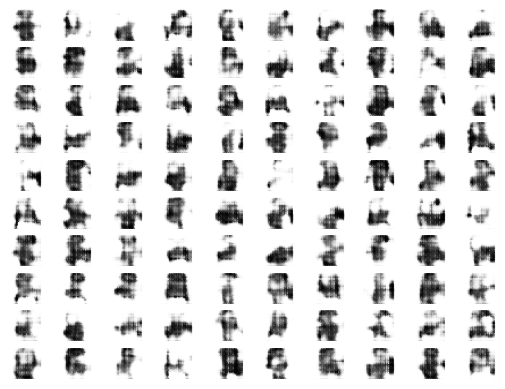

In [9]:
# 載入模型
model = load_model('cgan_generator.keras')
# 生成 100 筆資料
latent_points, labels = generate_latent_points(100, 100)
# 標記 0~9
labels = asarray([x for _ in range(10) for x in range(10)])

# 預測並顯示結果
X  = model.predict([latent_points, labels])
# 將像素範圍由 [-1,1] 轉換為 [0,1]
X = (X + 1) / 2.0
# 繪圖
save_plot(X, 10)